In [1]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import glob
import os
import numpy as np
import sys
sys.path.append( '../src/')
from matplotlib import pyplot as plt
from compile_treeset import compile_folder , compare_treesets


In [2]:
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff


def graph_treedf(tree_resdf , rescols, rescols_norm , outfolder = '../figures/' , prefix = '' ):
    #sns.violinplot(tree_resdf[rescols] , hue=tree_resdf.filtered, split=True , cut =0 , bw=.15)
    if os.path.exists(outfolder ) == False:
        os.mkdir(outfolder)
    
    
    sns.set(rc={'figure.figsize':(10,8)})
    graph = sns.violinplot(tree_resdf[rescols] , cut = 0 , inner= 'box' )
    graph.axhline(max([tree_resdf[col].median() for col in rescols ]) , dashes = [2 , 1 ] )
    plt.xticks(rotation=45)
    
    
    plt.show()
    plt.savefig( outfolder + prefix + '_score.svg')

    sns.set(rc={'figure.figsize':(10,8)})
    graph = sns.violinplot(tree_resdf[rescols_norm] , cut = 0    )
    graph.axhline(max([tree_resdf[col].median() for col in rescols_norm ]) , dashes = [2 , 1 ] )
    plt.xticks(rotation=45)
    plt.show()
    
    
    plt.savefig( outfolder + prefix + '_norm_score.svg')
    
    clean = tree_resdf[rescols].dropna()
    fig = ff.create_distplot([ clean[col] for col in rescols ], [col for col in rescols] , bin_size = 150, show_rug = True)
    fig.show()
    

In [3]:
def compile_results(cladefolders , plotall = False, scorefunc = 'root_score'):
    rescols = ['lddt_1_raw_struct_tree' , 'fident_1_raw_struct_tree', 'alntmscore_1_raw_struct_tree', 'sequences' ]
    rescols_norm = ['lddt_1_raw_struct_tree'+'_norm' , 'fident_1_raw_struct_tree'+'_norm', 'alntmscore_1_raw_struct_tree'+'_norm' , 'sequences'+'_norm']
    dfs = []
    plotall = False
    for folder in cladefolders:
        #try:
        if 'logs' not in folder:
            print(folder)
            res = compile_folder(folder, scorefunc = scorefunc, verbose = True)
            if res :
                tree_resdf , refcols = res
                compare_treesets(tree_resdf  , colfilter= 'sequence' , display_lineplot = False , verbose = True)
                tree_resdf['folder'] = folder

                #add filtered bool column
                tree_resdf['filtered'] = tree_resdf['folder'].apply(lambda x : 'unfiltered' in x)

                if 'OMA' in folder:
                    dfs.append(tree_resdf)
                    if plotall == True:
                        graph_treedf(tree_resdf , rescols, rescols_norm)
                else:
                    dfs.append(tree_resdf)

    total_df = pd.concat(dfs)
    try:
        if 'OMA' in folder:

            graph_treedf(total_df[total_df.filtered == False] , rescols, rescols_norm , prefix = 'OMA' )
            graph_treedf(total_df[total_df.filtered == True] , rescols, rescols_norm , prefix = 'OMA' )
    except:
        print('graphing err' )
    return total_df

In [ ]:
cladefolders = [ '../CAT_data/']# , '../SCOP_data/' ]
scorefunc = 'root_score'
catdf = compile_results(cladefolders, scorefunc = 'root_score' )
print(catdf)

In [ ]:
cladefolders = [ '../CATH_data/']
cathdf = compile_results(cladefolders, scorefunc = 'root_score'  )
print(cathdf)

In [ ]:
#todo iterate over hogs and cath and train a model
cladefolders = set(glob.glob( '../OMA_data/*/' ))-set([ '../OMA_data/logs/' ])
cladefolders = cladefolders.union( set(glob.glob( '../OMA_data_unfiltered/OMA_data/*/' )) - set([ '../OMA_data_unfiltered/OMA_data/logs/' ]) )
OMADF = compile_results(cladefolders , scorefunc = 'root_score' )

In [7]:
#save cat , cath and omadf
catdf.to_pickle('catdf.pkl')
cathdf.to_pickle('cathdf.pkl')
OMADF.to_pickle('omadf.pkl')


In [4]:
catdf = pd.read_pickle('catdf.pkl')
cathdf = pd.read_pickle('cathdf.pkl')
OMADF = pd.read_pickle('omadf.pkl')

In [5]:
import seaborn as sns
filtereddf  = OMADF[OMADF.filtered == True]
unfiltereddf  = OMADF[OMADF.filtered == False]

In [6]:
print(len(filtereddf) , len(unfiltereddf))

4144 3062


In [7]:
def ret_winner(r, score1 , score2):
    if r[score1] < r[score2]:
        return 'True'
    if r[score1] > r[score2]:
        return 'False'
    if r[score1] == r[score2]:
        return 'Equal'
    
def retgraph(s1,s2 , filtereddf , xlabel , ylabel, title):
    sns.set_style("whitegrid")
    palette = { 'True' : 'blue'  , 'False' : 'red' , 'Equal' : 'green'}
    markers= {'markers' : {  'True' : 'o'  , 'False' : 'x' , 'Equal' : 'D'}}
    plt.rcParams['figure.dpi'] = 300

    
    filtereddf['structure better'] = filtereddf.apply( ret_winner , args = ( s1,  s2) , axis = 1)
    # Count the occurrences of each item
    category_counts = dict(filtereddf['structure better'].value_counts())
    totalpts = len(filtereddf['structure better'])
    ax = sns.scatterplot( data =filtereddf ,  x=s1 , y=s2 
    , hue = 'structure better'  , alpha = .25 , palette=palette  , s=10 )
    
    ax.set_box_aspect(1)
    
    handles, labels = ax.get_legend_handles_labels()
    print(handles,labels)
    
    for i, label in enumerate(labels):
        count = category_counts[label]
        labels[i] = f"{label} ({count} , {int(100*count/totalpts)}%)"
    #labels.sort()
    
    ax.legend(handles=handles, labels=labels ,fontsize='large')
    
    
    # Update the legend labels with the count information
    #ax.legend(loc='upper left')
    
    ax.set_title(title ,fontsize=20)
    ax.set_ylabel(ylabel ,fontsize=17)
    ax.set_xlabel(xlabel ,fontsize=17)
    
    plt.plot([0,370] ,[0,370]  , alpha = .25)
    ax.set_ylim(1, 370)
    ax.set_xlim(1, 370)
    
    plt.savefig('../figures/'+title.replace(' ', '_')+'.svg')
    plt.show()

    

[<matplotlib.collections.PathCollection object at 0x7fa47c45b4c0>, <matplotlib.collections.PathCollection object at 0x7fa47c45b910>, <matplotlib.collections.PathCollection object at 0x7fa47c45bd60>] ['True', 'False', 'Equal']


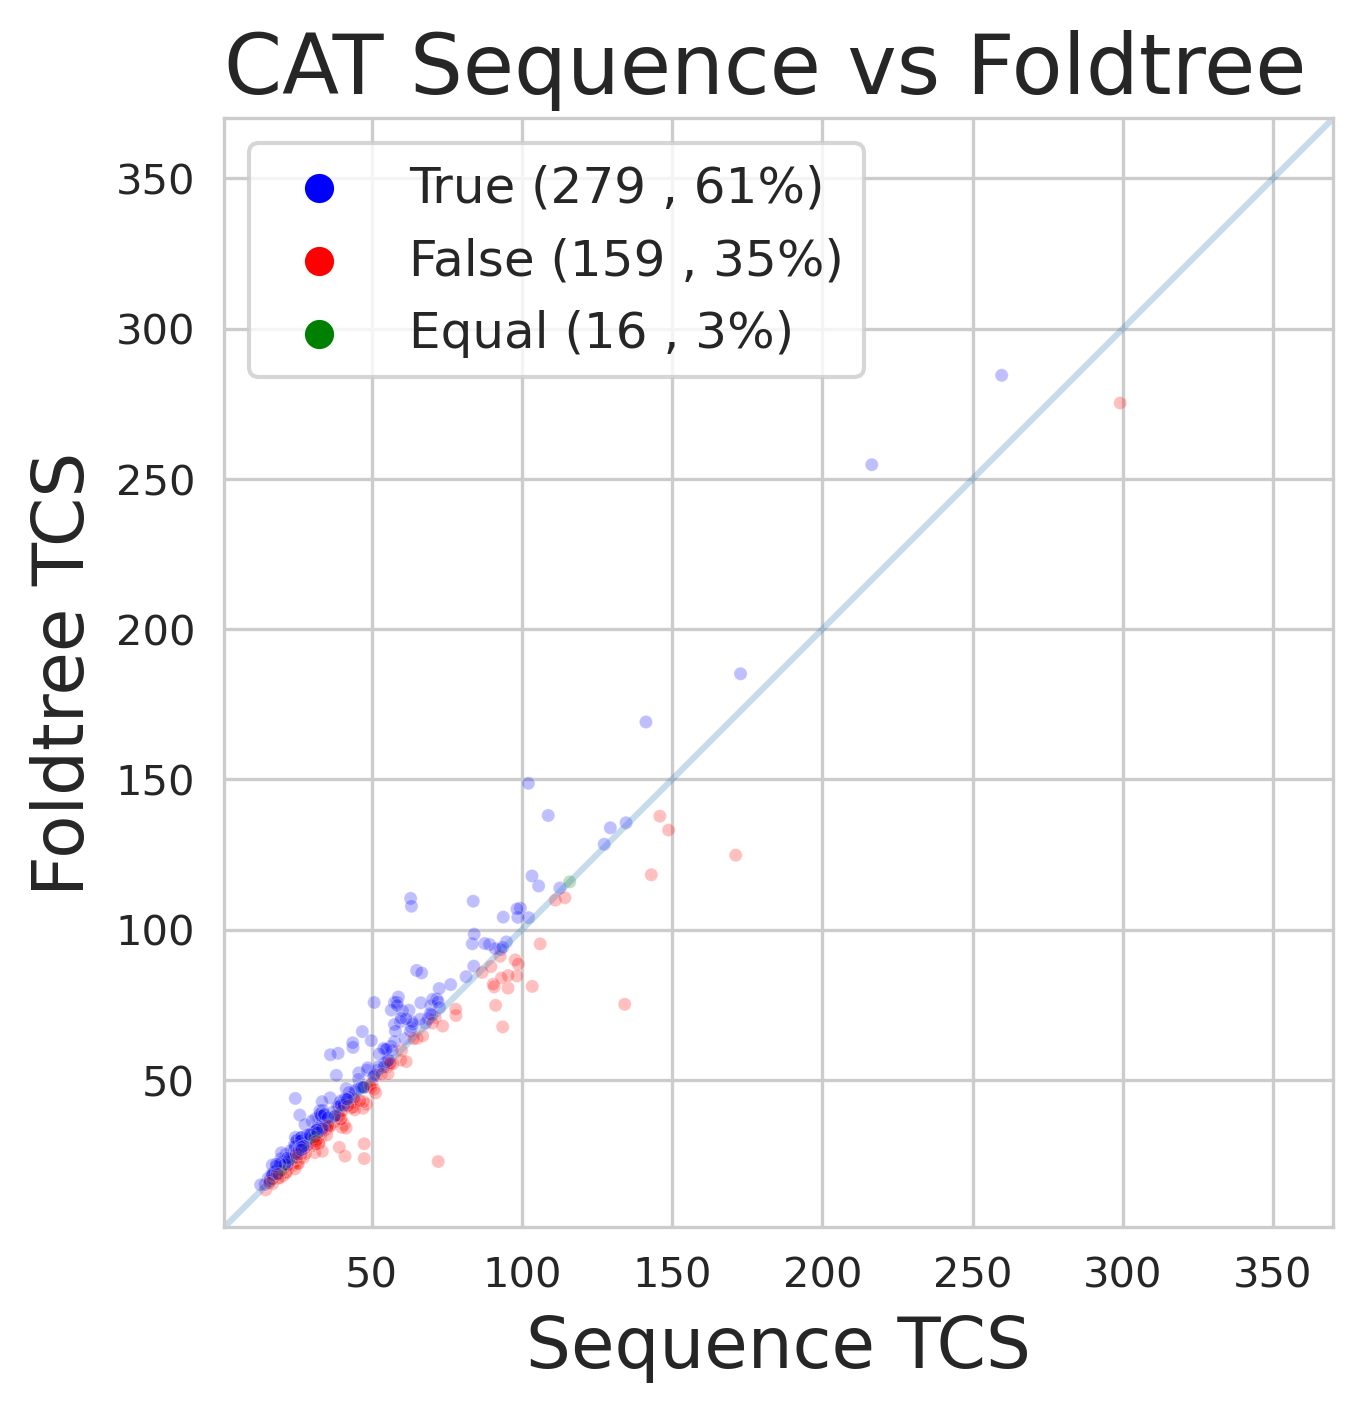

[<matplotlib.collections.PathCollection object at 0x7fa47c330670>, <matplotlib.collections.PathCollection object at 0x7fa47c248340>, <matplotlib.collections.PathCollection object at 0x7fa47c248790>] ['False', 'True', 'Equal']


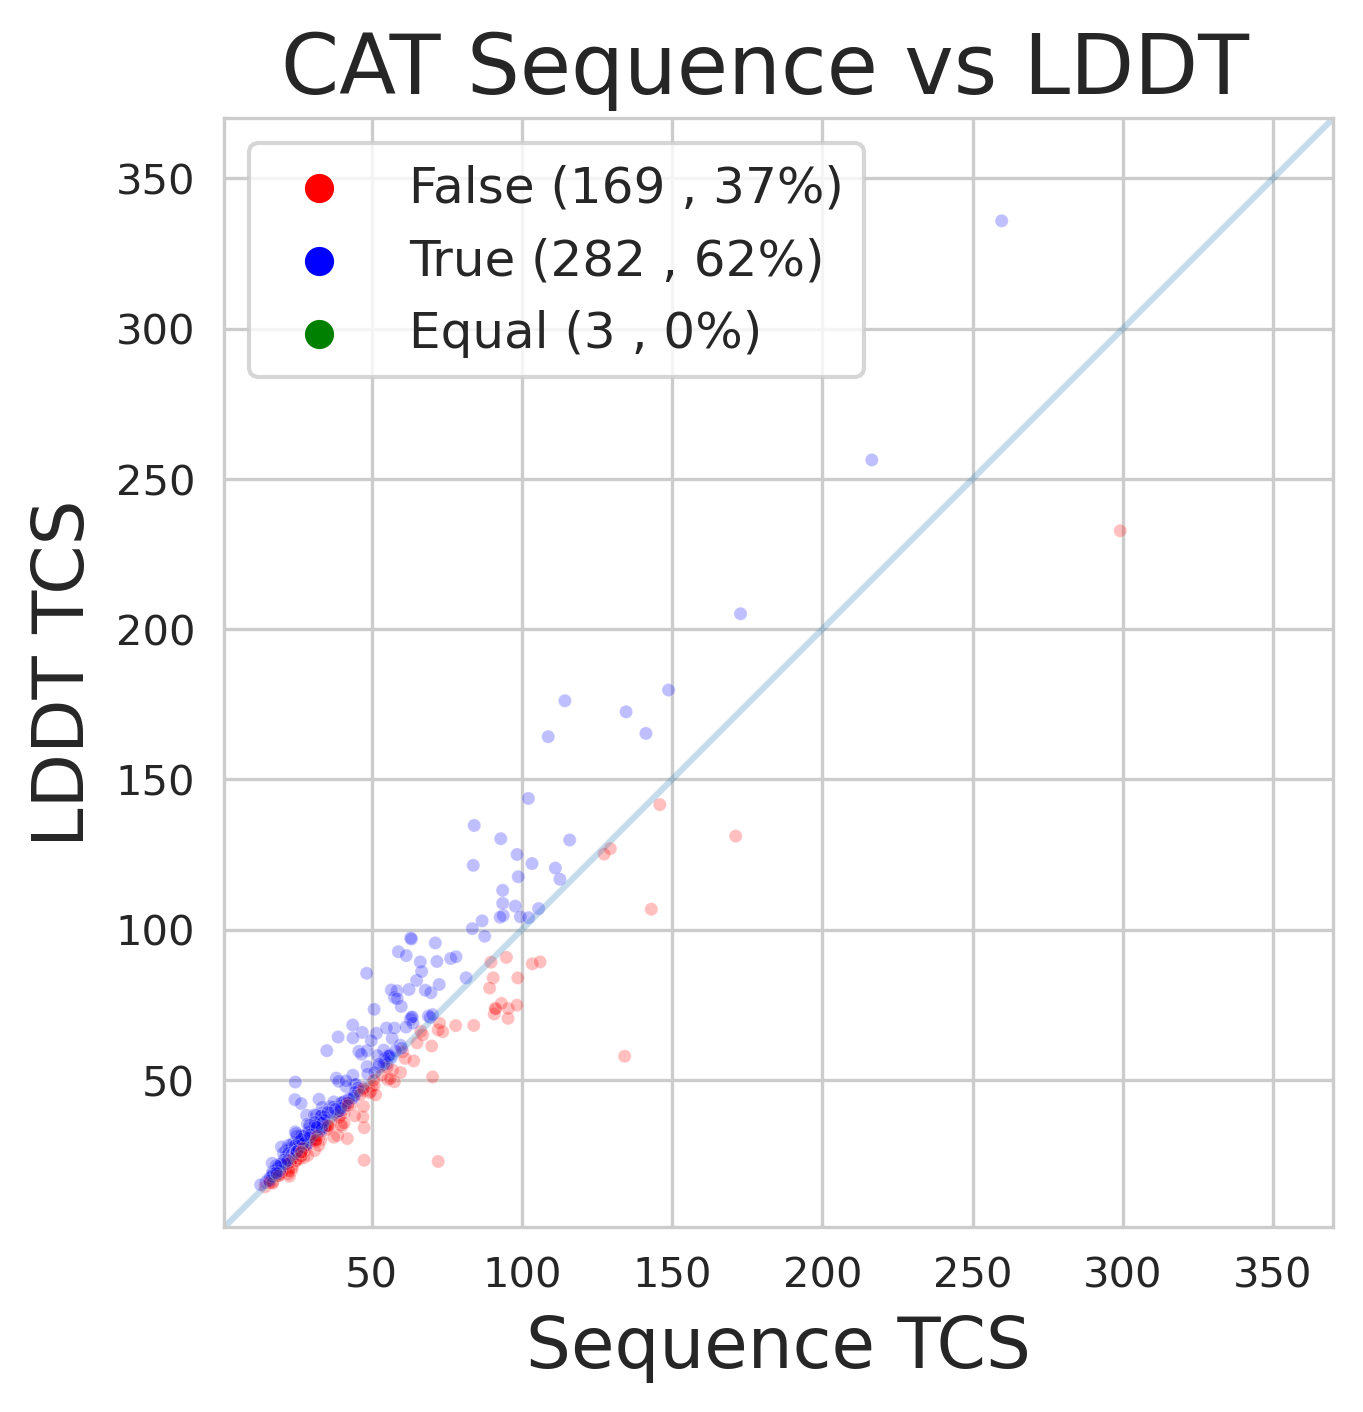

[<matplotlib.collections.PathCollection object at 0x7fa47c158af0>, <matplotlib.collections.PathCollection object at 0x7fa47c15af20>, <matplotlib.collections.PathCollection object at 0x7fa47c15b370>] ['False', 'True', 'Equal']


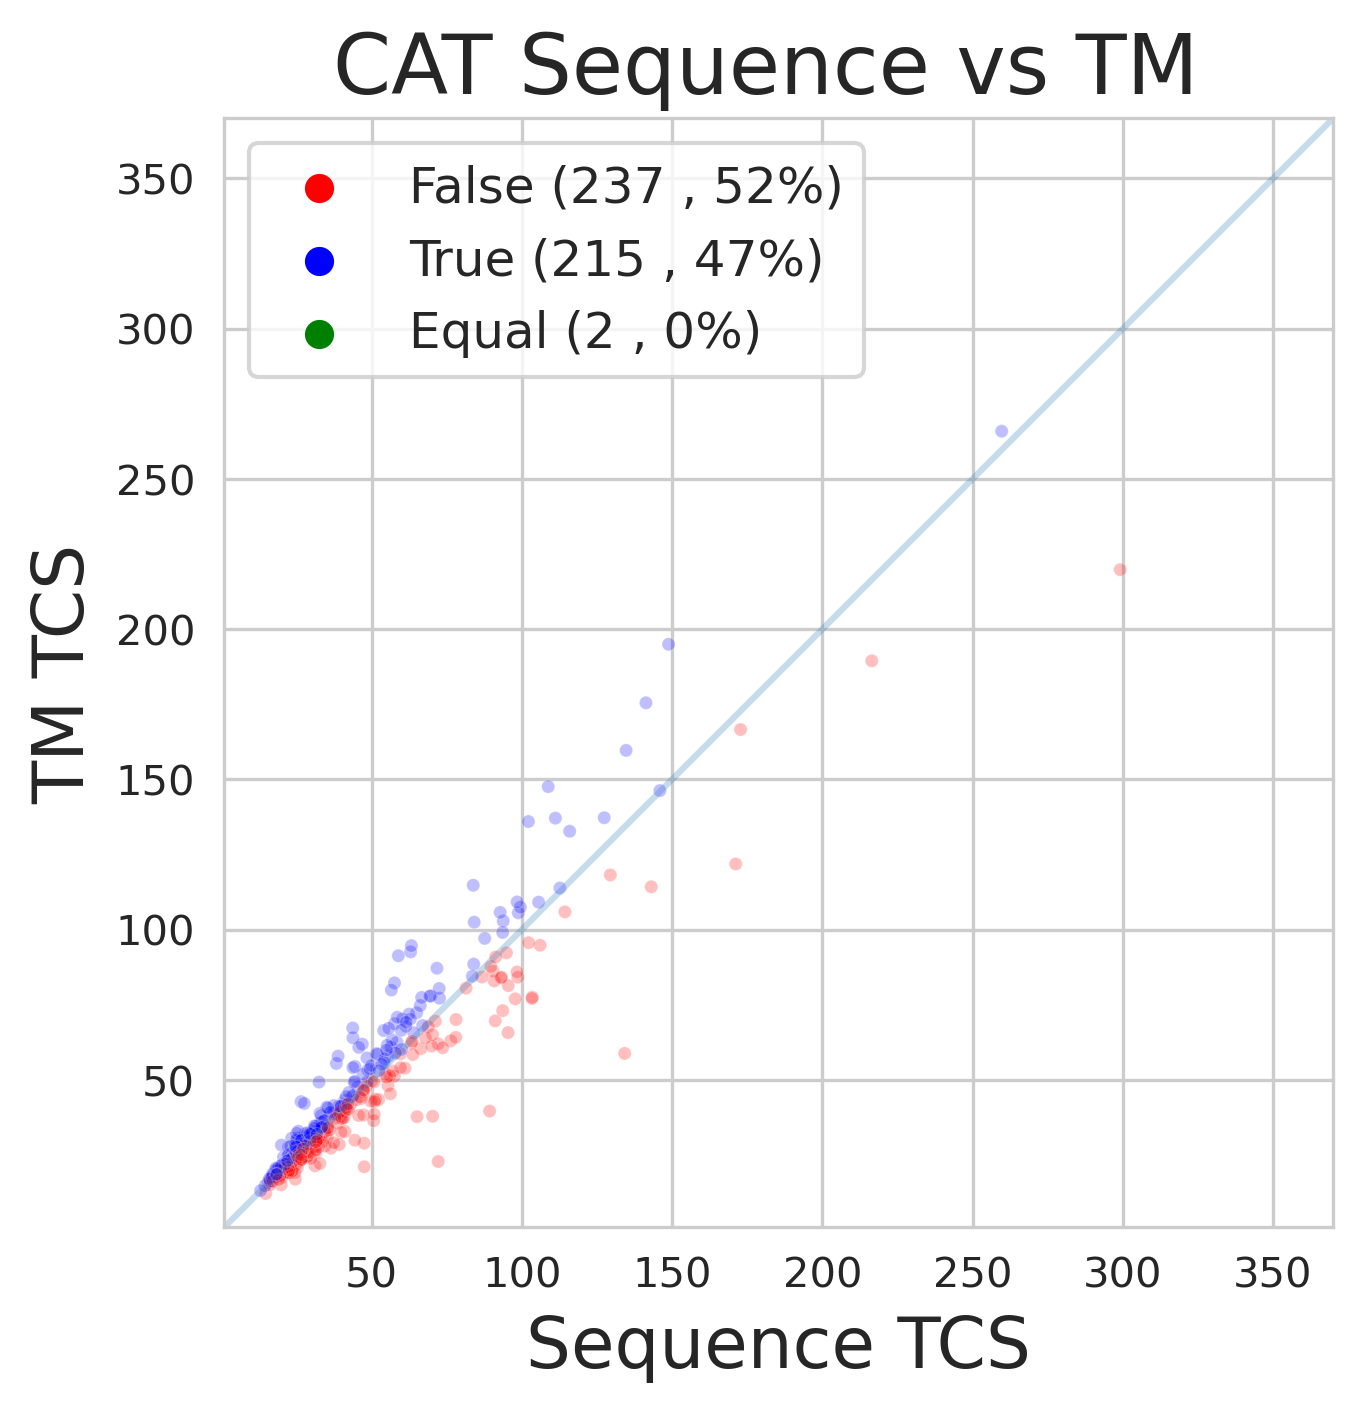

In [8]:
#species tree discordance for cat dataset
retgraph(  'sequences_norm' , 'fident_1_raw_struct_tree_norm' ,  catdf
         ,'Sequence TCS' ,  'Foldtree TCS',  'CAT Sequence vs Foldtree ')
retgraph(  'sequences_norm' , 'lddt_1_raw_struct_tree_norm' ,  catdf
         ,'Sequence TCS' ,  'LDDT TCS',  'CAT Sequence vs LDDT ')
retgraph(  'sequences_norm' , 'alntmscore_1_raw_struct_tree_norm' ,  catdf
         ,'Sequence TCS' ,  'TM TCS',  'CAT Sequence vs TM ')

[<matplotlib.collections.PathCollection object at 0x7fa47c2bd420>, <matplotlib.collections.PathCollection object at 0x7fa47c138160>, <matplotlib.collections.PathCollection object at 0x7fa47c15ba30>] ['True', 'False', 'Equal']


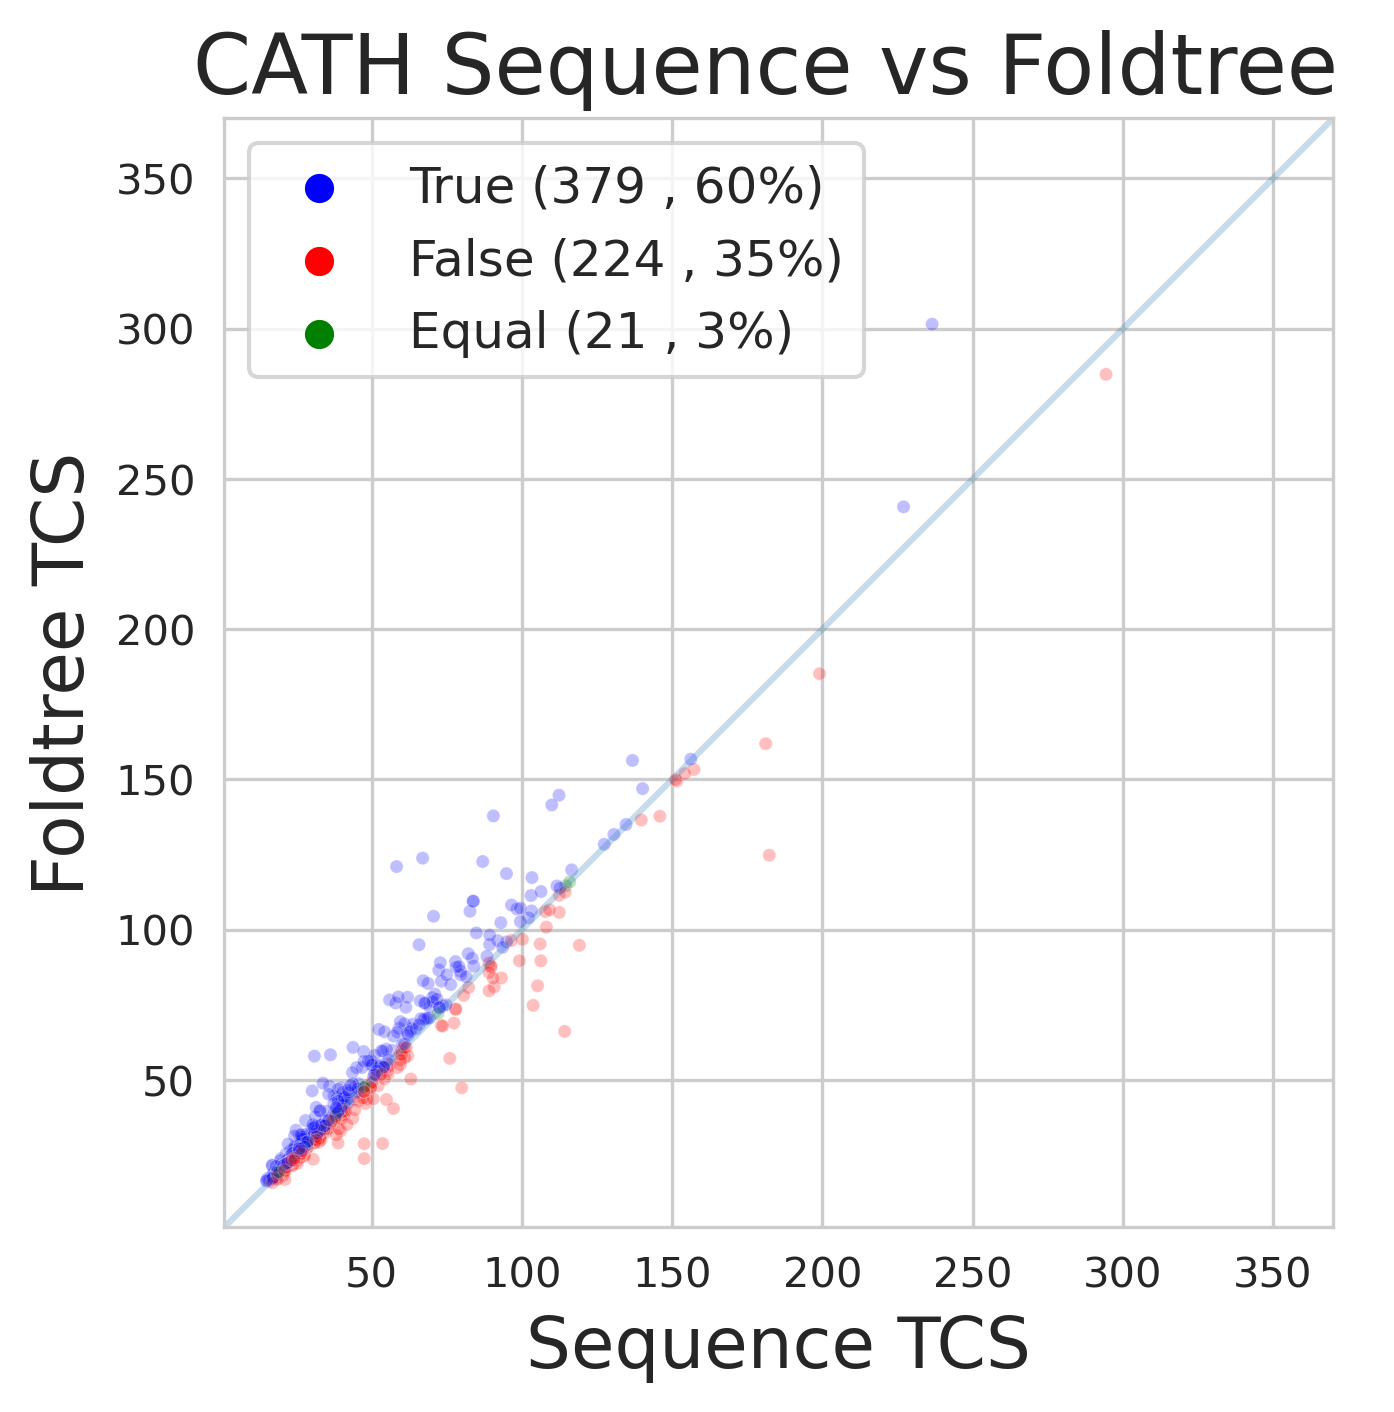

[<matplotlib.collections.PathCollection object at 0x7fa4796083d0>, <matplotlib.collections.PathCollection object at 0x7fa479608820>, <matplotlib.collections.PathCollection object at 0x7fa479608c70>] ['True', 'False', 'Equal']


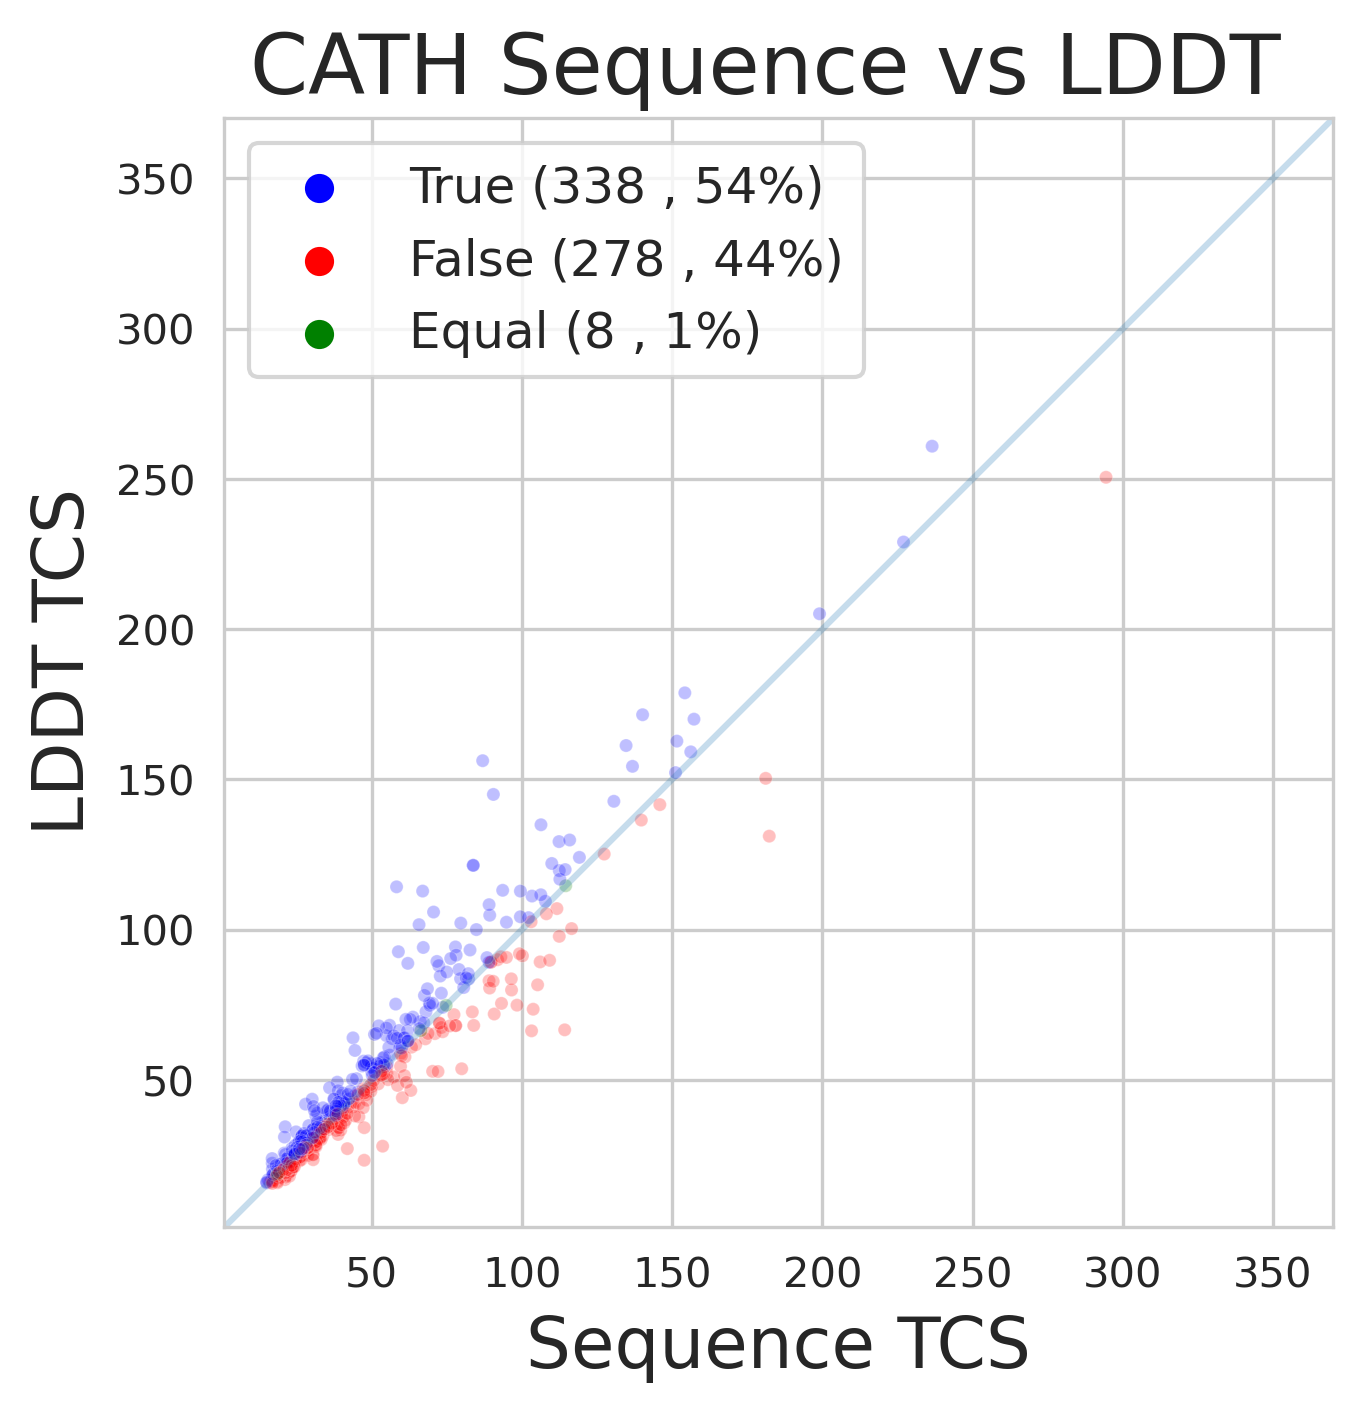

[<matplotlib.collections.PathCollection object at 0x7fa4796bcac0>, <matplotlib.collections.PathCollection object at 0x7fa4796bcf10>, <matplotlib.collections.PathCollection object at 0x7fa4796af3a0>] ['False', 'True', 'Equal']


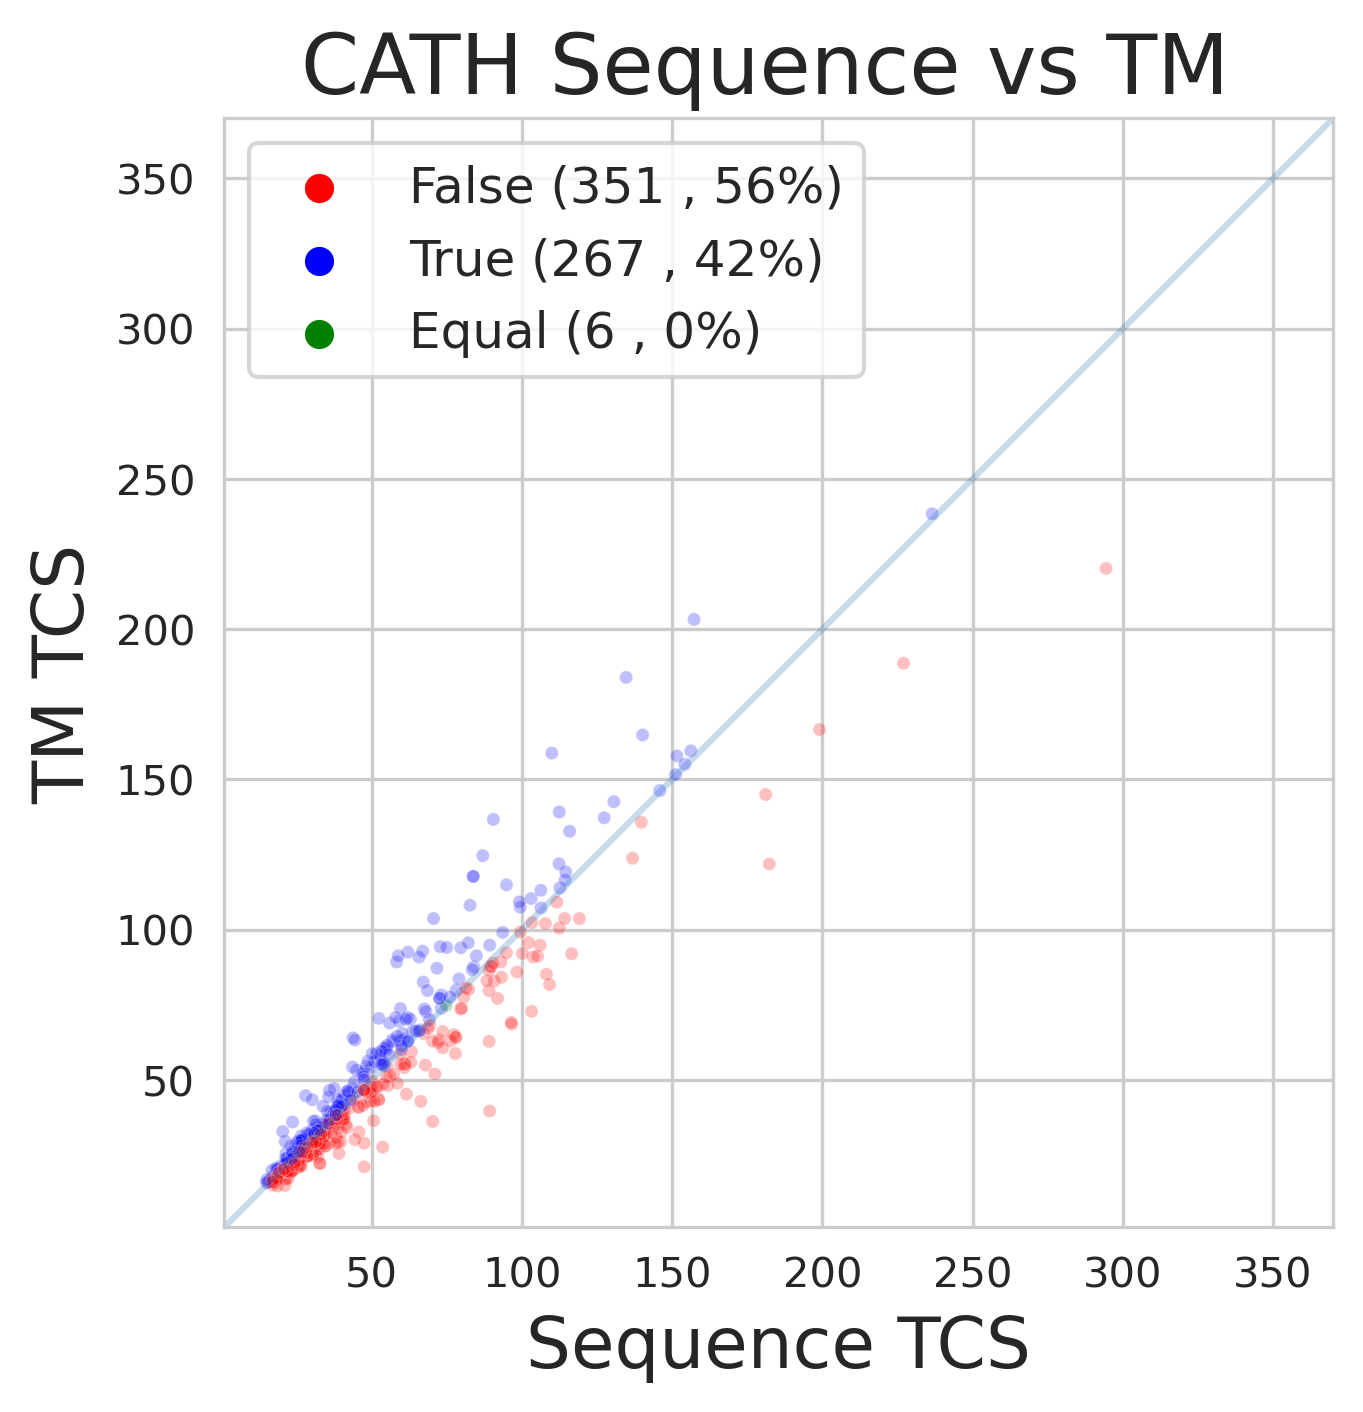

In [9]:
#species tree discordance for cat dataset
retgraph(  'sequences_norm' , 'fident_1_raw_struct_tree_norm' ,  cathdf
         ,'Sequence TCS' ,  'Foldtree TCS',  'CATH Sequence vs Foldtree ')
retgraph(  'sequences_norm' , 'lddt_1_raw_struct_tree_norm' ,  cathdf
         ,'Sequence TCS' ,  ' LDDT TCS',  'CATH Sequence vs LDDT ')
retgraph(  'sequences_norm' , 'alntmscore_1_raw_struct_tree_norm' ,  cathdf
         ,'Sequence TCS' ,  'TM TCS',  'CATH Sequence vs TM ')

[<matplotlib.collections.PathCollection object at 0x7fa47b80d390>, <matplotlib.collections.PathCollection object at 0x7fa47b80d7e0>, <matplotlib.collections.PathCollection object at 0x7fa47b834c70>] ['True', 'False', 'Equal']


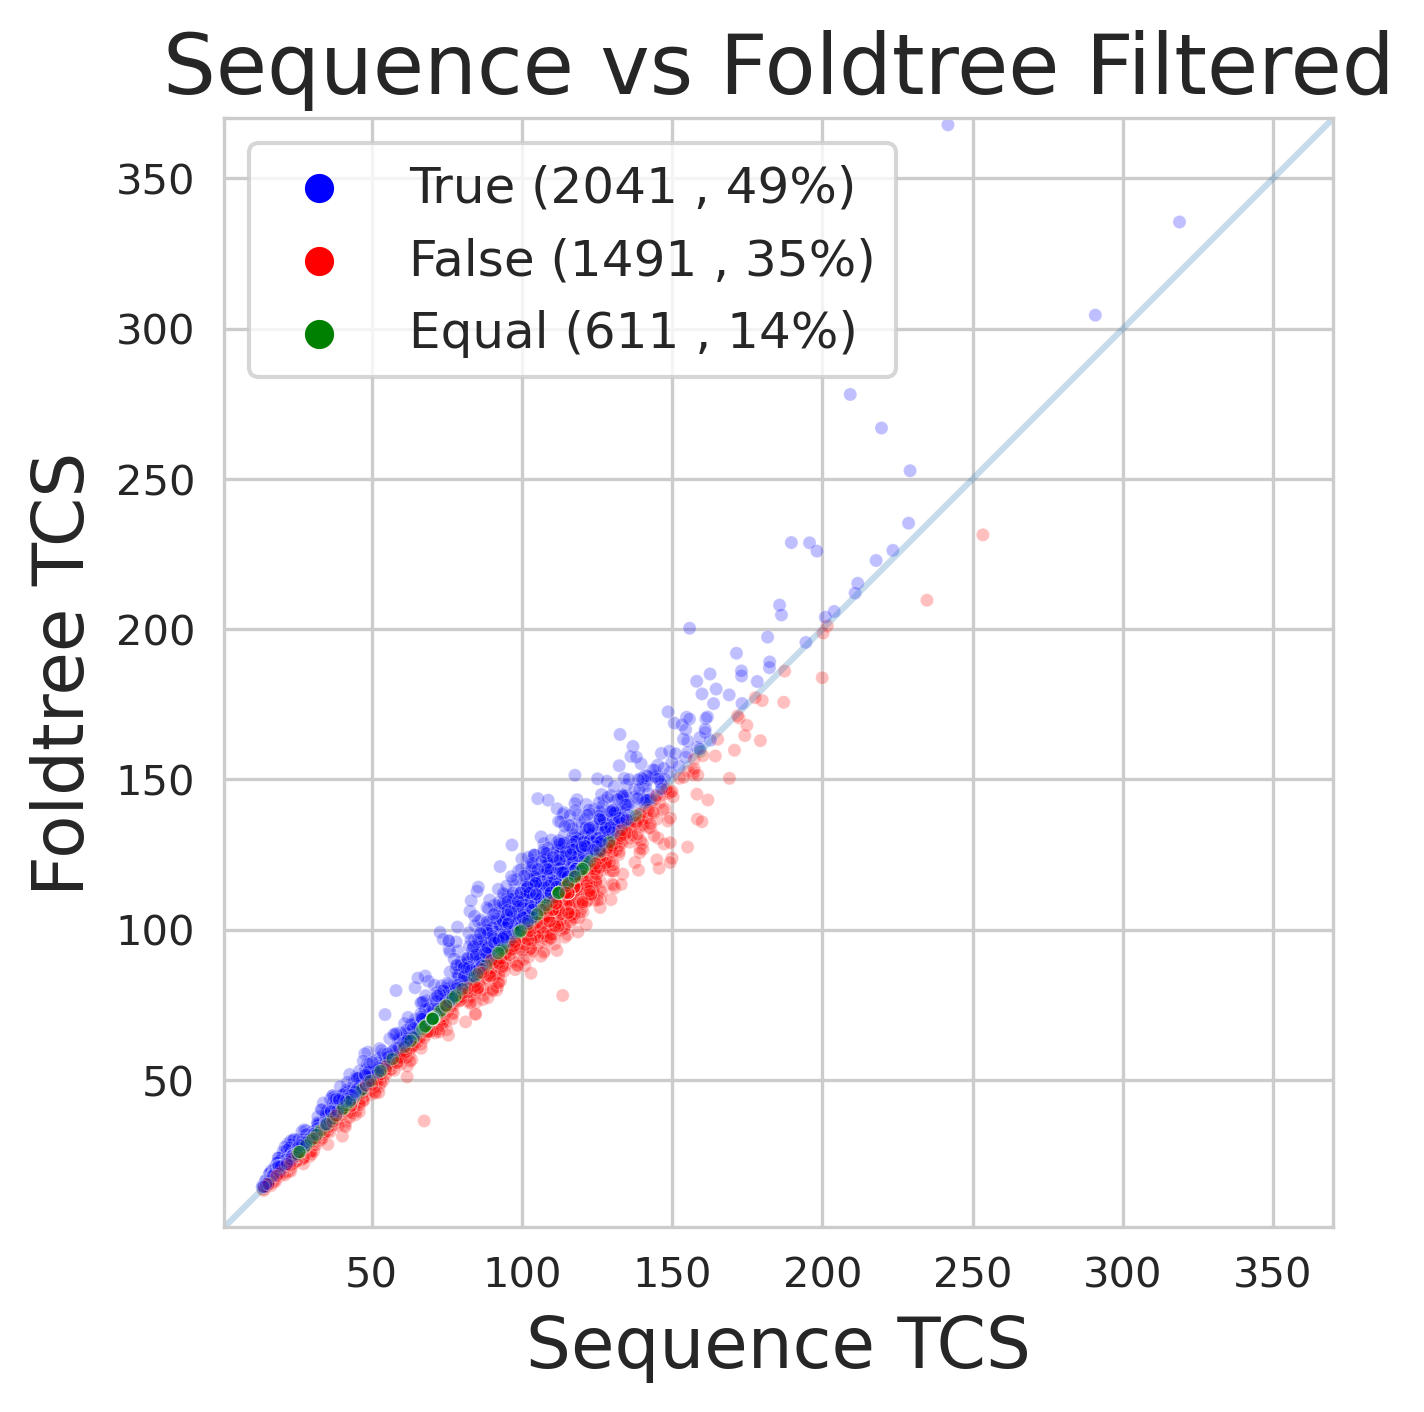

In [10]:
retgraph(  'sequences_norm' , 'fident_1_raw_struct_tree_norm' , filtereddf 
         ,'Sequence TCS' ,  'Foldtree TCS',  'Sequence vs Foldtree Filtered')

[<matplotlib.collections.PathCollection object at 0x7fa47b980190>, <matplotlib.collections.PathCollection object at 0x7fa47b9805e0>, <matplotlib.collections.PathCollection object at 0x7fa47b7af9d0>] ['True', 'False', 'Equal']


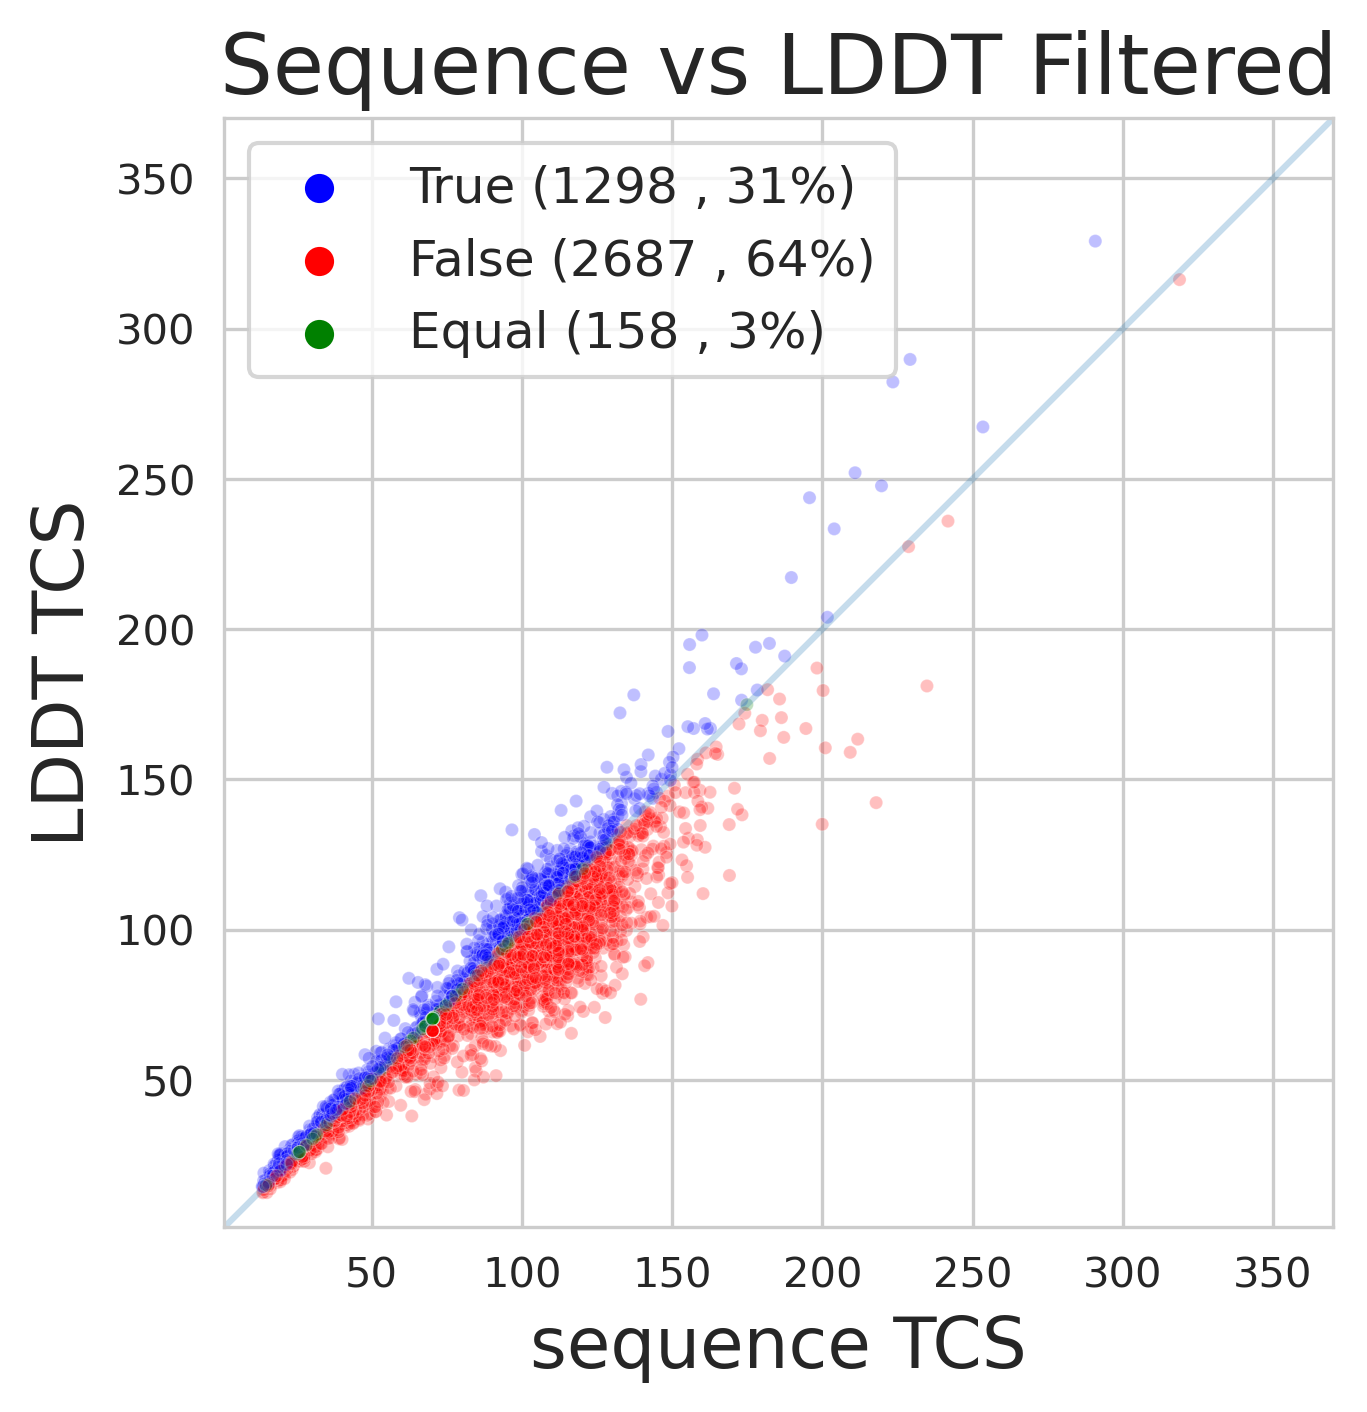

In [11]:

retgraph(  'sequences_norm' , 'lddt_1_raw_struct_tree_norm' , filtereddf 
         ,'sequence TCS' ,  'LDDT TCS',  'Sequence vs LDDT Filtered')

[<matplotlib.collections.PathCollection object at 0x7fa47b9149a0>, <matplotlib.collections.PathCollection object at 0x7fa47b7ac040>, <matplotlib.collections.PathCollection object at 0x7fa47b7acb20>] ['True', 'False', 'Equal']


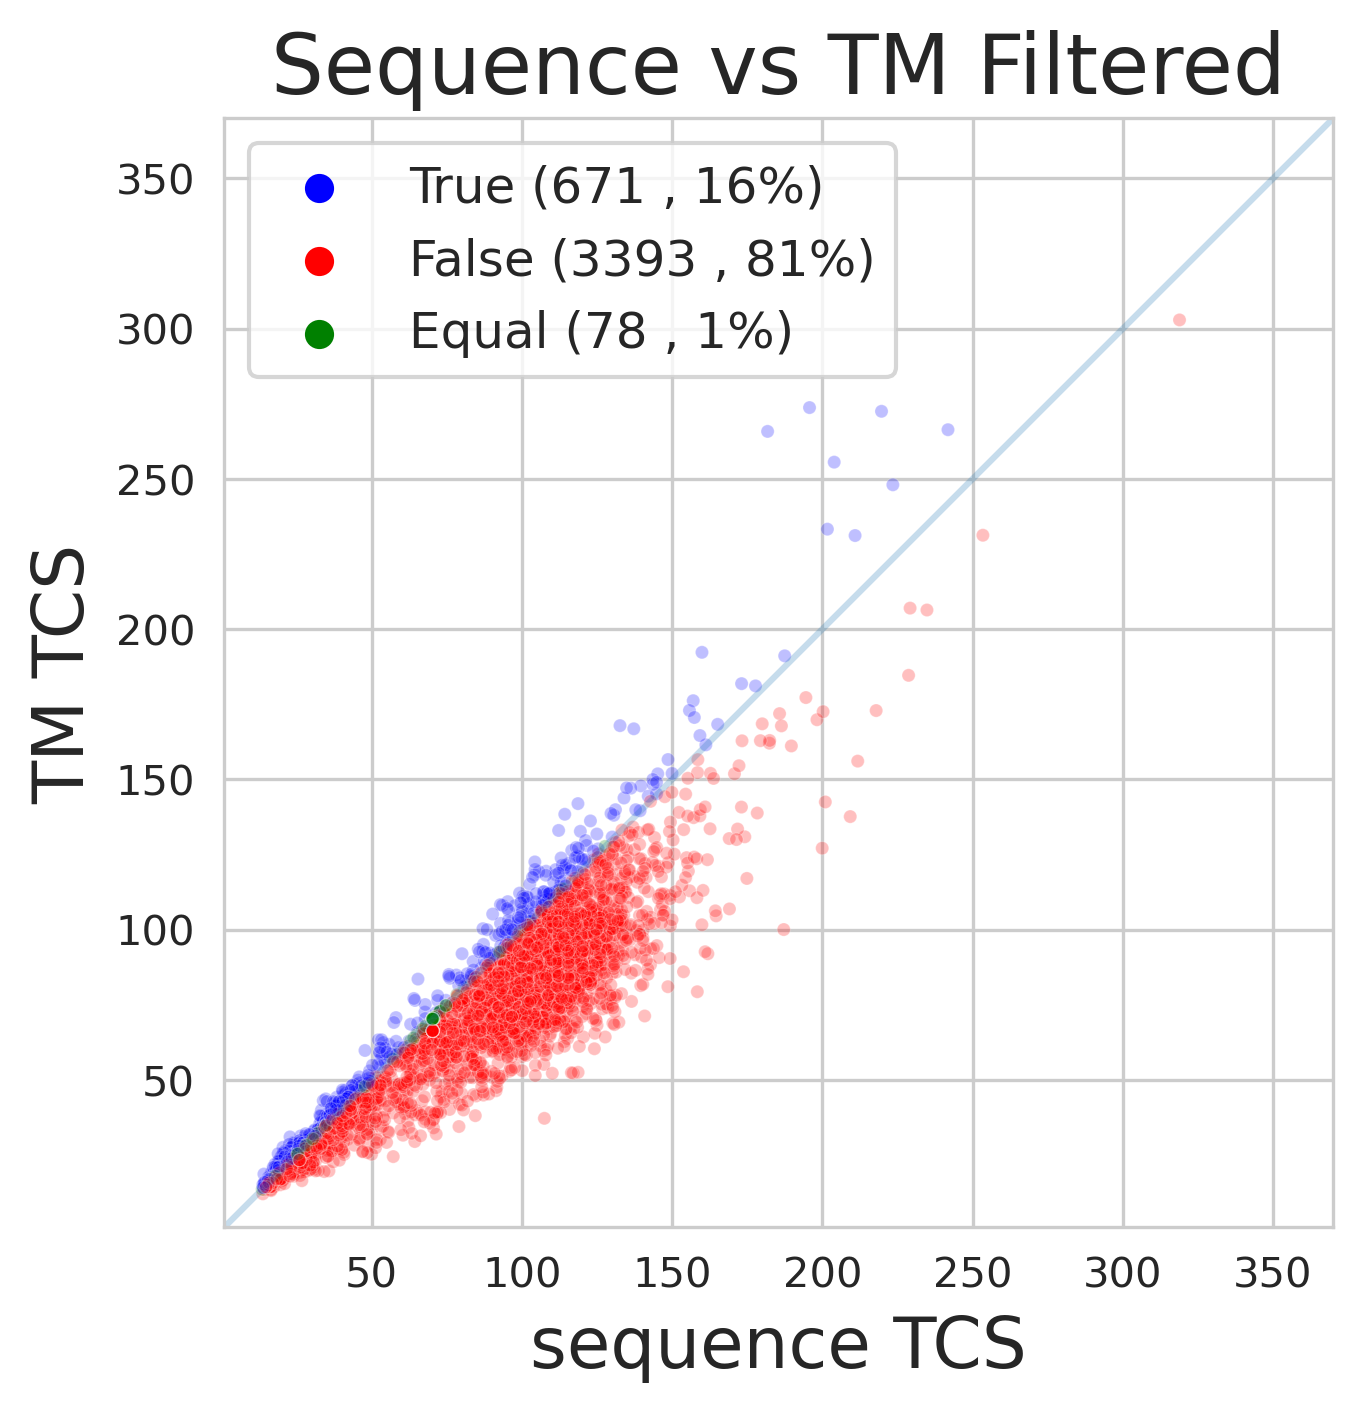

In [12]:

retgraph(  'sequences_norm' , 'alntmscore_1_raw_struct_tree_norm' , filtereddf 
         ,'sequence TCS' ,  'TM TCS',  'Sequence vs TM Filtered')


[<matplotlib.collections.PathCollection object at 0x7fa4795e9180>, <matplotlib.collections.PathCollection object at 0x7fa4795e9840>, <matplotlib.collections.PathCollection object at 0x7fa4795e8be0>] ['False', 'True', 'Equal']


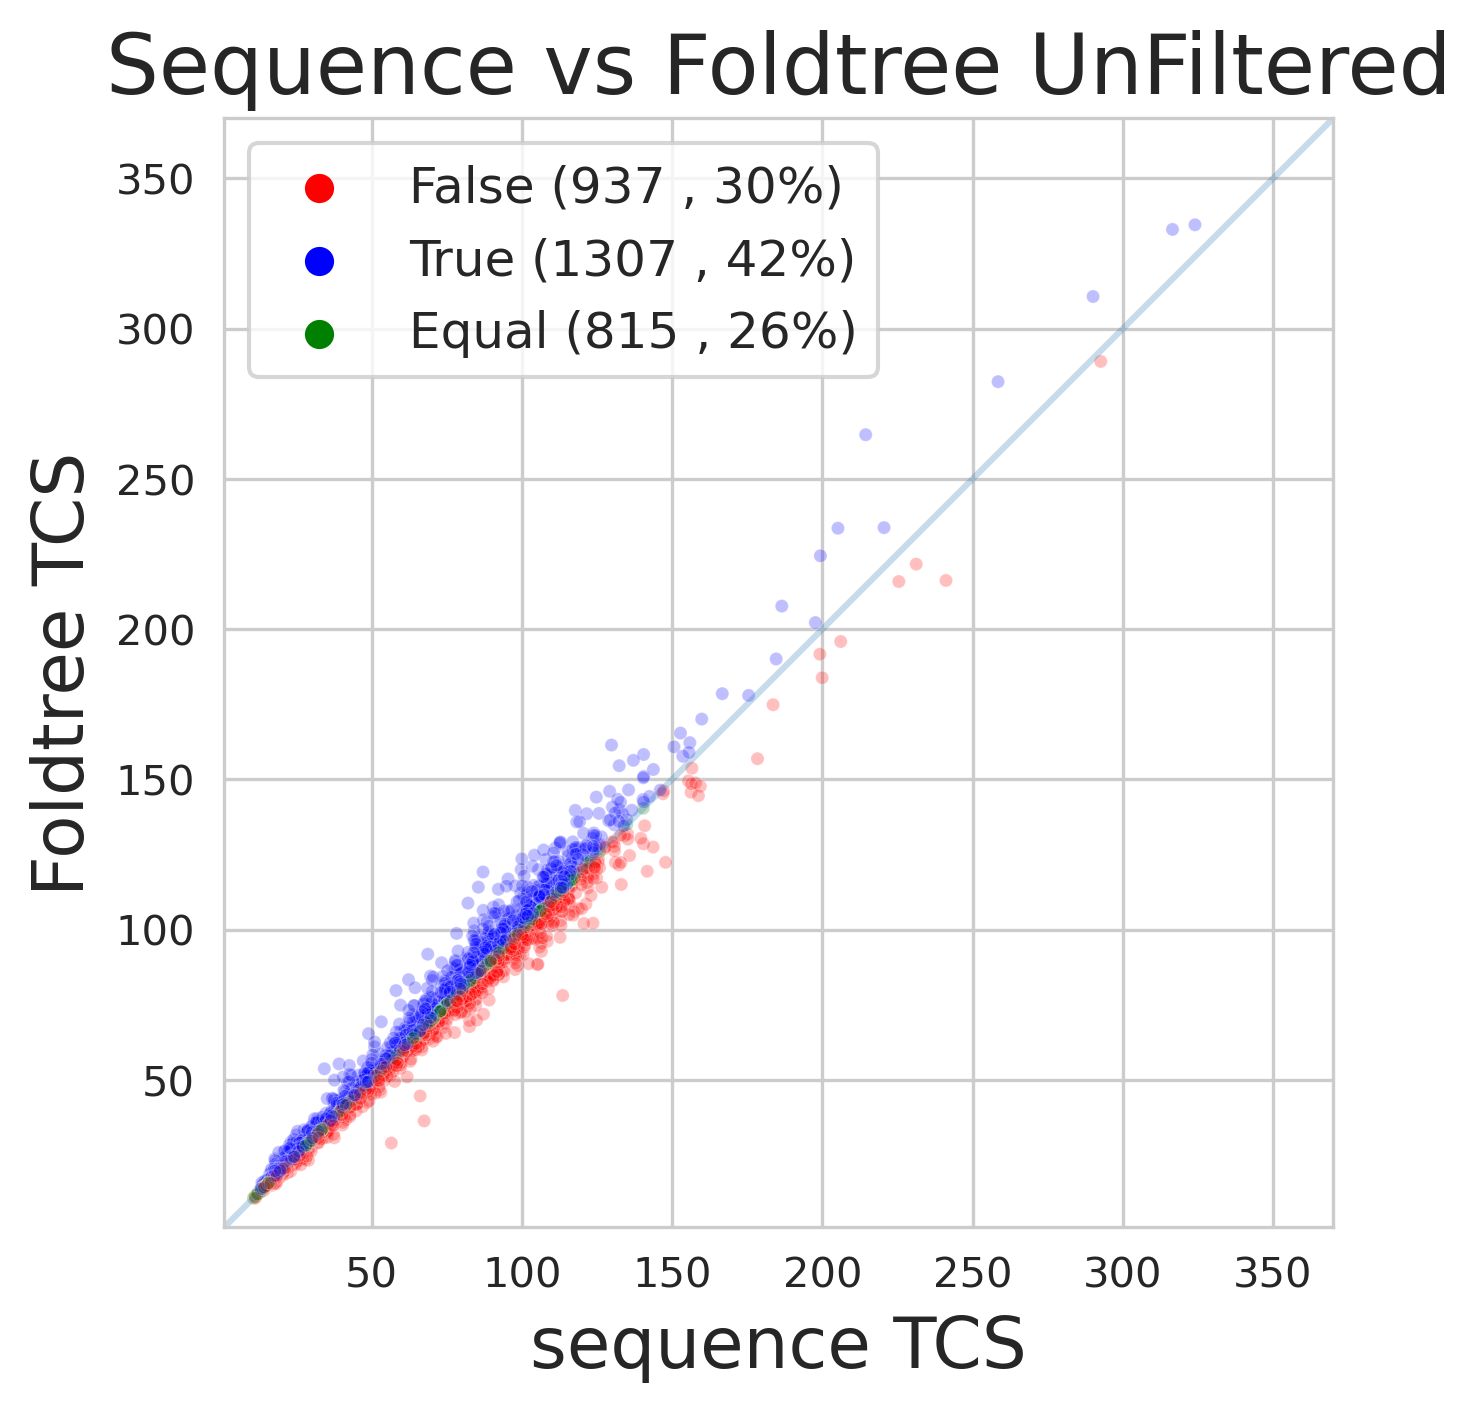

In [13]:
retgraph(  'sequences_norm' , 'fident_1_raw_struct_tree_norm' , unfiltereddf 
         ,'sequence TCS' ,  'Foldtree TCS',  'Sequence vs Foldtree UnFiltered')

[<matplotlib.collections.PathCollection object at 0x7fa47c4efac0>, <matplotlib.collections.PathCollection object at 0x7fa47e4bcc10>, <matplotlib.collections.PathCollection object at 0x7fa47e4bd090>] ['True', 'False', 'Equal']


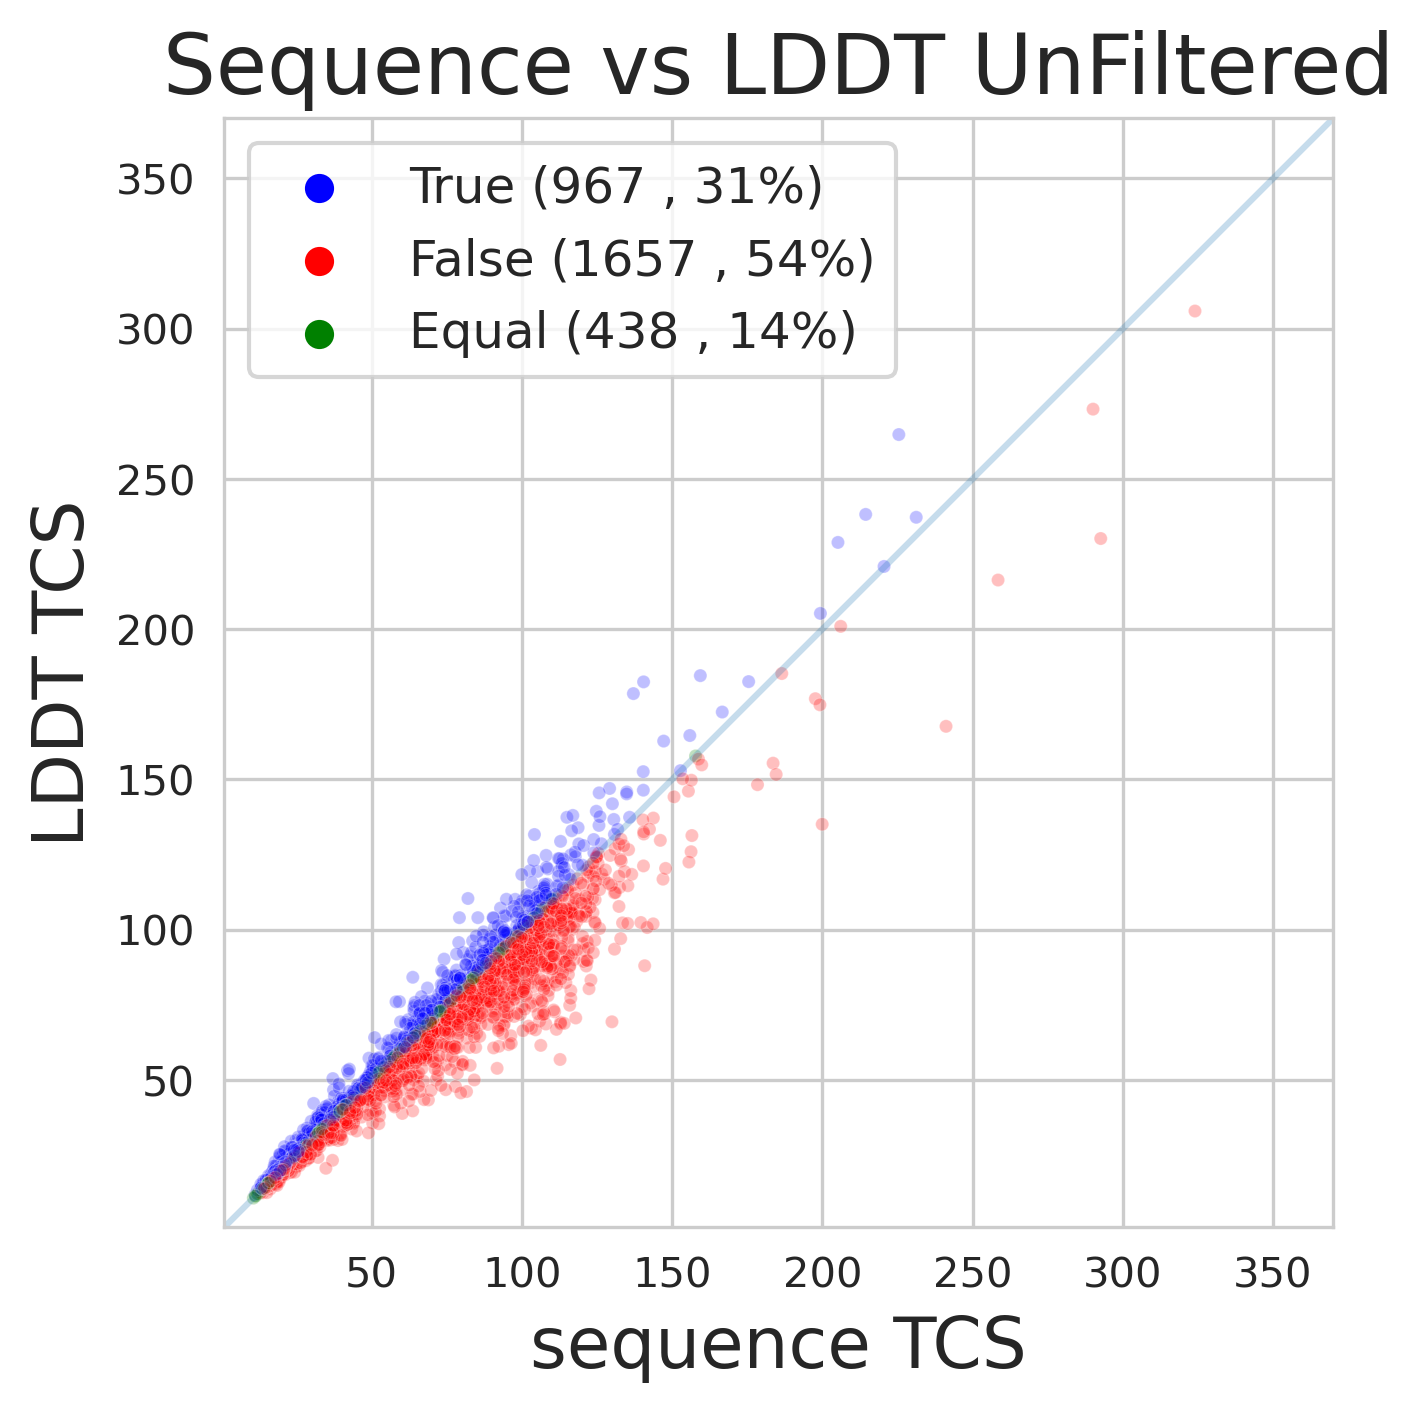

In [14]:
retgraph(  'sequences_norm' , 'lddt_1_raw_struct_tree_norm' , unfiltereddf 
         ,'sequence TCS' ,  'LDDT TCS',  'Sequence vs LDDT UnFiltered')

[<matplotlib.collections.PathCollection object at 0x7fa47b90f220>, <matplotlib.collections.PathCollection object at 0x7fa47b90f670>, <matplotlib.collections.PathCollection object at 0x7fa47960ae30>] ['True', 'False', 'Equal']


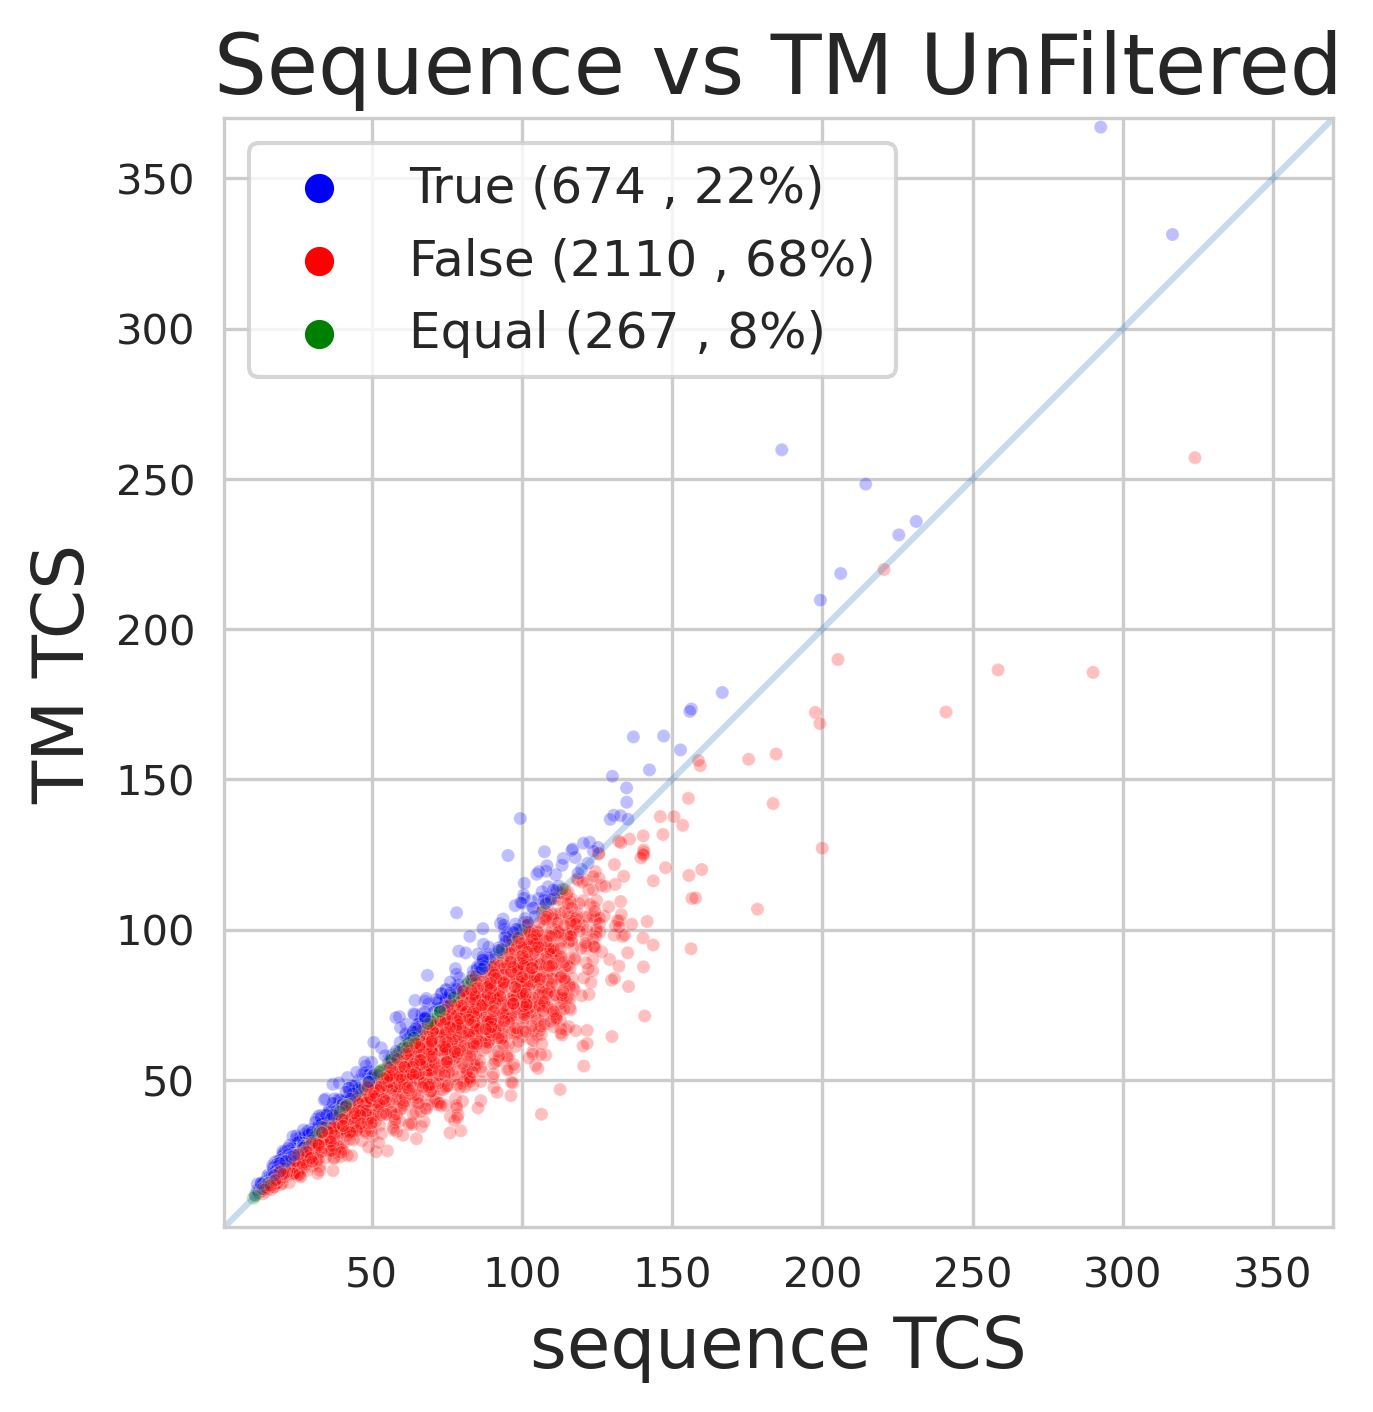

In [15]:
retgraph(  'sequences_norm' , 'alntmscore_1_raw_struct_tree_norm' , unfiltereddf 
         ,'sequence TCS' ,  'TM TCS',  'Sequence vs TM UnFiltered')

[<matplotlib.collections.PathCollection object at 0x7fa47849d420>, <matplotlib.collections.PathCollection object at 0x7fa47849d870>, <matplotlib.collections.PathCollection object at 0x7fa47849dcc0>] ['True', 'Equal', 'False']


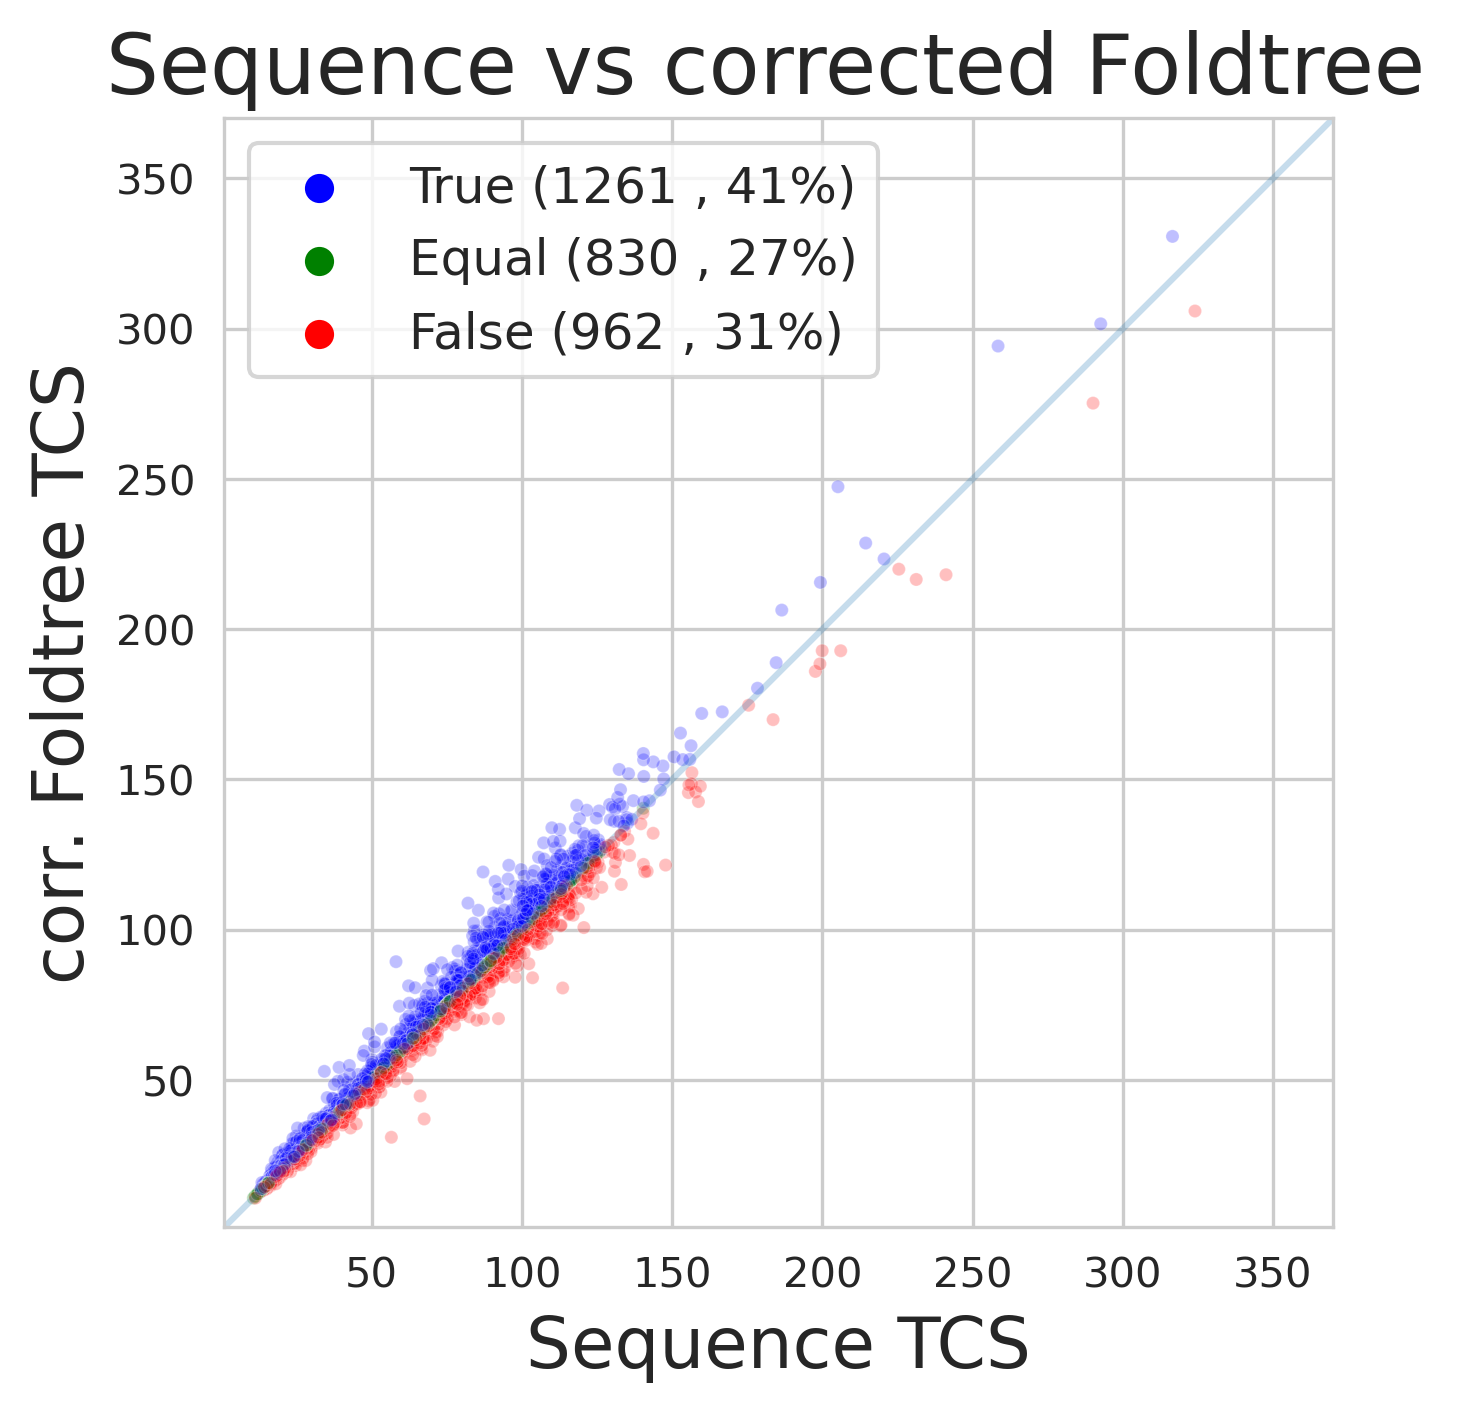

[<matplotlib.collections.PathCollection object at 0x7fa47817eb60>, <matplotlib.collections.PathCollection object at 0x7fa47817efb0>, <matplotlib.collections.PathCollection object at 0x7fa47817f400>] ['True', 'False', 'Equal']


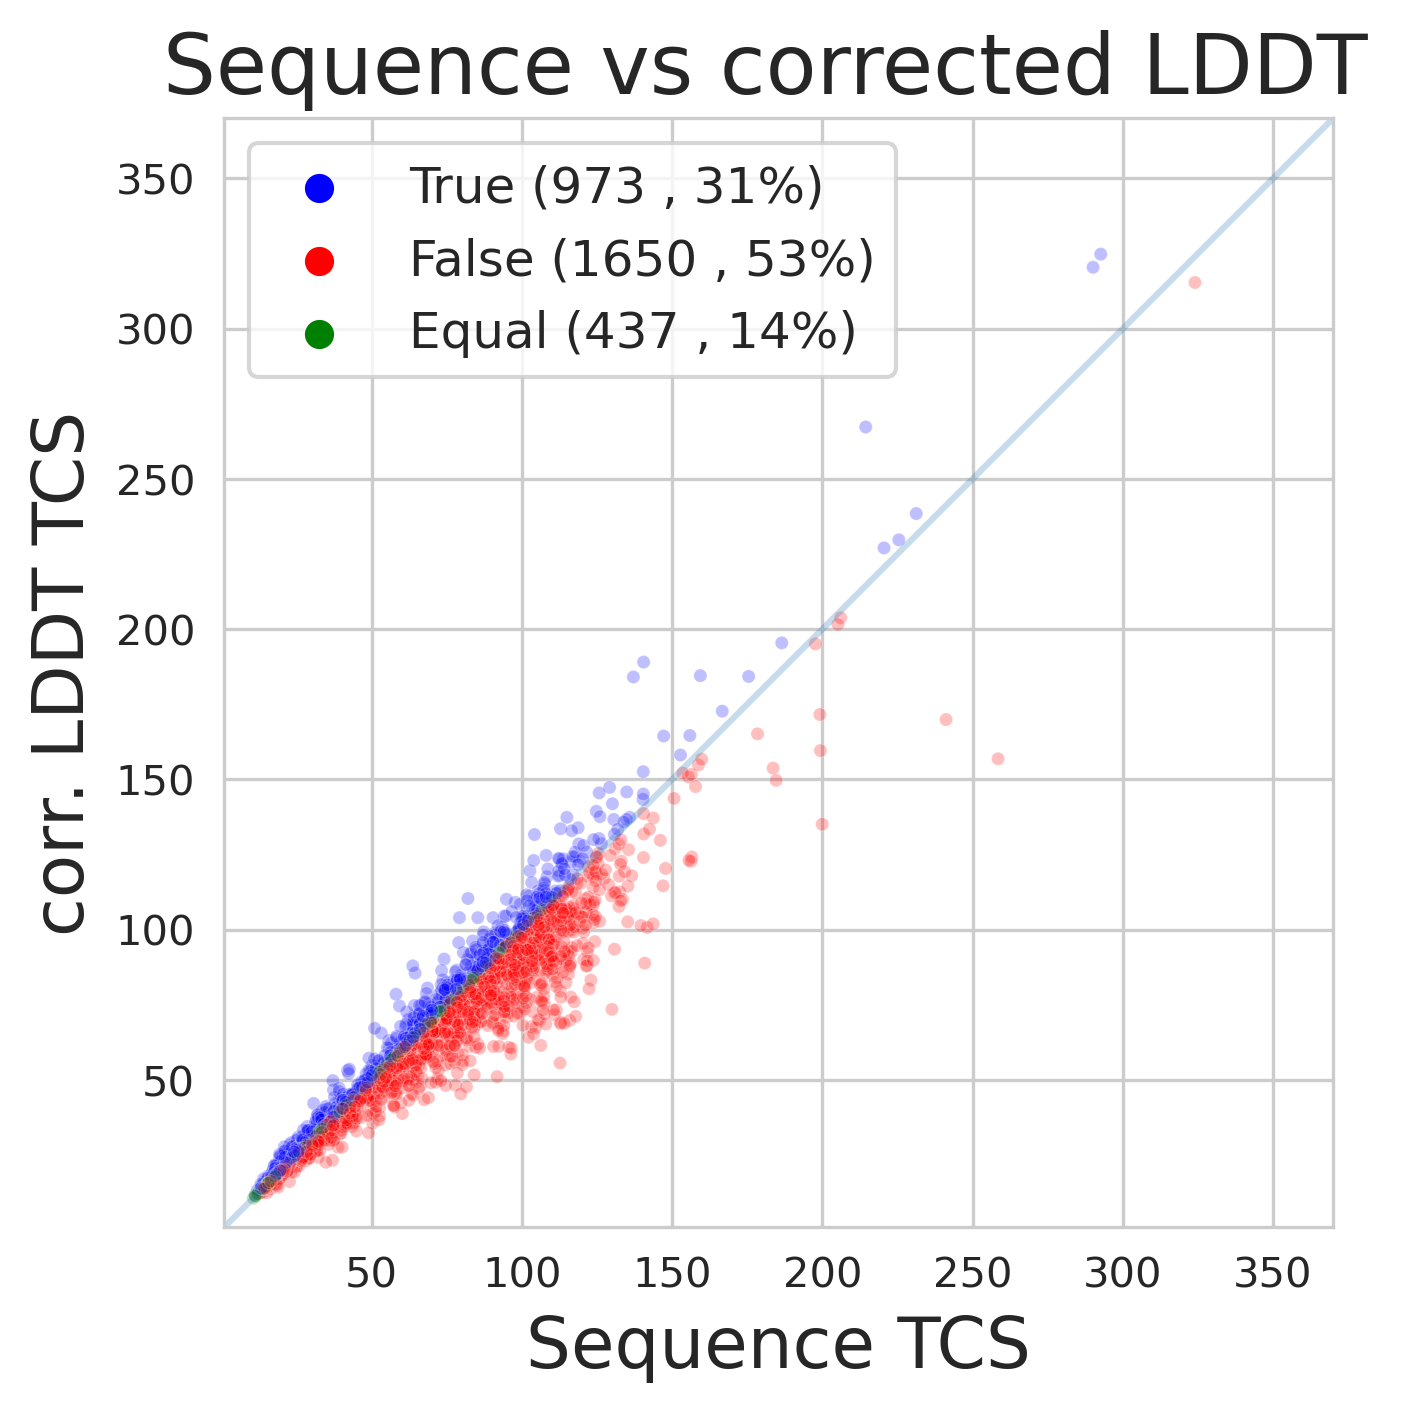

[<matplotlib.collections.PathCollection object at 0x7fa47831a980>, <matplotlib.collections.PathCollection object at 0x7fa47831add0>, <matplotlib.collections.PathCollection object at 0x7fa47817c250>] ['True', 'False', 'Equal']


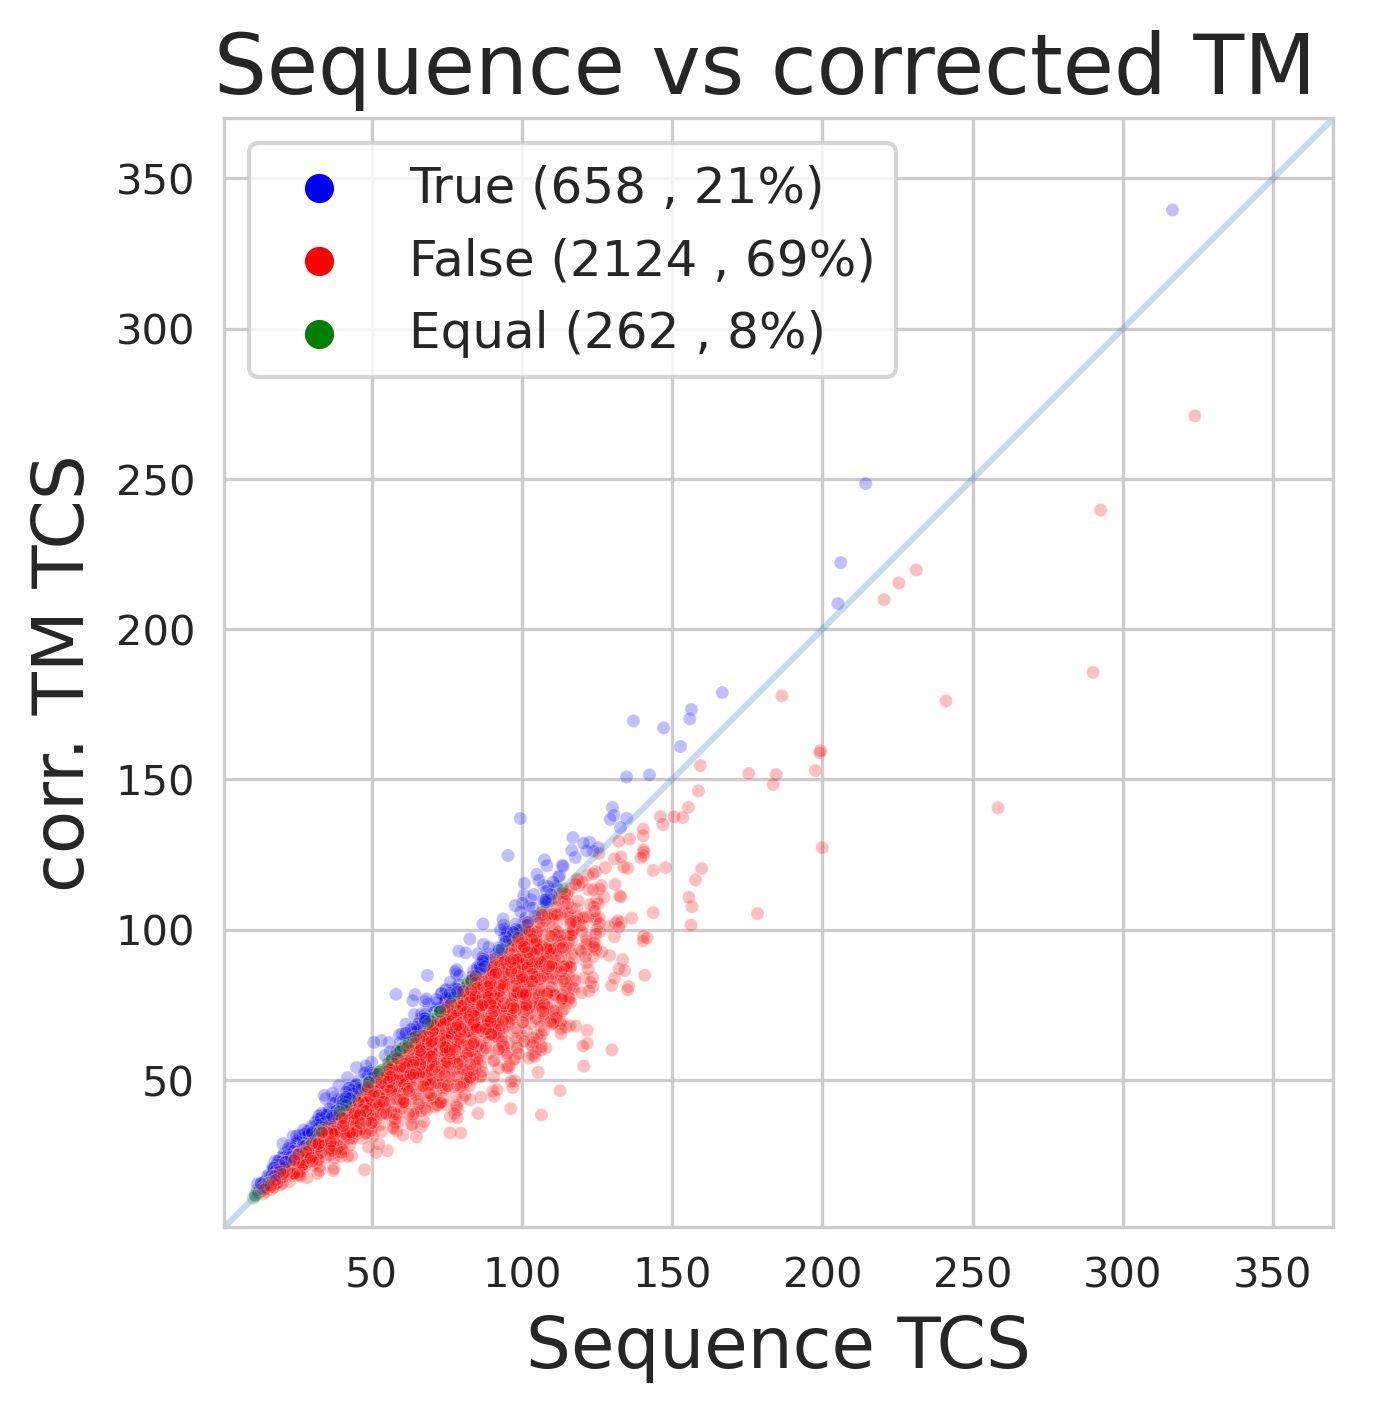

In [16]:
#species tree discordance for cat dataset
retgraph(  'sequences_norm' , 'fident_1_exp_struct_tree_norm' ,  unfiltereddf
         ,'Sequence TCS' ,  'corr. Foldtree TCS',  'Sequence vs corrected Foldtree ')
retgraph(  'sequences_norm' , 'lddt_1_exp_struct_tree_norm' ,  unfiltereddf
         ,'Sequence TCS' ,  'corr. LDDT TCS',  'Sequence vs corrected LDDT ')
retgraph(  'sequences_norm' , 'alntmscore_1_exp_struct_tree_norm' ,  unfiltereddf
         ,'Sequence TCS' ,  'corr. TM TCS',  'Sequence vs corrected TM ')

[<matplotlib.collections.PathCollection object at 0x7fa4782df0d0>, <matplotlib.collections.PathCollection object at 0x7fa4782df520>, <matplotlib.collections.PathCollection object at 0x7fa4782df970>] ['True', 'False', 'Equal']


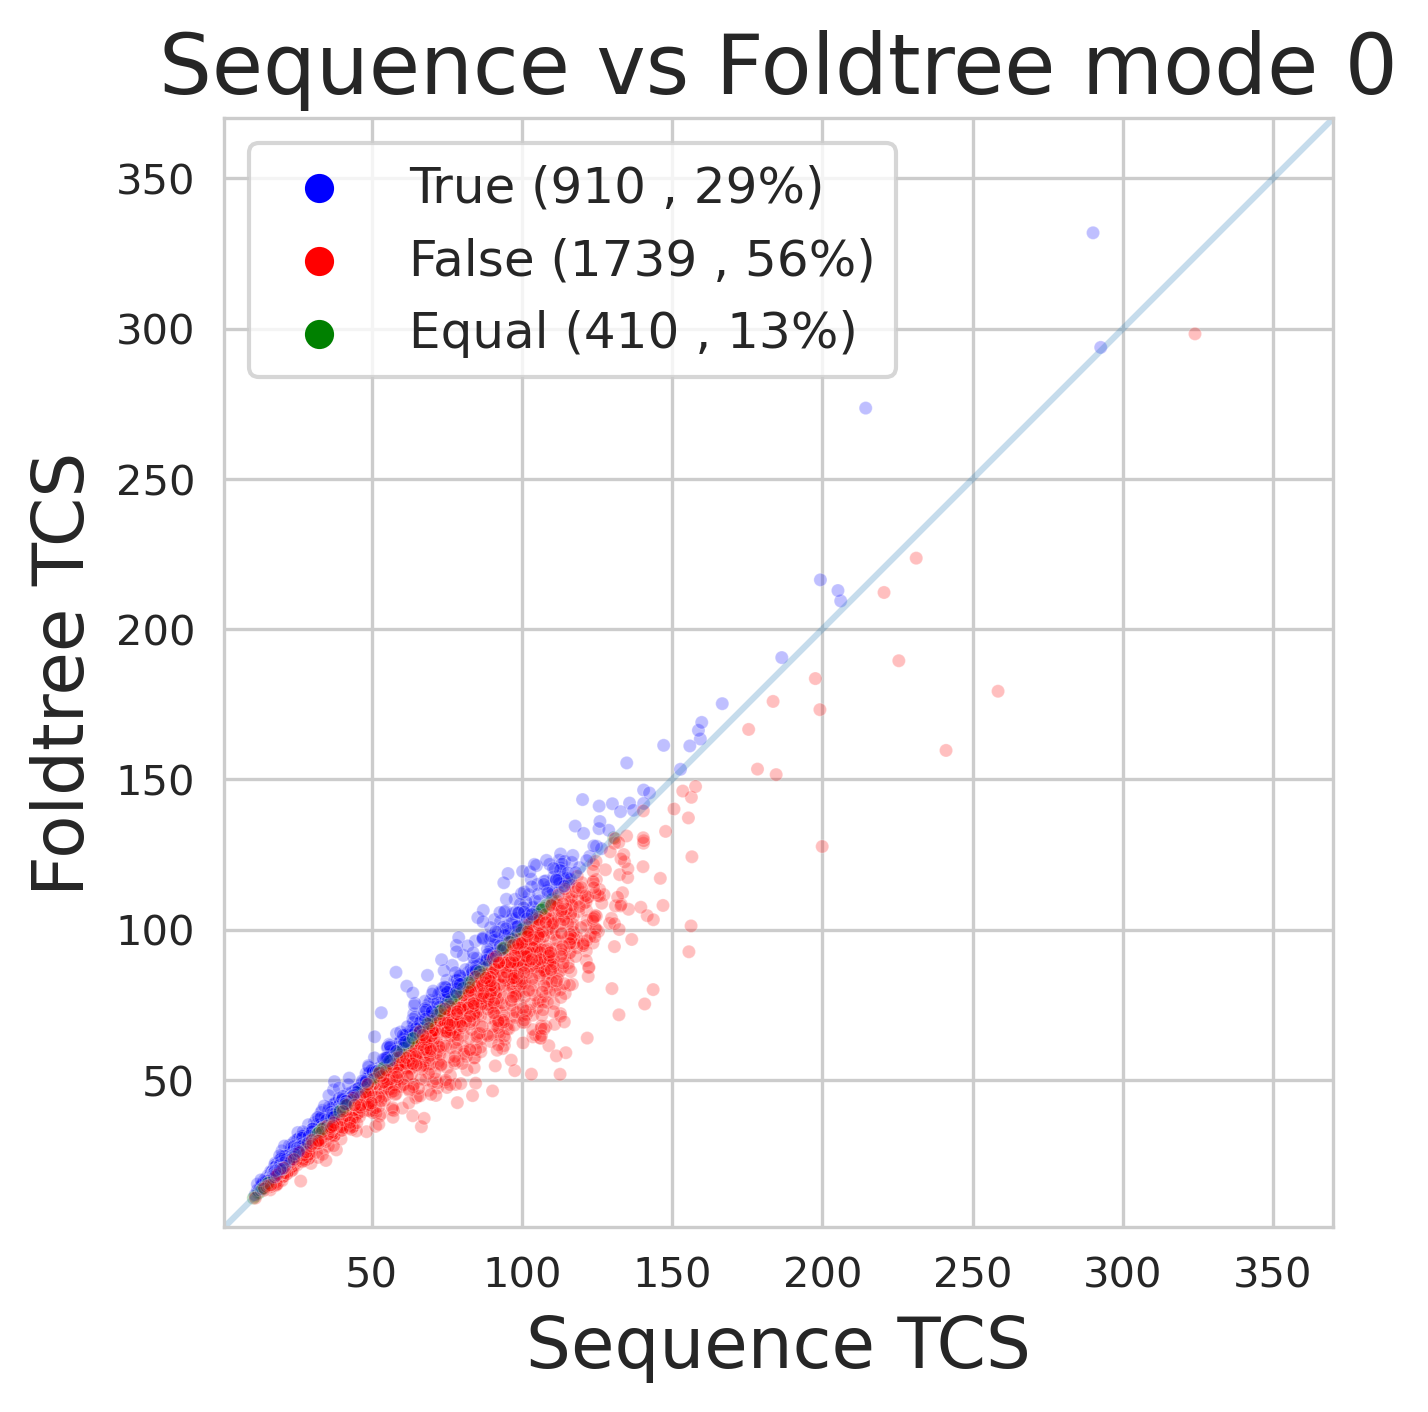

[<matplotlib.collections.PathCollection object at 0x7fa473657fa0>, <matplotlib.collections.PathCollection object at 0x7fa4736577f0>, <matplotlib.collections.PathCollection object at 0x7fa473656e90>] ['True', 'False', 'Equal']


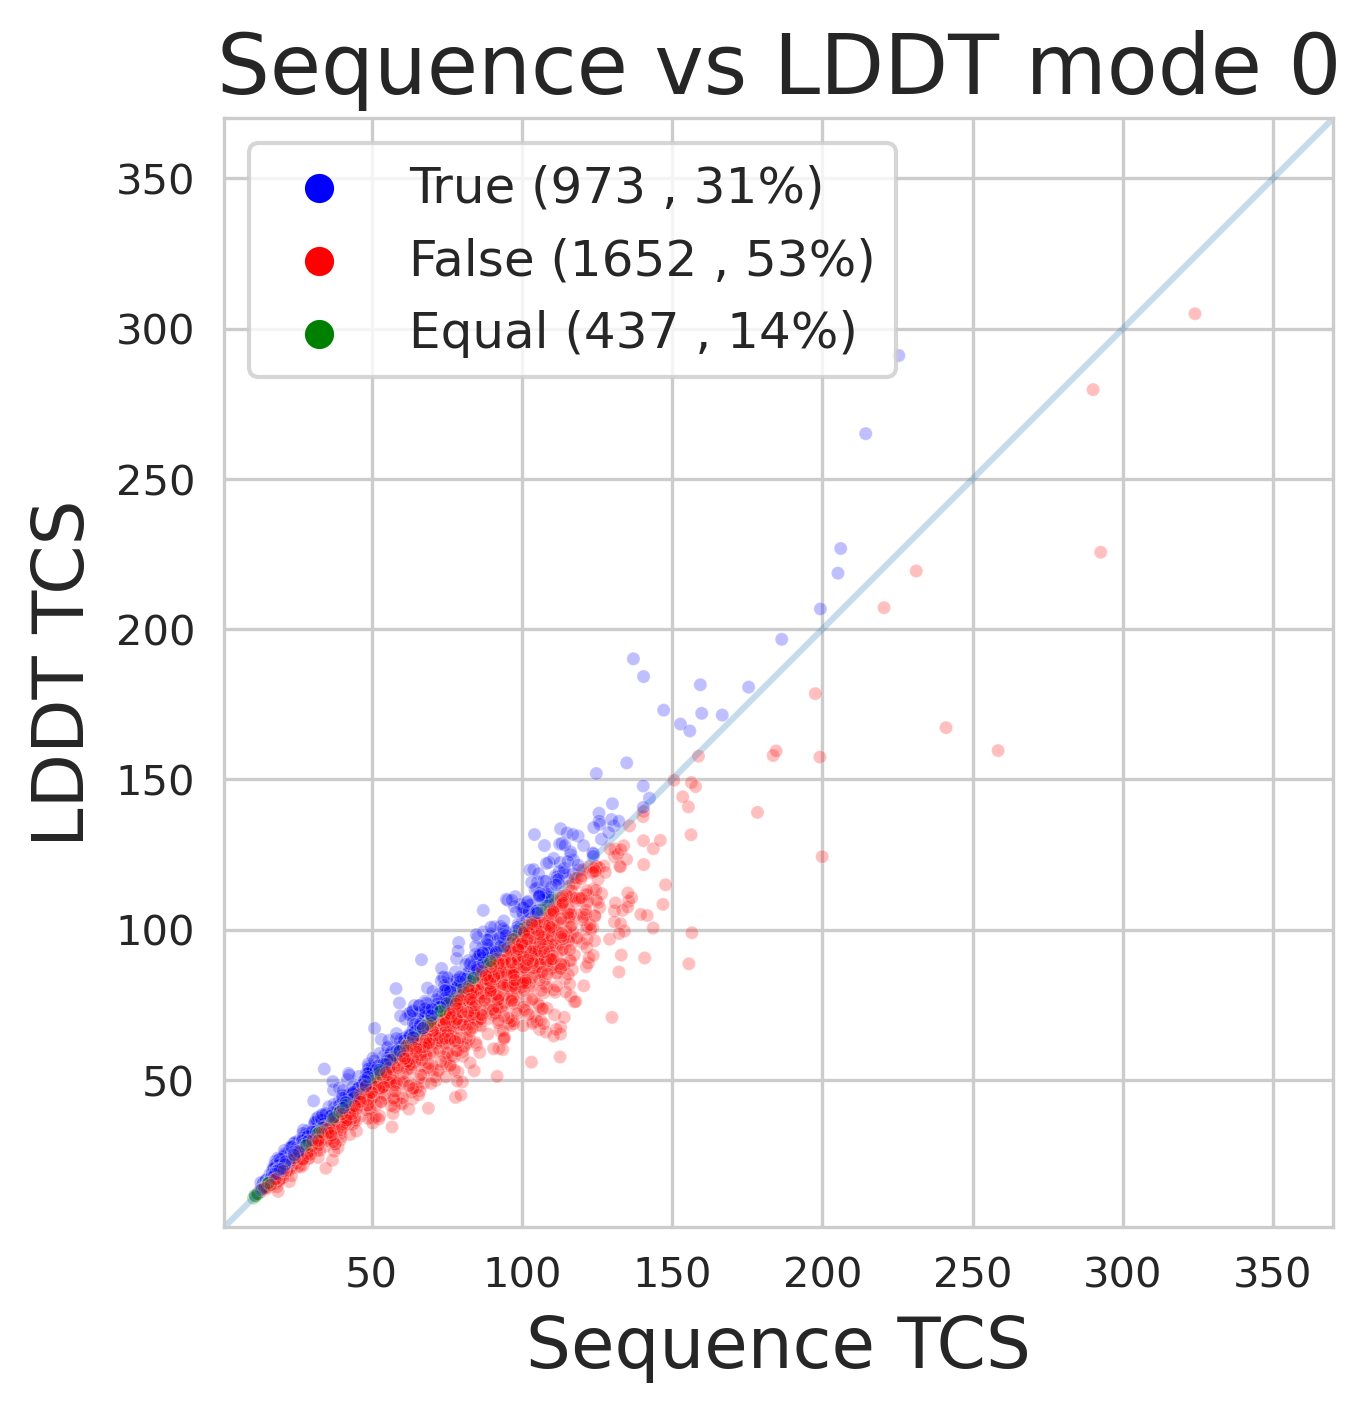

[<matplotlib.collections.PathCollection object at 0x7fa4736fe8c0>, <matplotlib.collections.PathCollection object at 0x7fa4736fed10>, <matplotlib.collections.PathCollection object at 0x7fa4736ff160>] ['True', 'False', 'Equal']


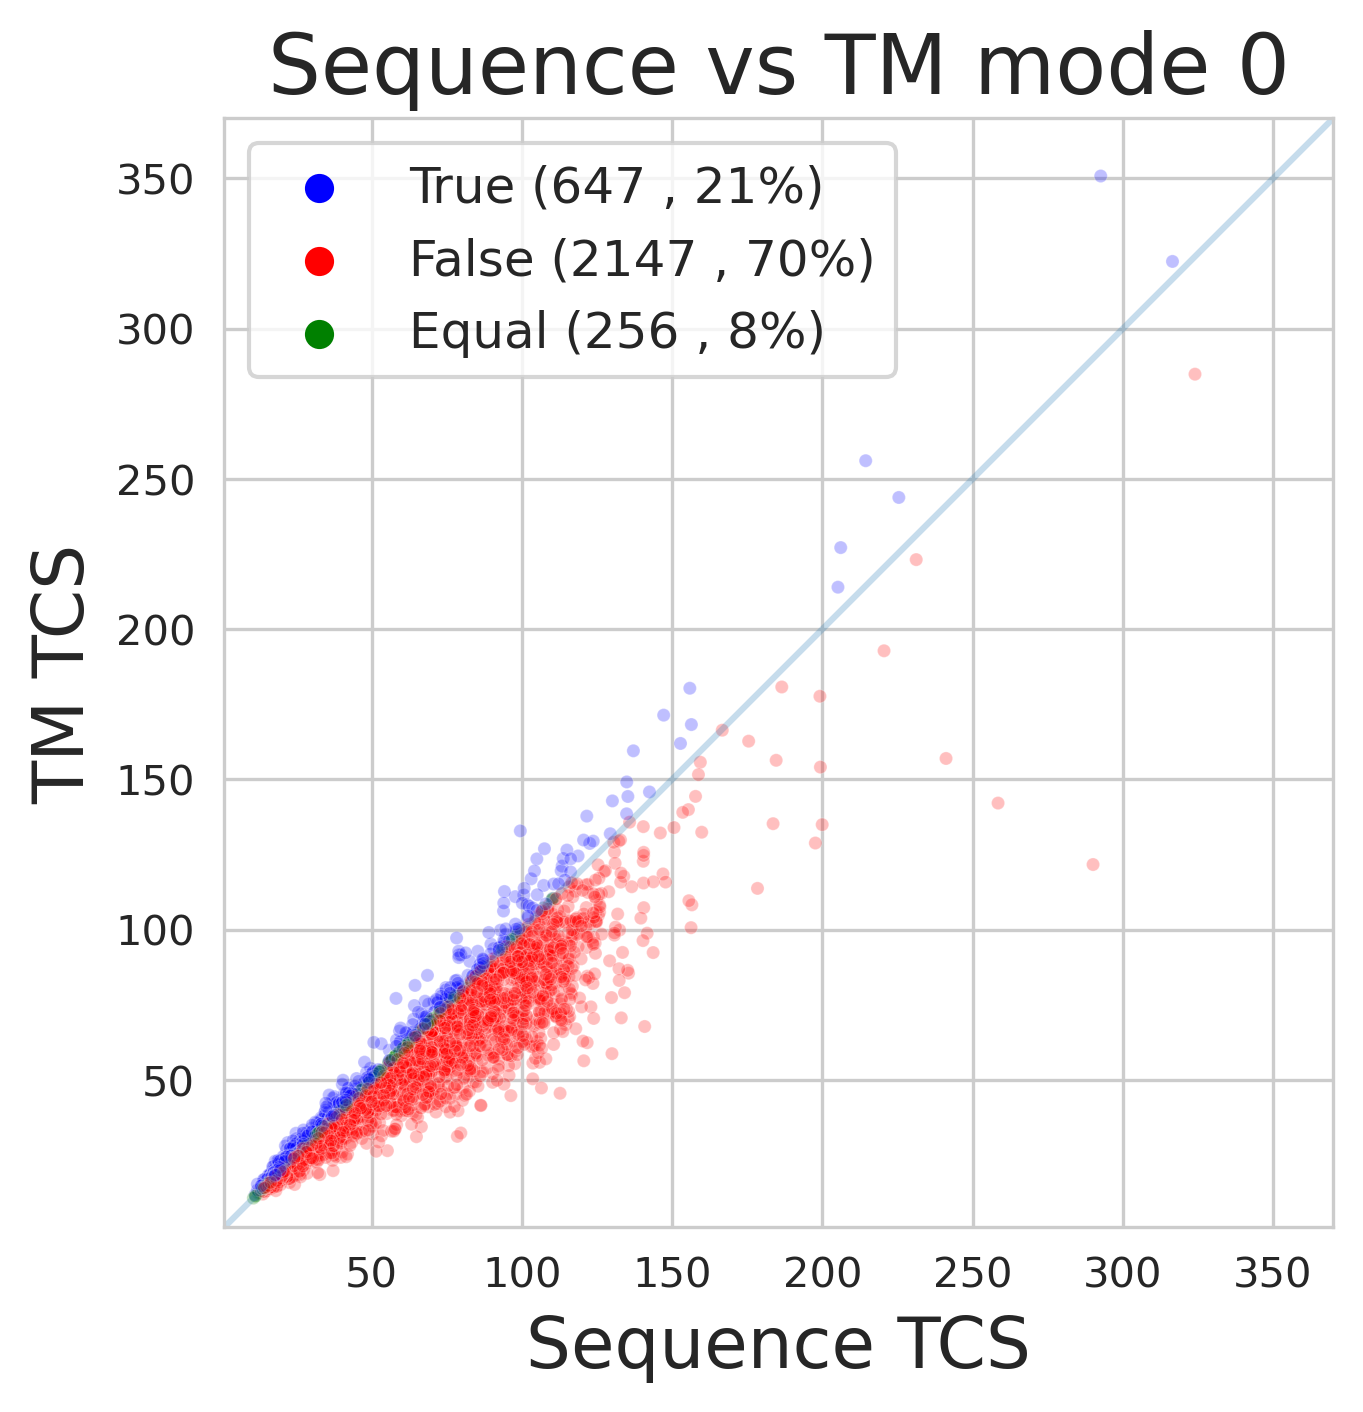

In [17]:
#species tree discordance for cat dataset
retgraph(  'sequences_norm' , 'fident_0_raw_struct_tree_norm' ,  unfiltereddf
         ,'Sequence TCS' ,  'Foldtree TCS',  'Sequence vs Foldtree mode 0')
retgraph(  'sequences_norm' , 'lddt_0_raw_struct_tree_norm' ,  unfiltereddf
         ,'Sequence TCS' ,  'LDDT TCS',  'Sequence vs LDDT mode 0')
retgraph(  'sequences_norm' , 'alntmscore_0_raw_struct_tree_norm' ,  unfiltereddf
         ,'Sequence TCS' ,  'TM TCS',  'Sequence vs TM mode 0')

['Eukaryota' 'Euteleostomi' 'Fungi' 'Opisthokonta' 'Bilateria' 'Tetrapoda'
 'Chordata' 'Eumetazoa' 'Bacteria' 'Dikarya' 'LUCA']
[<matplotlib.collections.PathCollection object at 0x7fa473655b70>, <matplotlib.collections.PathCollection object at 0x7fa473601090>, <matplotlib.collections.PathCollection object at 0x7fa4736001c0>] ['False', 'True', 'Equal']


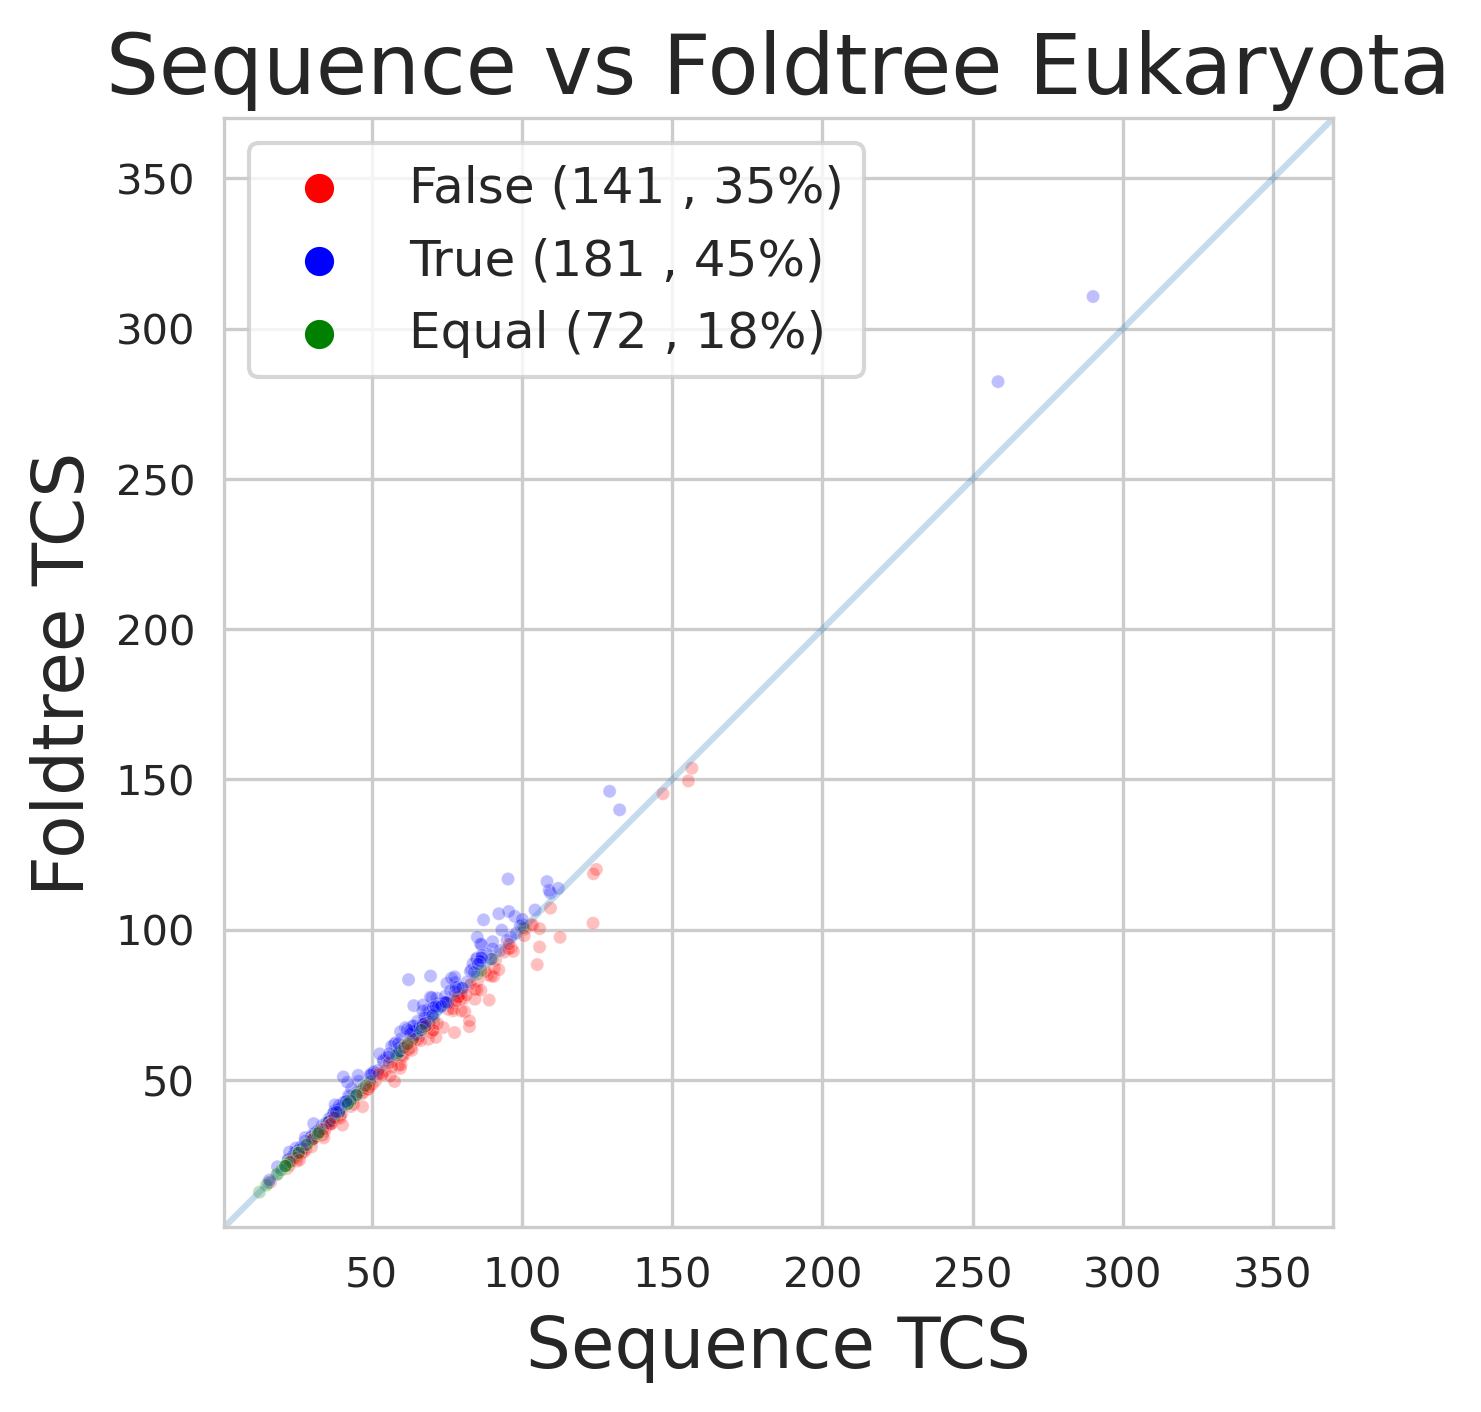

[<matplotlib.collections.PathCollection object at 0x7fa47817d540>, <matplotlib.collections.PathCollection object at 0x7fa47817fe20>, <matplotlib.collections.PathCollection object at 0x7fa47811e020>] ['False', 'Equal', 'True']


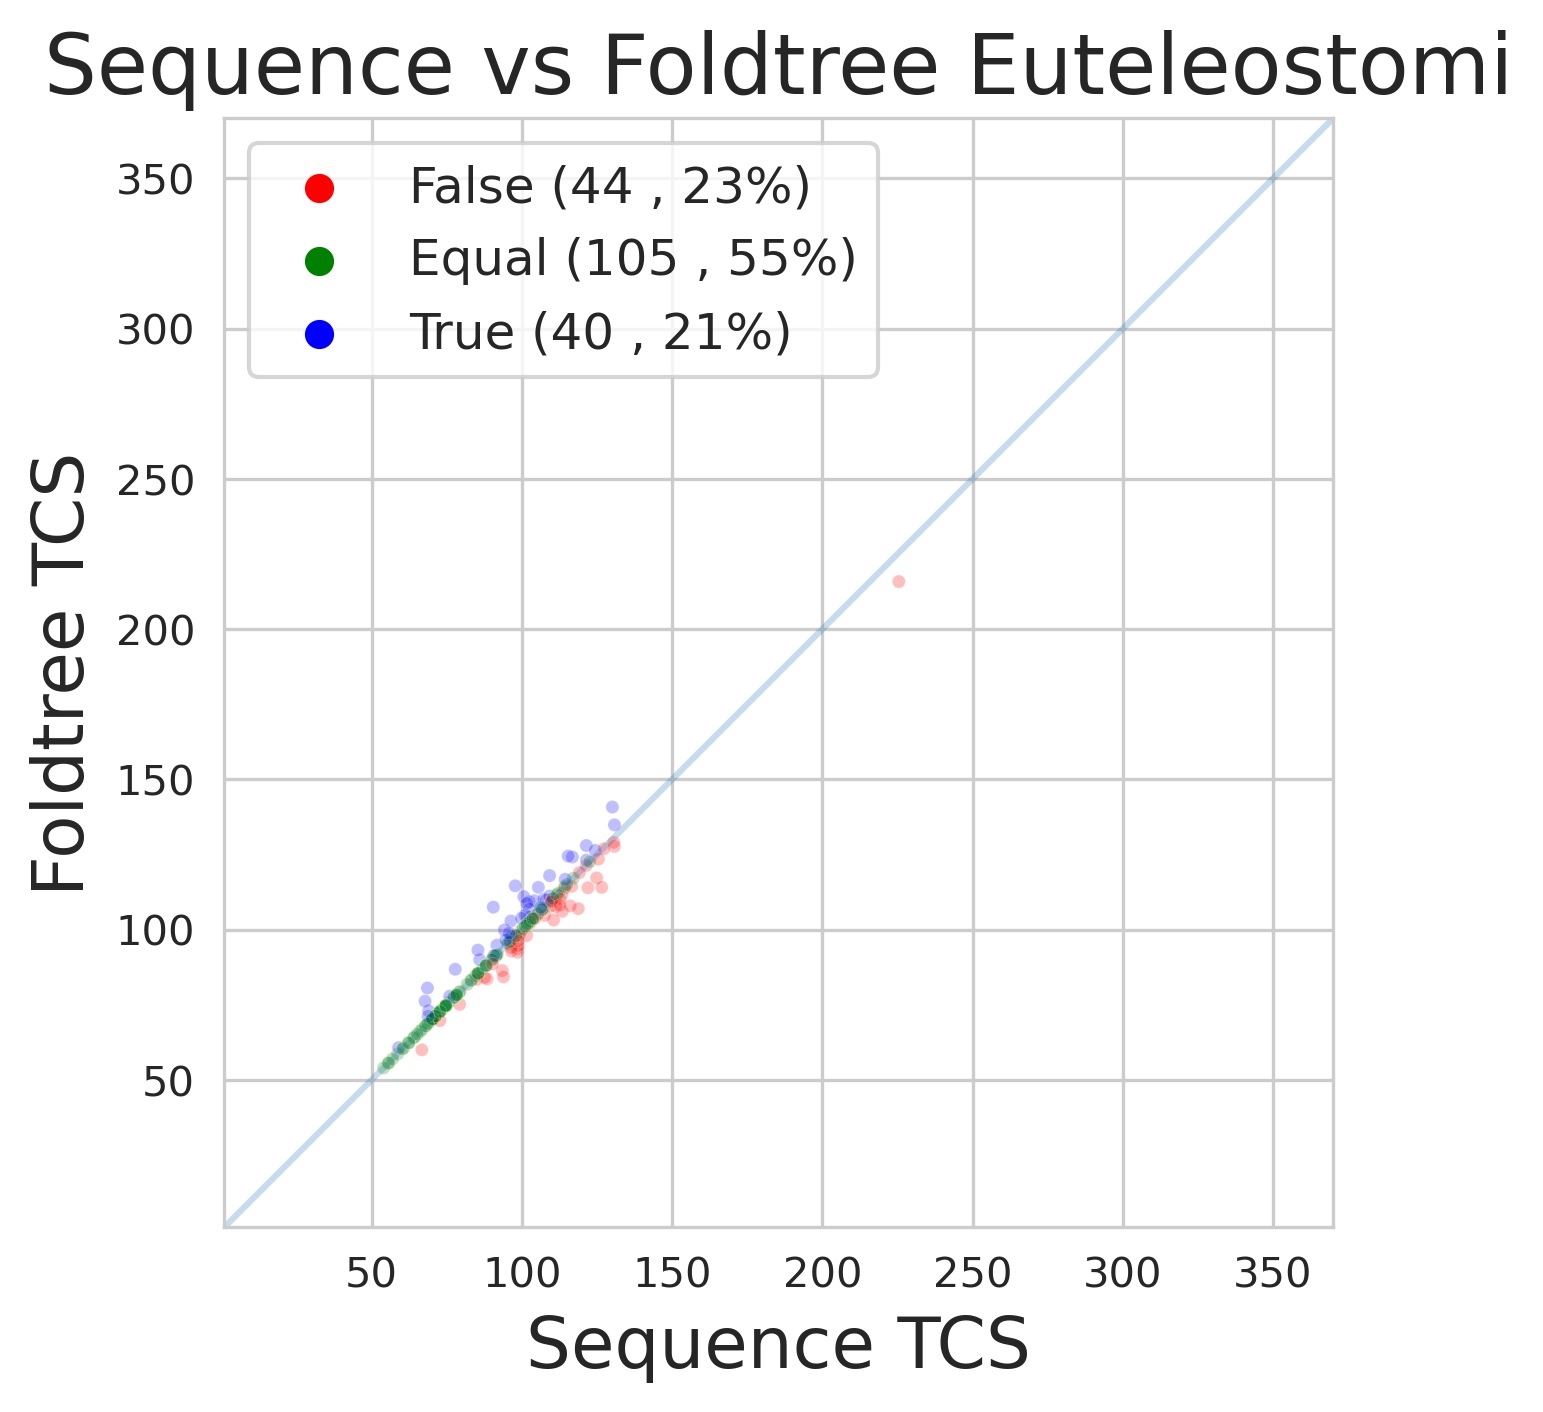

[<matplotlib.collections.PathCollection object at 0x7fa47c2bc640>, <matplotlib.collections.PathCollection object at 0x7fa47c21bbe0>, <matplotlib.collections.PathCollection object at 0x7fa479633f40>] ['Equal', 'True', 'False']


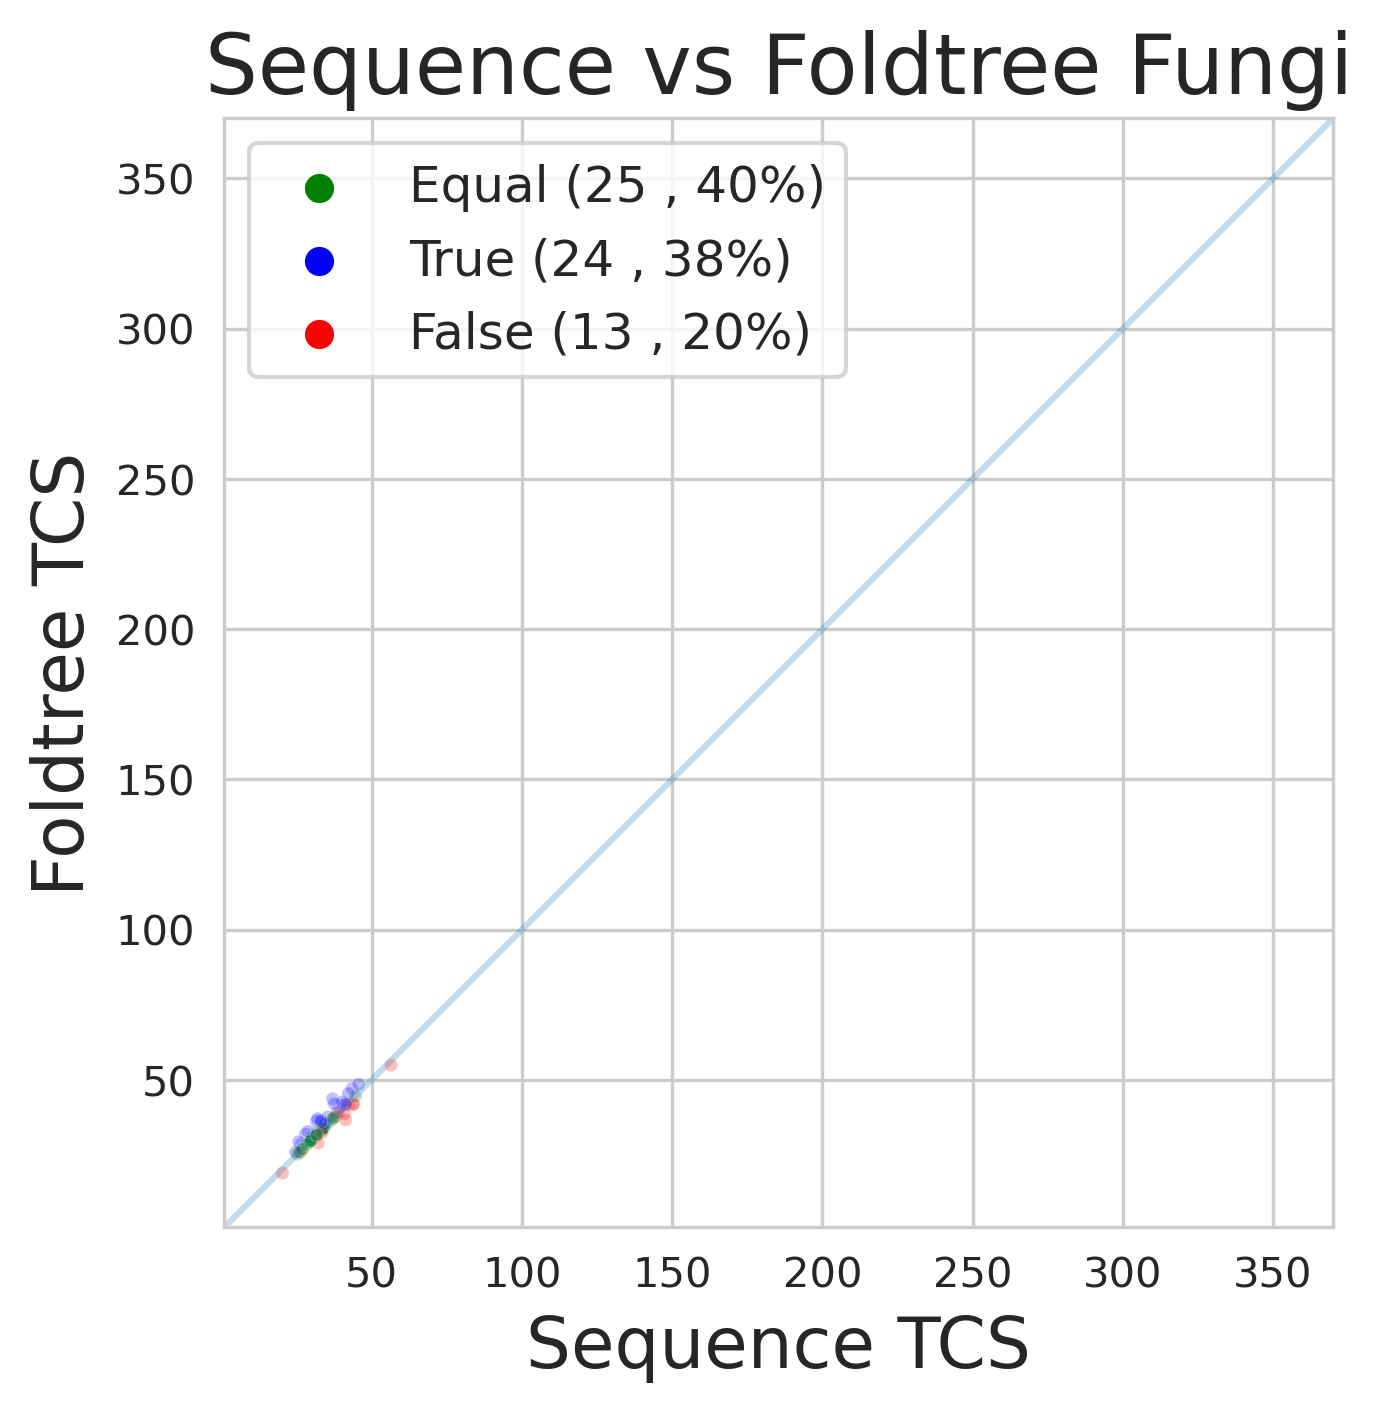

[<matplotlib.collections.PathCollection object at 0x7fa47900e7d0>, <matplotlib.collections.PathCollection object at 0x7fa47b926a40>, <matplotlib.collections.PathCollection object at 0x7fa47900feb0>] ['False', 'True', 'Equal']


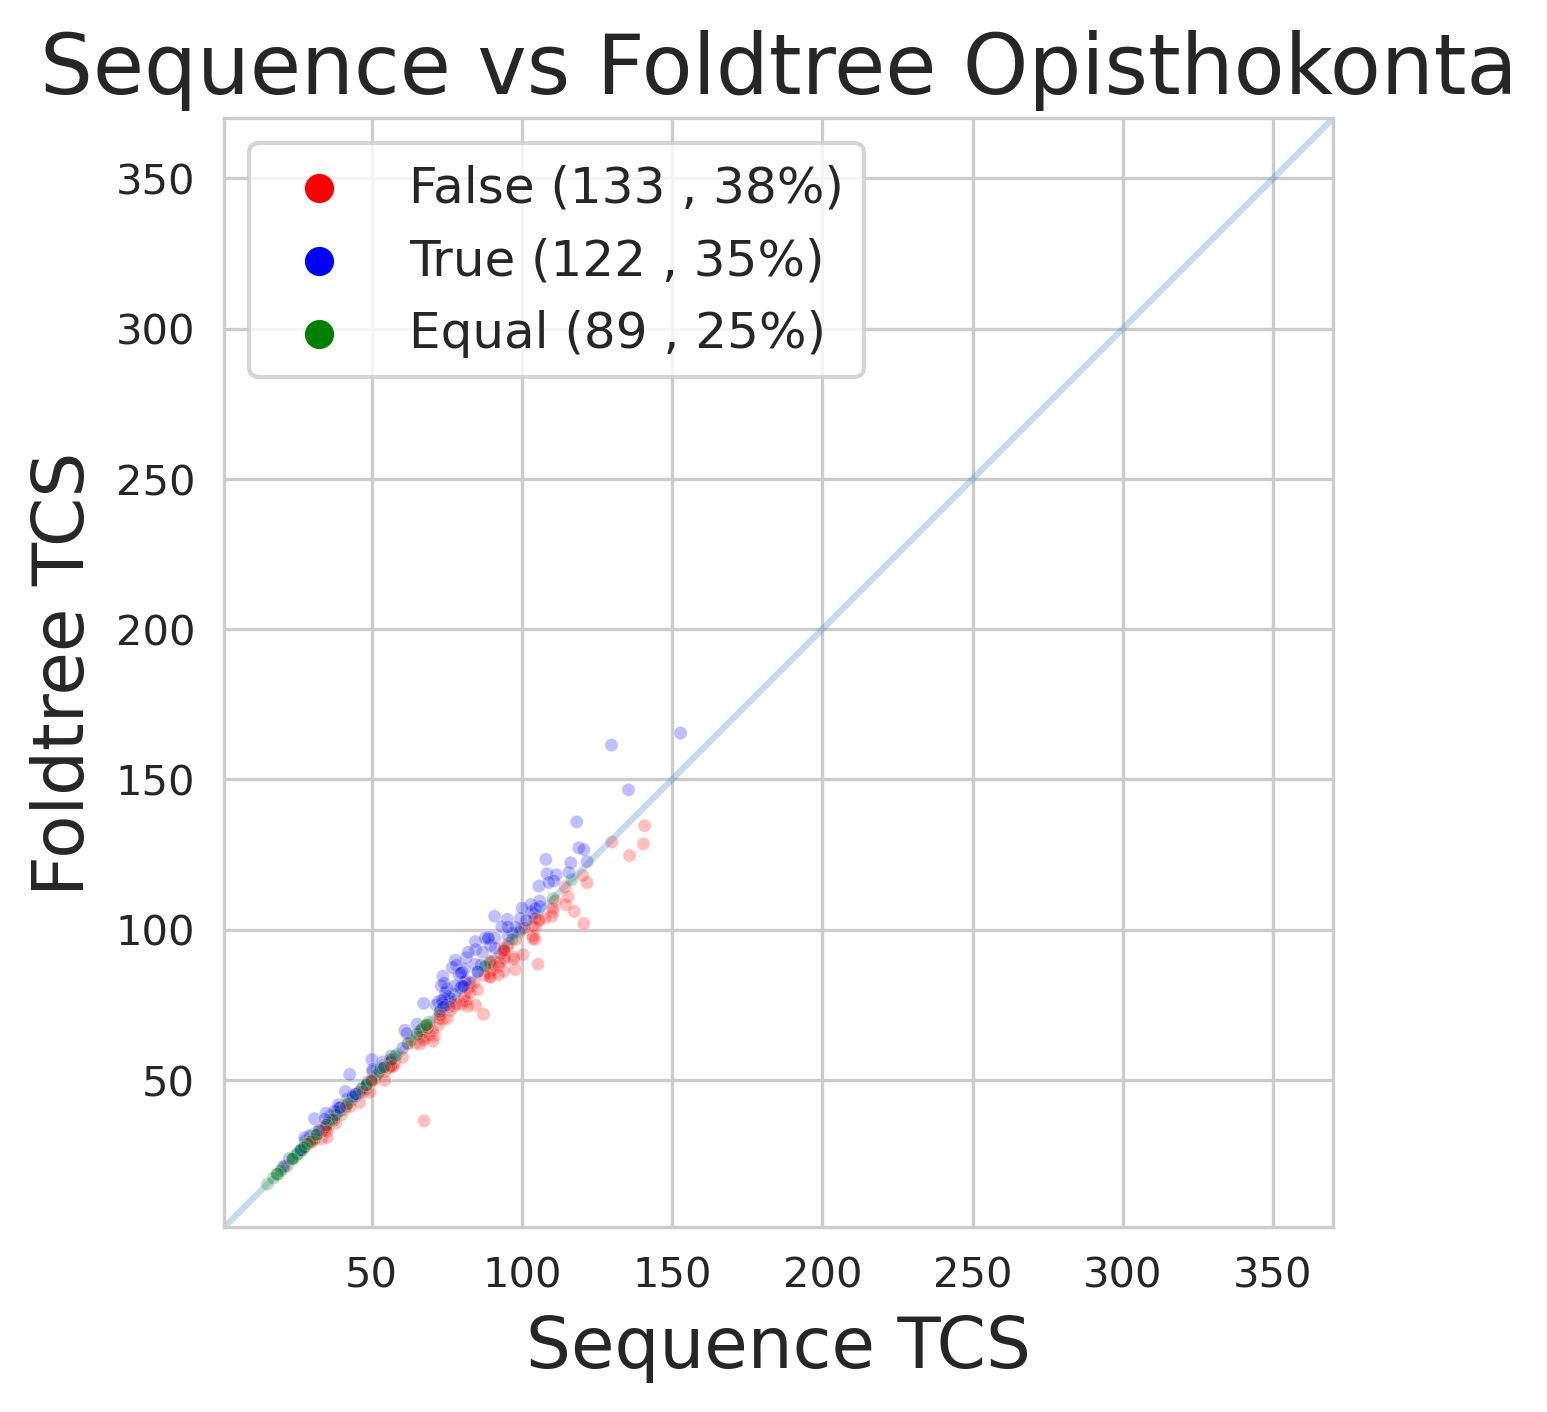

[<matplotlib.collections.PathCollection object at 0x7fa4793da5c0>, <matplotlib.collections.PathCollection object at 0x7fa478e7f430>, <matplotlib.collections.PathCollection object at 0x7fa47949e170>] ['False', 'True', 'Equal']


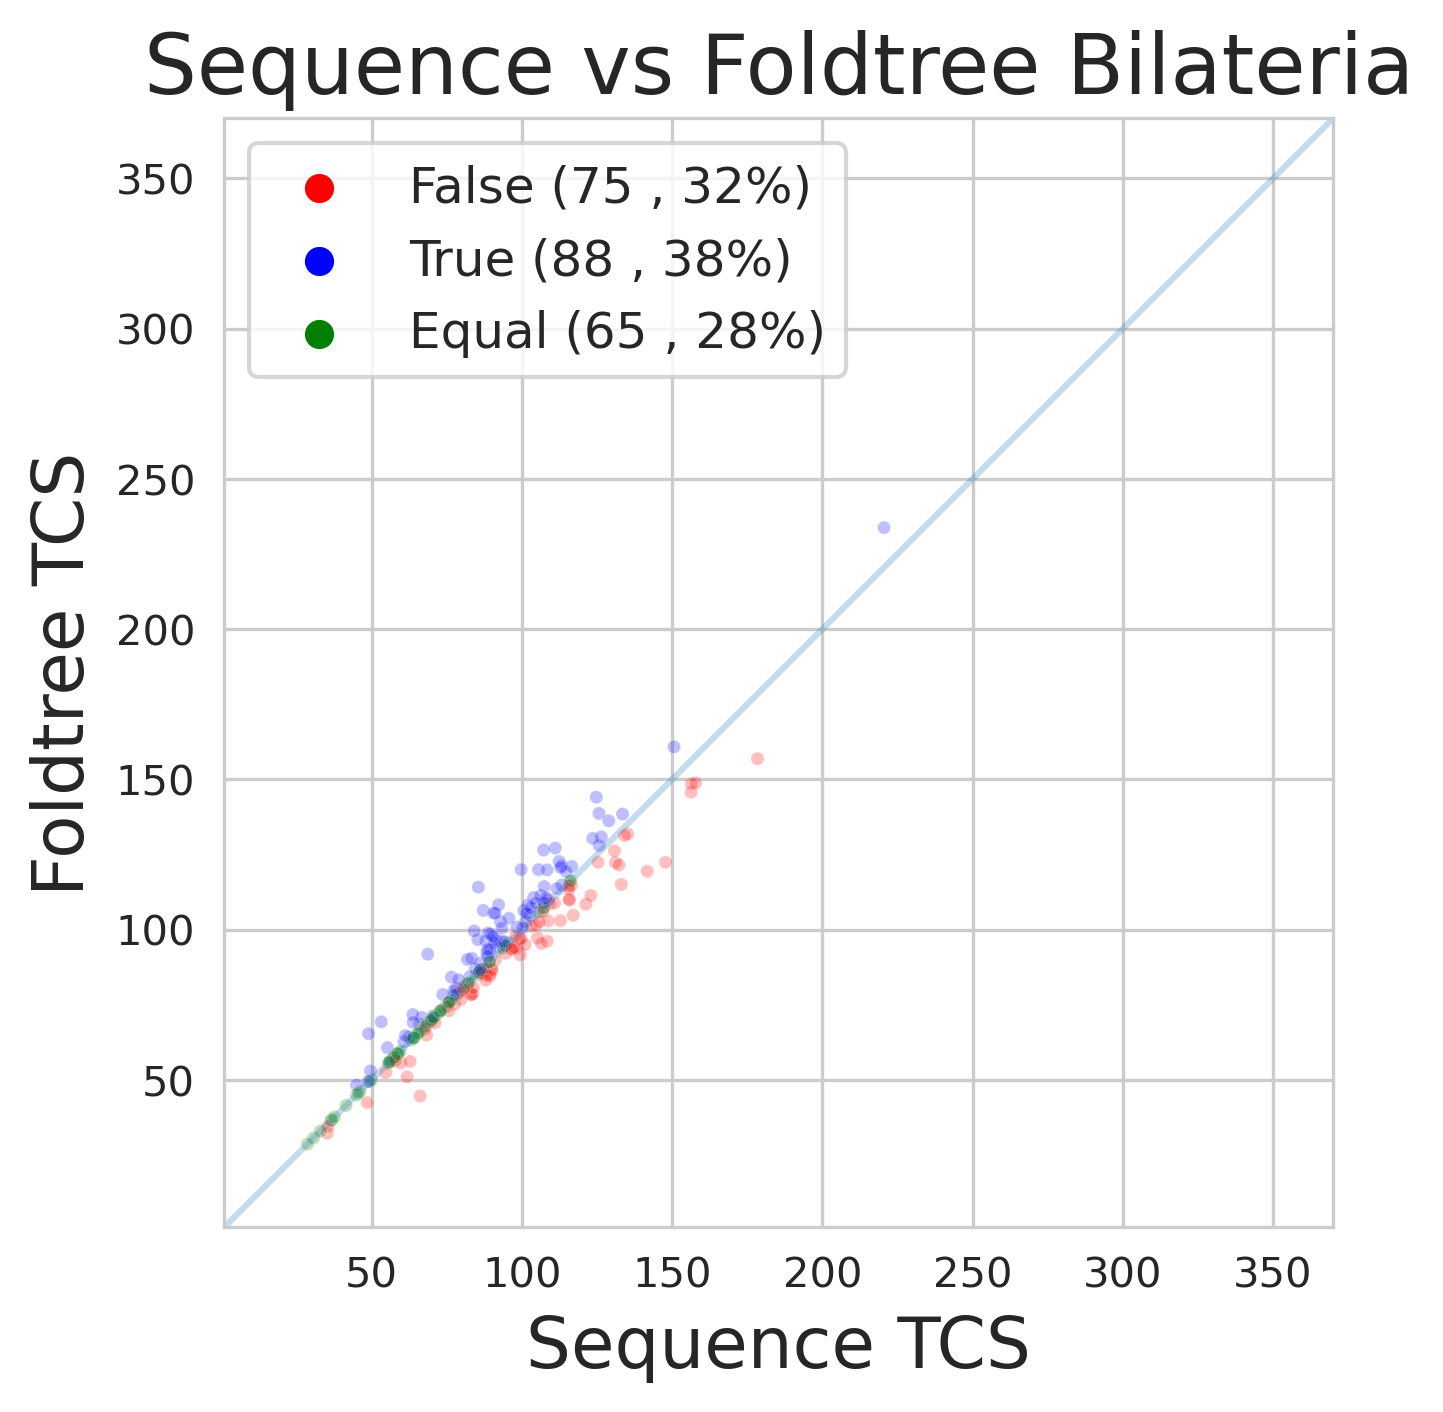

[<matplotlib.collections.PathCollection object at 0x7fa4781988e0>, <matplotlib.collections.PathCollection object at 0x7fa47819b8b0>, <matplotlib.collections.PathCollection object at 0x7fa47819bb50>] ['Equal', 'False', 'True']


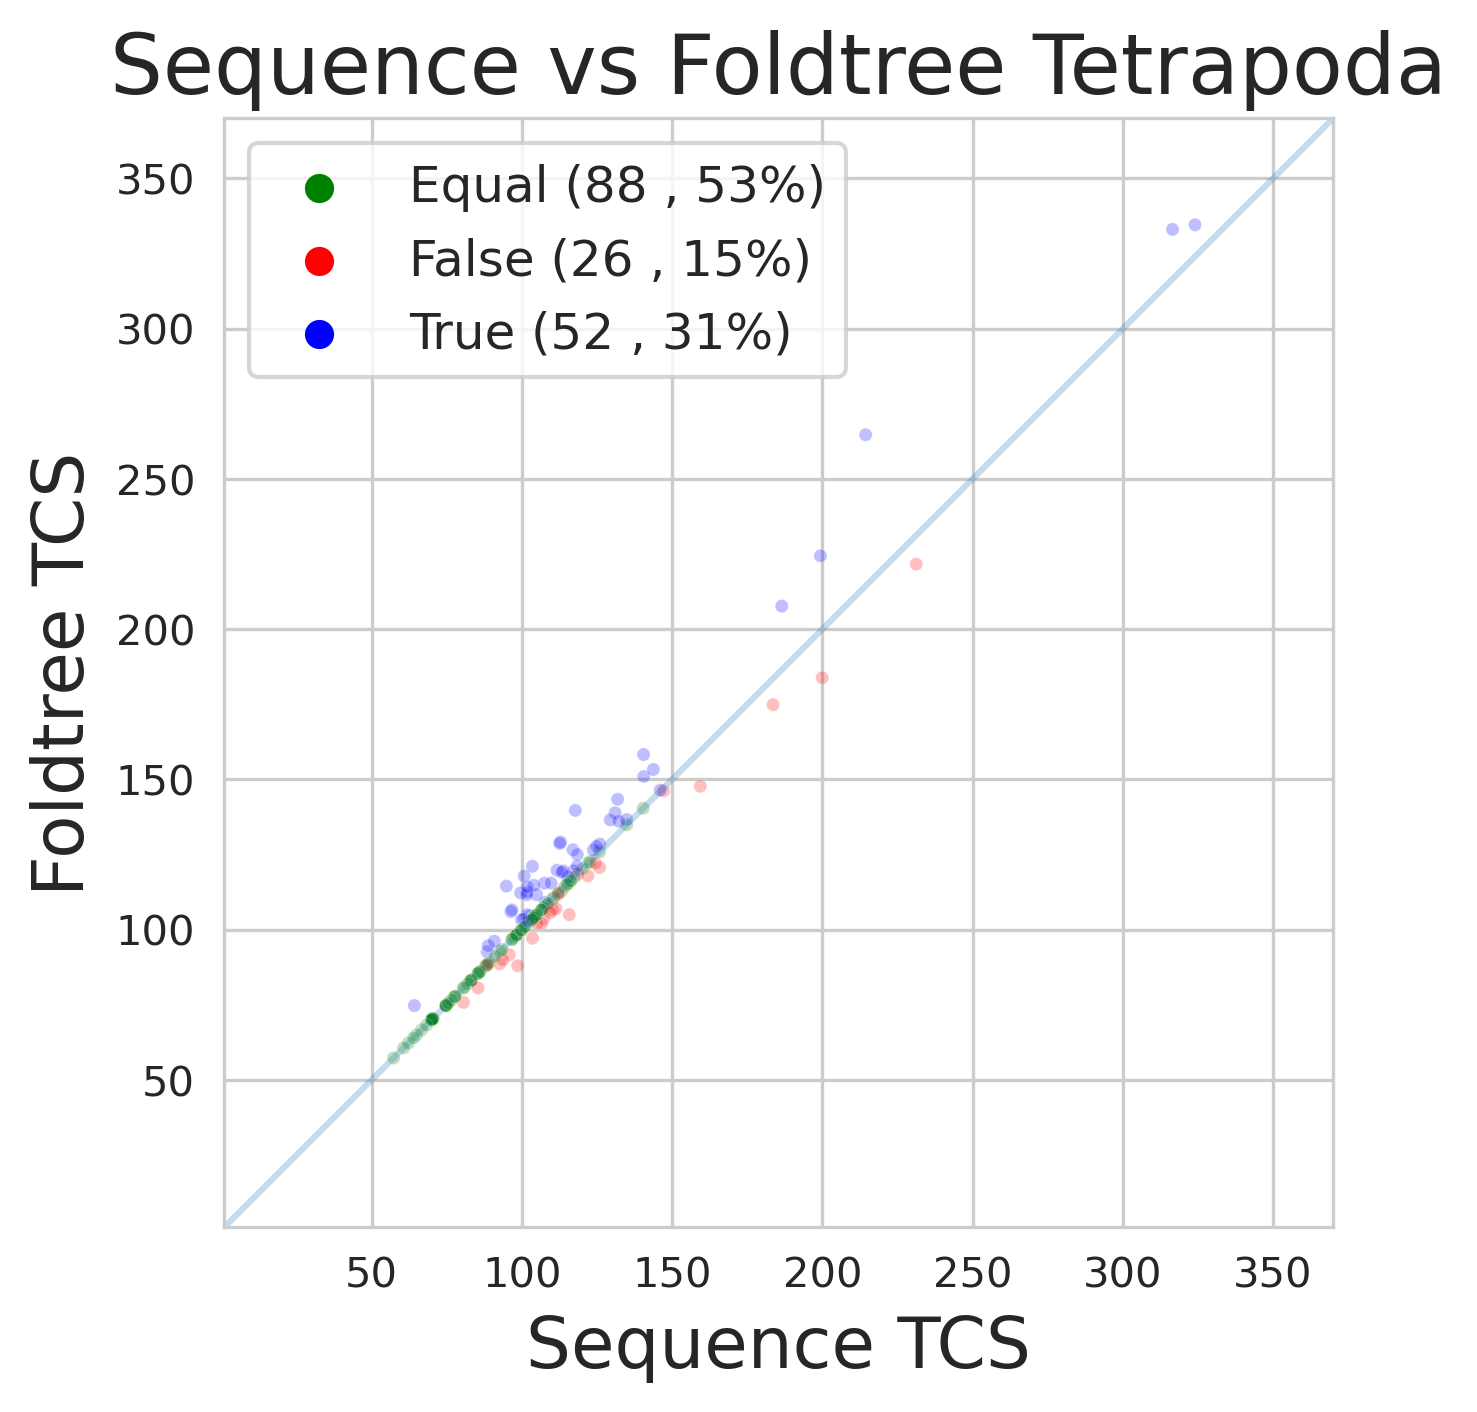

[<matplotlib.collections.PathCollection object at 0x7fa47b93e1a0>, <matplotlib.collections.PathCollection object at 0x7fa47b93fa90>, <matplotlib.collections.PathCollection object at 0x7fa47b93c8b0>] ['True', 'Equal', 'False']


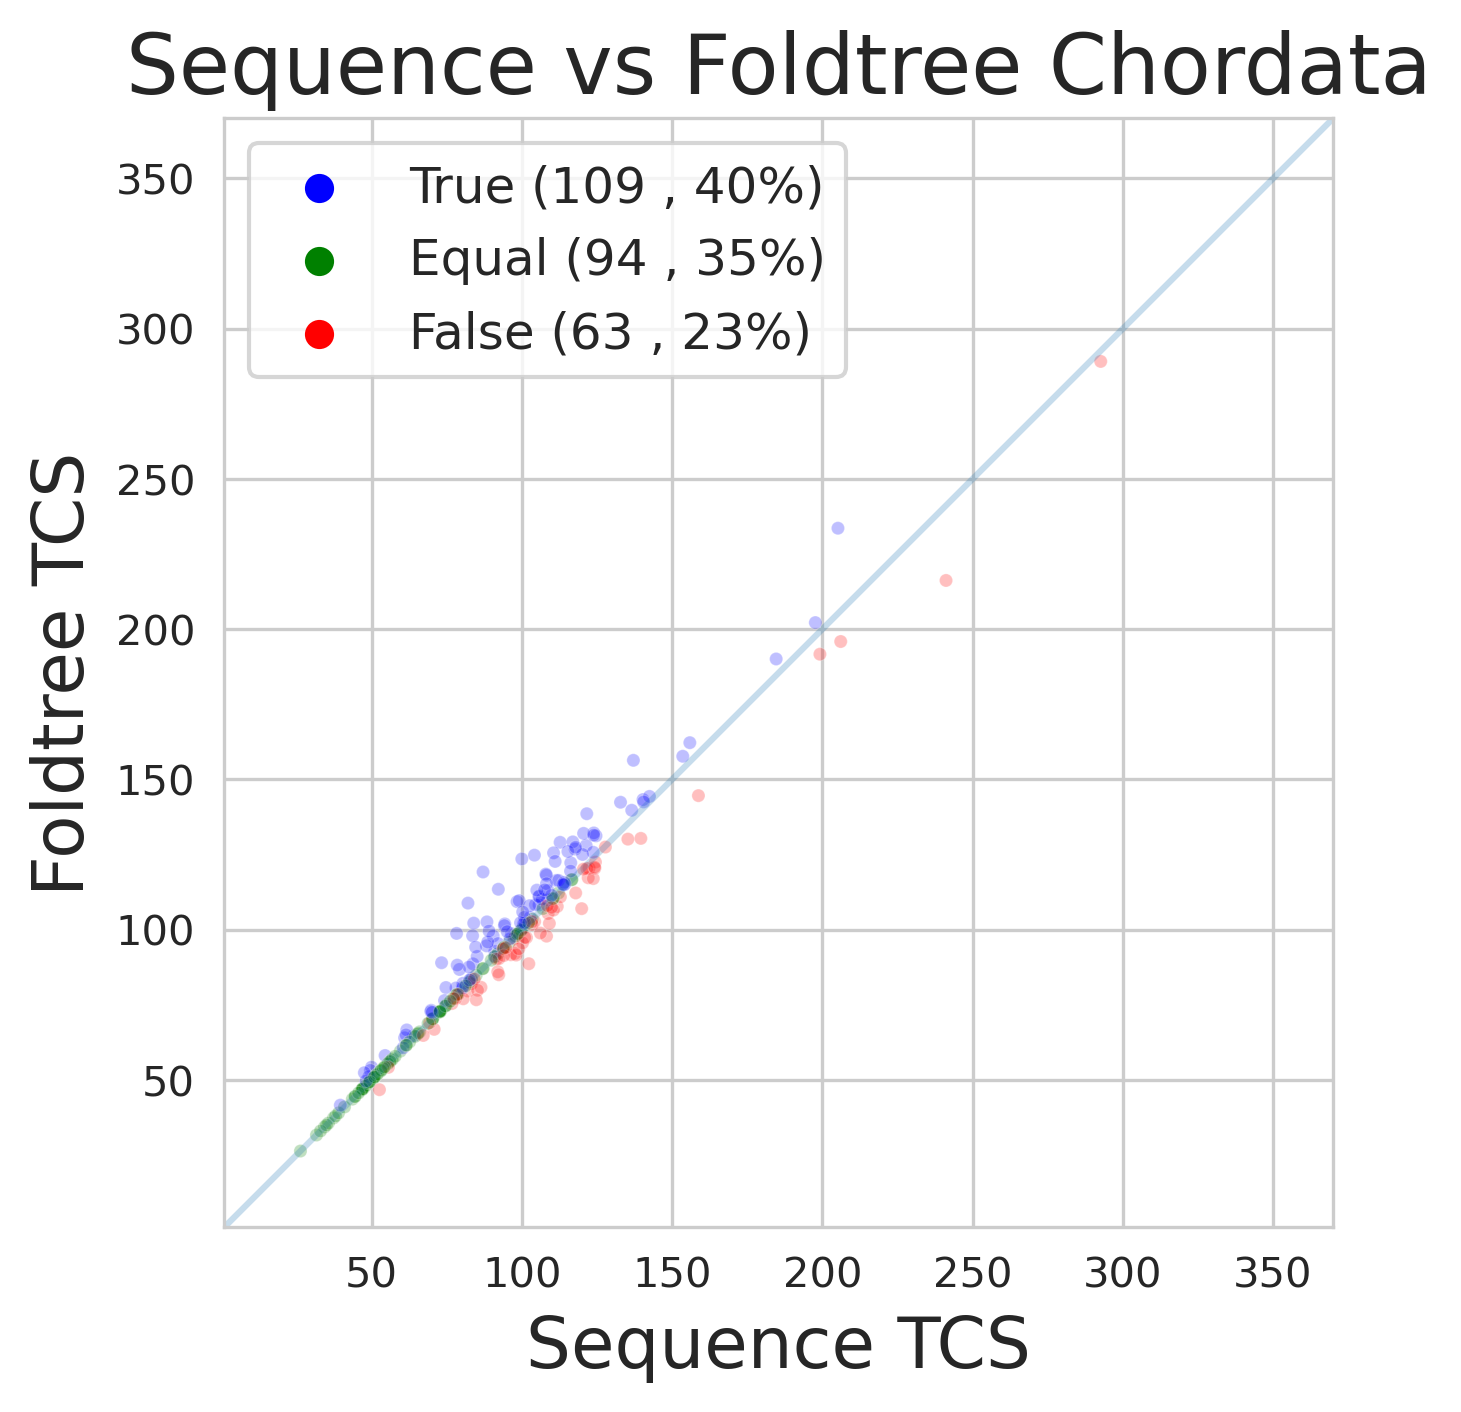

[<matplotlib.collections.PathCollection object at 0x7fa47b93c280>, <matplotlib.collections.PathCollection object at 0x7fa47b93d300>, <matplotlib.collections.PathCollection object at 0x7fa4780f93f0>] ['Equal', 'True', 'False']


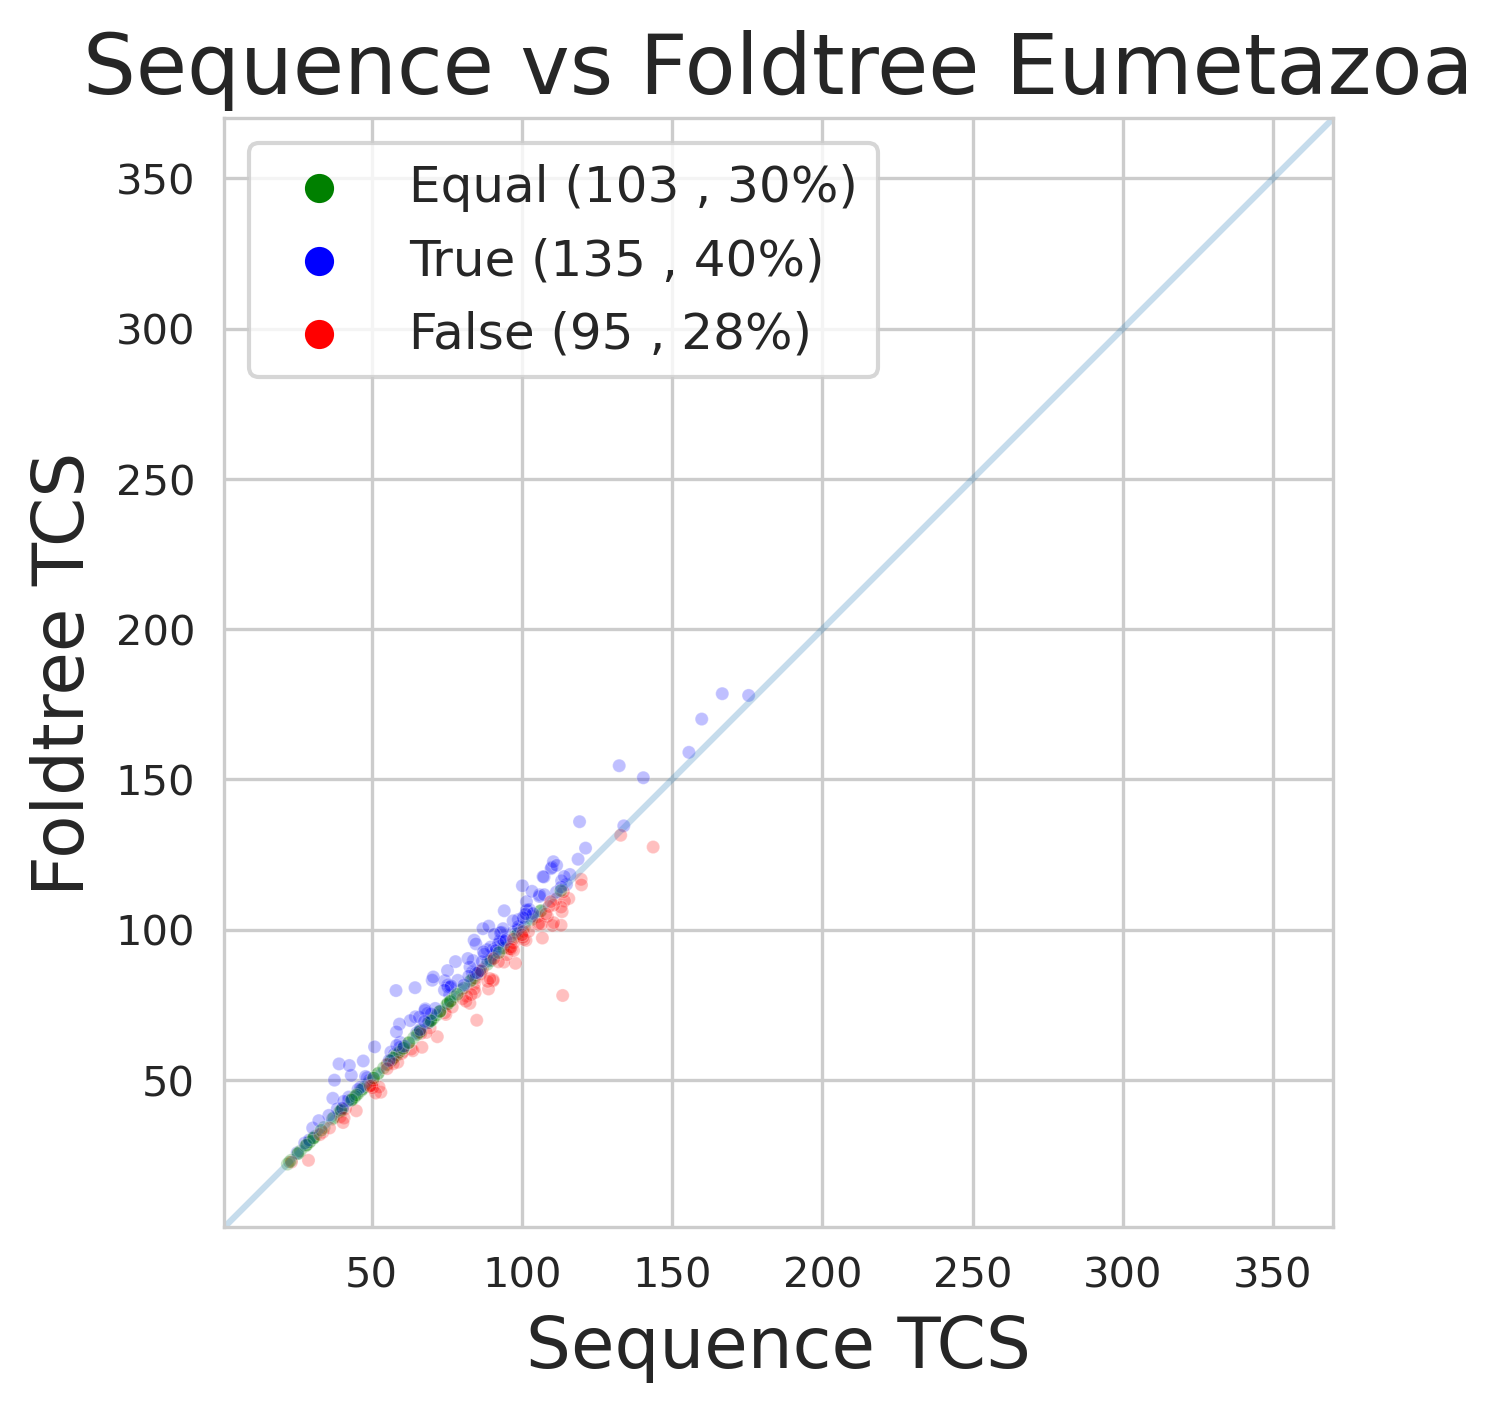

[<matplotlib.collections.PathCollection object at 0x7fa478d171c0>, <matplotlib.collections.PathCollection object at 0x7fa478d14850>, <matplotlib.collections.PathCollection object at 0x7fa478d04070>] ['True', 'False', 'Equal']


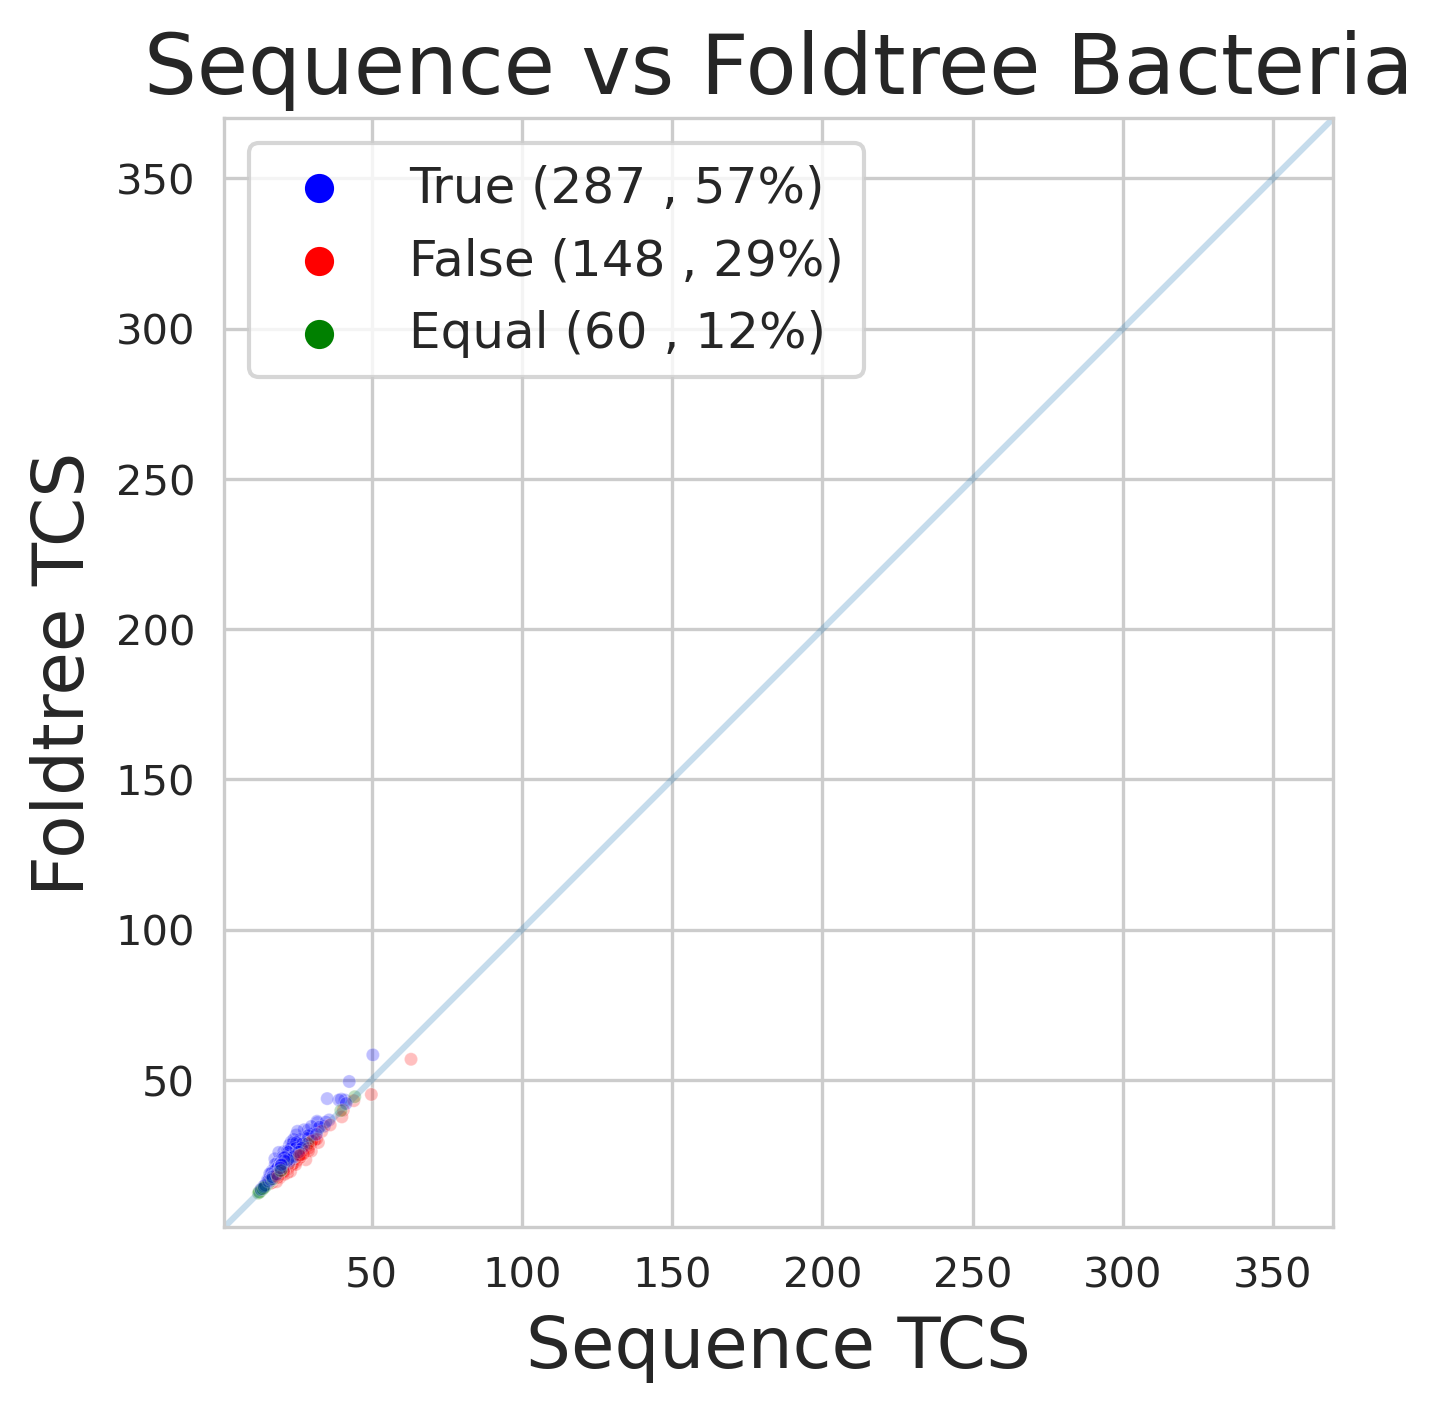

[<matplotlib.collections.PathCollection object at 0x7fa478f1ce80>, <matplotlib.collections.PathCollection object at 0x7fa478f73610>, <matplotlib.collections.PathCollection object at 0x7fa478f72800>] ['True', 'Equal', 'False']


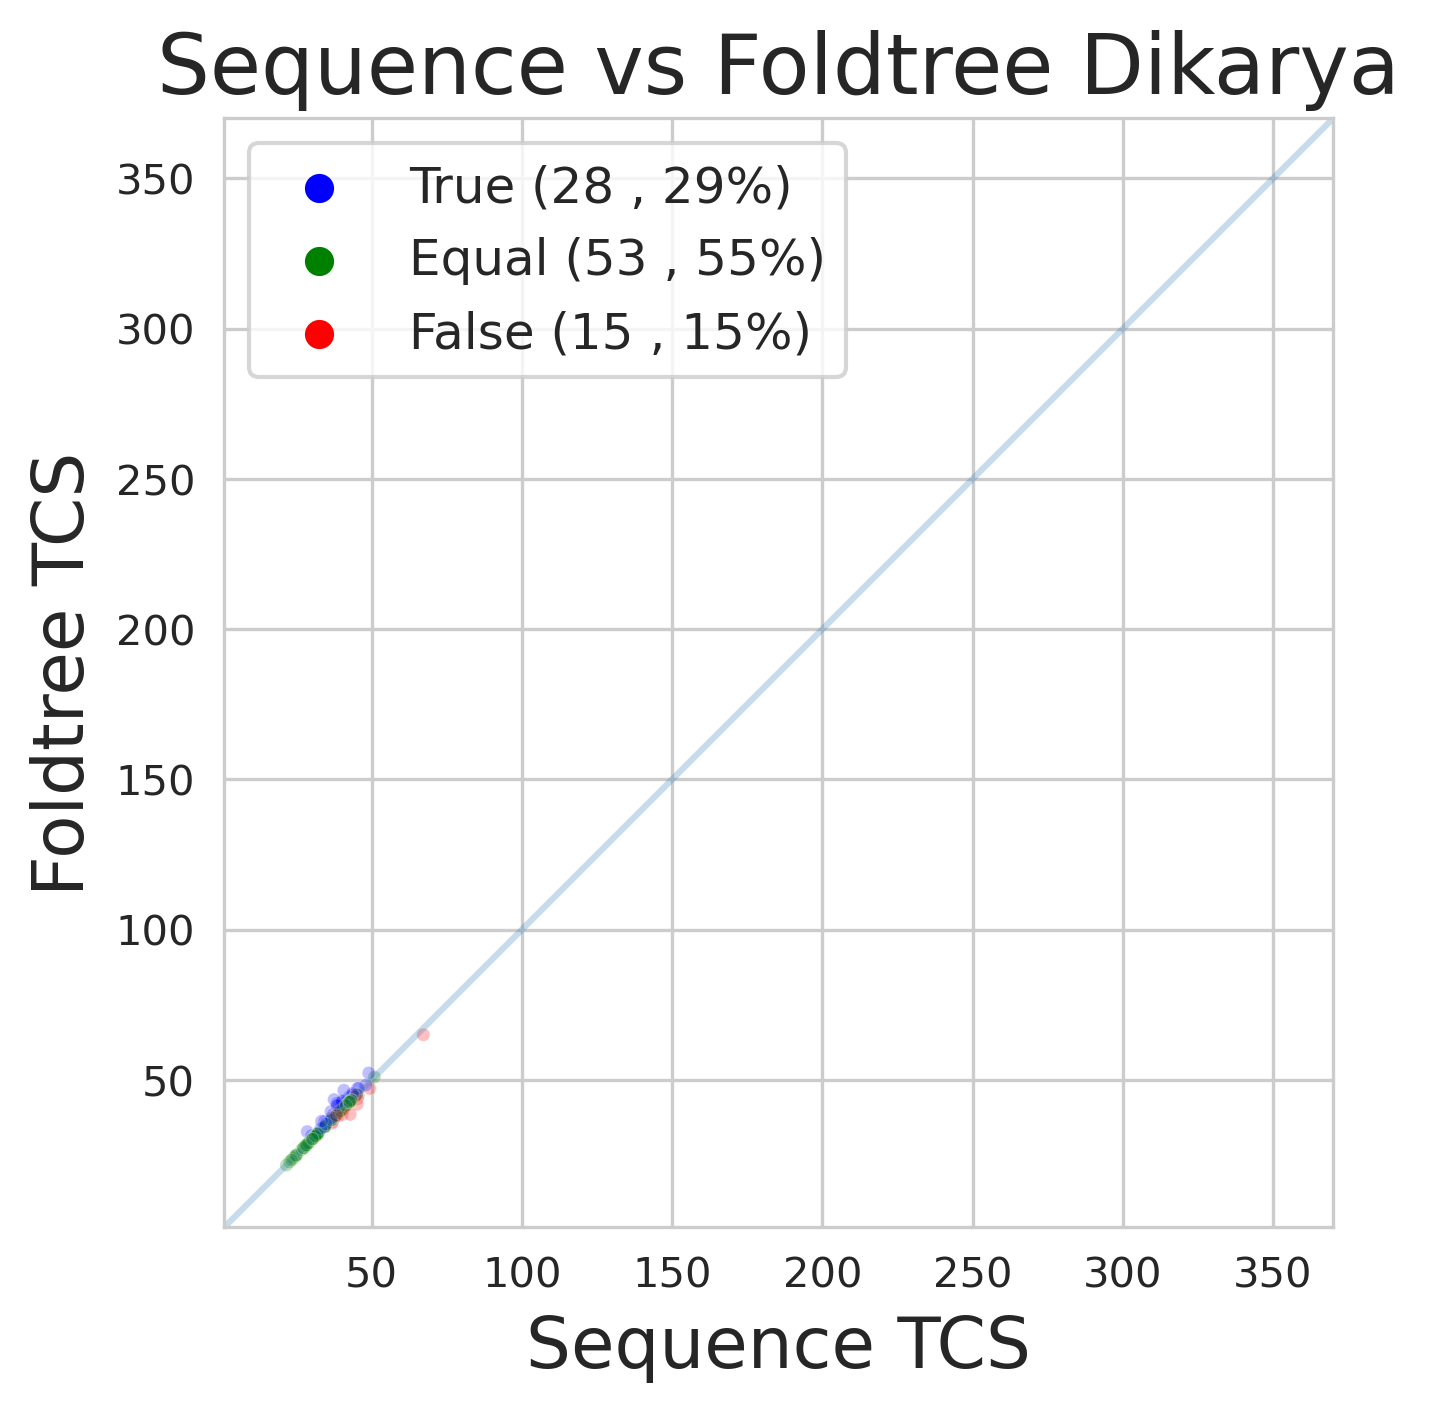

[<matplotlib.collections.PathCollection object at 0x7fa47898b220>, <matplotlib.collections.PathCollection object at 0x7fa47898b670>, <matplotlib.collections.PathCollection object at 0x7fa47898bac0>] ['False', 'True', 'Equal']


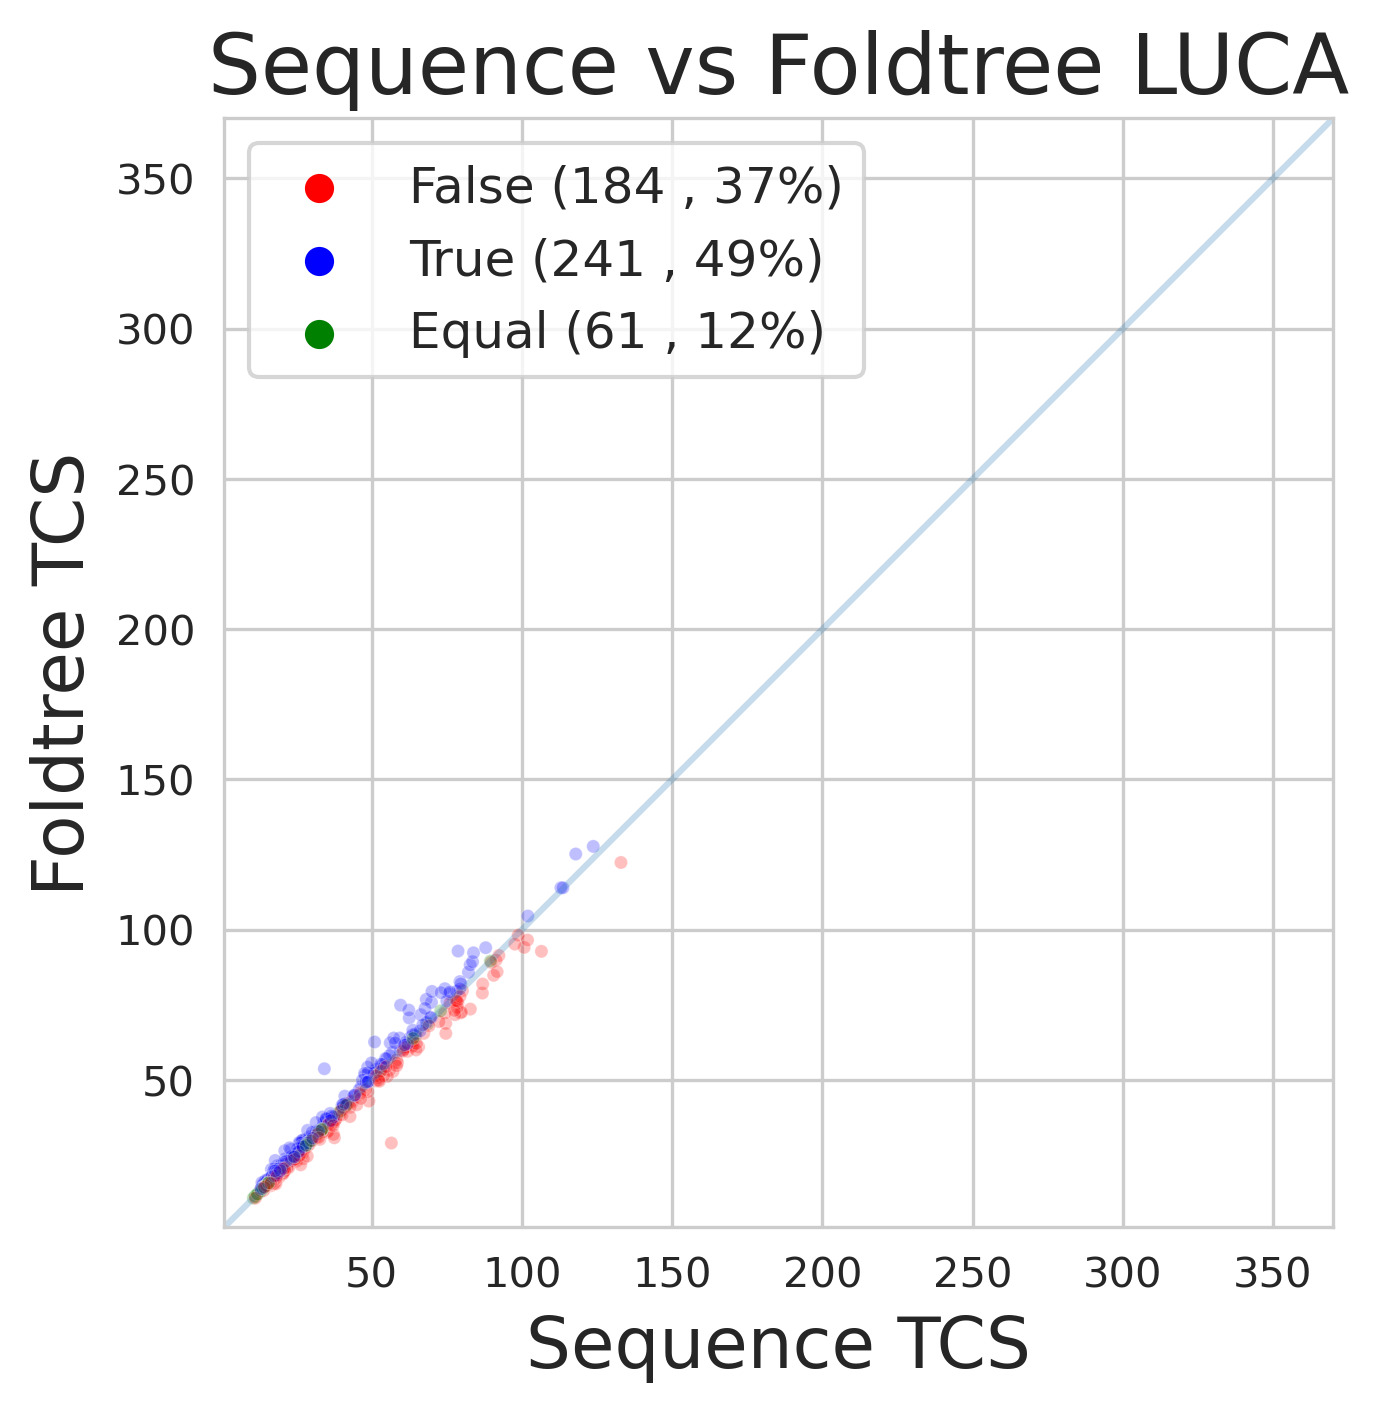

In [23]:
unfiltereddf['level'] = unfiltereddf.index.map( lambda x: x.split('/')[2])
print(unfiltereddf['level'].unique() )
for l in unfiltereddf['level'].unique():
    sub = unfiltereddf[unfiltereddf.level == l ]
    #species tree discordance for cat dataset
    retgraph(  'sequences_norm' , 'fident_1_raw_struct_tree_norm' ,  sub
         ,'Sequence TCS' ,  'Foldtree TCS',  'Sequence vs Foldtree '+ l)

In [24]:
#characterise the ultrametricity of the tree
#todo iterate over hogs and cath and train a model
from compile_treeset import compile_folder_treestats
import pandas as pd
cladefolders = set(glob.glob( '../OMA_data/*/' ))-set([ '../OMA_data/logs/' ])
cladefolders = cladefolders.union( set(glob.glob( '../OMA_data_unfiltered/OMA_data/*/' )) - set([ '../OMA_data_unfiltered/OMA_data/logs/' ]) )
dfs = []
for folder in cladefolders:
    print(folder)
    OMA_treestat_DF = compile_folder_treestats( folder, verbose = False  )
    dfs.append(OMA_treestat_DF)
OMA_treestats = pd.concat(dfs)
print(OMA_treestats)

../OMA_data/Euteleostomi/
../OMA_data/Euteleostomi/
500


processed: 494:  38%|███▊      | 190/500 [00:34<00:55,  5.55it/s]


../OMA_data/LUCA/
../OMA_data/LUCA/
500


processed: 500:  97%|█████████▋| 486/500 [00:15<00:00, 31.75it/s]


../OMA_data/Chordata/
../OMA_data/Chordata/
500


processed: 499:  53%|█████▎    | 266/500 [00:25<00:22, 10.23it/s]


../OMA_data/Bacteria/
../OMA_data/Bacteria/
500


processed: 500:  99%|█████████▉| 495/500 [00:41<00:00, 11.90it/s]


../OMA_data/Tetrapoda/
../OMA_data/Tetrapoda/
359


processed: 358:  46%|████▌     | 166/359 [00:20<00:24,  7.94it/s]


../OMA_data/Opisthokonta/
../OMA_data/Opisthokonta/
500


processed: 500:  69%|██████▉   | 344/500 [00:27<00:12, 12.72it/s]


../OMA_data_unfiltered/OMA_data/Bacteria/
../OMA_data_unfiltered/OMA_data/Bacteria/
500


processed: 500: 100%|█████████▉| 499/500 [00:40<00:00, 12.31it/s]


../OMA_data/Eukaryota/
../OMA_data/Eukaryota/
500


processed: 500:  79%|███████▉  | 394/500 [00:22<00:06, 17.43it/s]


../OMA_data_unfiltered/OMA_data/Opisthokonta/
../OMA_data_unfiltered/OMA_data/Opisthokonta/
500


processed: 500:  99%|█████████▉| 495/500 [00:24<00:00, 19.91it/s]


../OMA_data/Eumetazoa/
../OMA_data/Eumetazoa/
500


processed: 500:  67%|██████▋   | 334/500 [00:42<00:21,  7.77it/s]


../OMA_data_unfiltered/OMA_data/Eumetazoa/
../OMA_data_unfiltered/OMA_data/Eumetazoa/
500


processed: 500: 100%|█████████▉| 499/500 [00:42<00:00, 11.86it/s]


../OMA_data/Fungi/
../OMA_data/Fungi/
138


processed: 138:  45%|████▍     | 62/138 [00:04<00:05, 13.58it/s]


../OMA_data_unfiltered/OMA_data/Tetrapoda/
../OMA_data_unfiltered/OMA_data/Tetrapoda/
359


processed: 359:  99%|█████████▉| 356/359 [00:41<00:00,  8.60it/s]


../OMA_data/Bilateria/
../OMA_data/Bilateria/
500


processed: 496:  46%|████▌     | 229/500 [00:33<00:40,  6.77it/s]


../OMA_data_unfiltered/OMA_data/Bilateria/
../OMA_data_unfiltered/OMA_data/Bilateria/
500


processed: 500:  98%|█████████▊| 489/500 [01:02<00:01,  7.79it/s]


../OMA_data_unfiltered/OMA_data/Chordata/
../OMA_data_unfiltered/OMA_data/Chordata/
500


processed: 500:  99%|█████████▉| 494/500 [00:24<00:00, 20.40it/s]


../OMA_data_unfiltered/OMA_data/Dikarya/
../OMA_data_unfiltered/OMA_data/Dikarya/
186


processed: 186:  99%|█████████▉| 184/186 [00:20<00:00,  9.05it/s]


../OMA_data_unfiltered/OMA_data/Fungi/
../OMA_data_unfiltered/OMA_data/Fungi/
138


processed: 138:  99%|█████████▉| 137/138 [00:17<00:00,  7.78it/s]


../OMA_data_unfiltered/OMA_data/Eukaryota/
../OMA_data_unfiltered/OMA_data/Eukaryota/
500


  0%|          | 0/500 [00:00<?, ?it/s]


../OMA_data/Dikarya/
../OMA_data/Dikarya/
186


processed: 186:  52%|█████▏    | 96/186 [00:11<00:10,  8.65it/s]


../OMA_data_unfiltered/OMA_data/Euteleostomi/
../OMA_data_unfiltered/OMA_data/Euteleostomi/
500


processed: 500:  98%|█████████▊| 491/500 [00:19<00:00, 25.61it/s]


../OMA_data_unfiltered/OMA_data/LUCA/
../OMA_data_unfiltered/OMA_data/LUCA/
500


processed: 500: 100%|██████████| 500/500 [00:43<00:00, 11.55it/s]


                                                                    alntmscore_0_raw_struct_tree  \
../OMA_data/Euteleostomi/HOG611/               [3, [0.9319944226553528, 1.0712416302548577], ...   
../OMA_data/Euteleostomi/HOG2052/              [11, [0.9258547644868327, 1.0993548205696744],...   
../OMA_data/Euteleostomi/HOG2129/              [4, [0.8968175108696276, 1.104181863085768], 1...   
../OMA_data/Euteleostomi/HOG937/               [5, [0.7678003968749565, 1.1952041963282125], ...   
../OMA_data/Euteleostomi/HOG813/               [6, [0.9687597826458428, 1.0535279040360892], ...   
...                                                                                          ...   
../OMA_data_unfiltered/OMA_data/LUCA/HOG1176/  [24, [0.7214346354681521, 1.317139301788144], ...   
../OMA_data_unfiltered/OMA_data/LUCA/HOG503/   [24, [0.6533471558459949, 1.3942686962076392],...   
../OMA_data_unfiltered/OMA_data/LUCA/HOG1068/  [21, [0.794563561804335, 1.1791329818394842], ...   


In [25]:
cladefolders = [ '../CAT_data/' ,'../CATH_data/' ]
dfs = []
for folder in cladefolders:
    print(folder)
    CATH_treestat_DF = compile_folder_treestats( folder, verbose = False  )
    dfs.append(CATH_treestat_DF)
CATH_treestats = pd.concat(dfs)

../CAT_data/
../CAT_data/
1465


processed: 1465:  34%|███▍      | 500/1465 [00:21<00:40, 23.72it/s]


../CATH_data/
../CATH_data/
6485


processed: 6472:  10%|▉         | 635/6485 [00:55<08:33, 11.38it/s]


In [26]:
treestats_df = OMA_treestats.dropna()
print(len(treestats_df))

7170


In [27]:
metrics = 'nobsint,minmax,mean,variance,skewness,kurtosis'
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
cols = []
for c in treestats_df.columns:
    if 'nseqs' not in c and 'var' not in c and '0' not in c and 'exp' not in c:
        treestats_df[c+'var'] = treestats_df[c].map( lambda x : x[3] )
        cols.append(c+'var')
        #plt.hist( treestats_df[c+'var'] , alpha = .25 , label = c, density = True , bins = 20)
#plt.title( 'Variance of normalized Root to Leaf distance')
#plt.legend()
#plt.show()

<Figure size 3000x900 with 0 Axes>

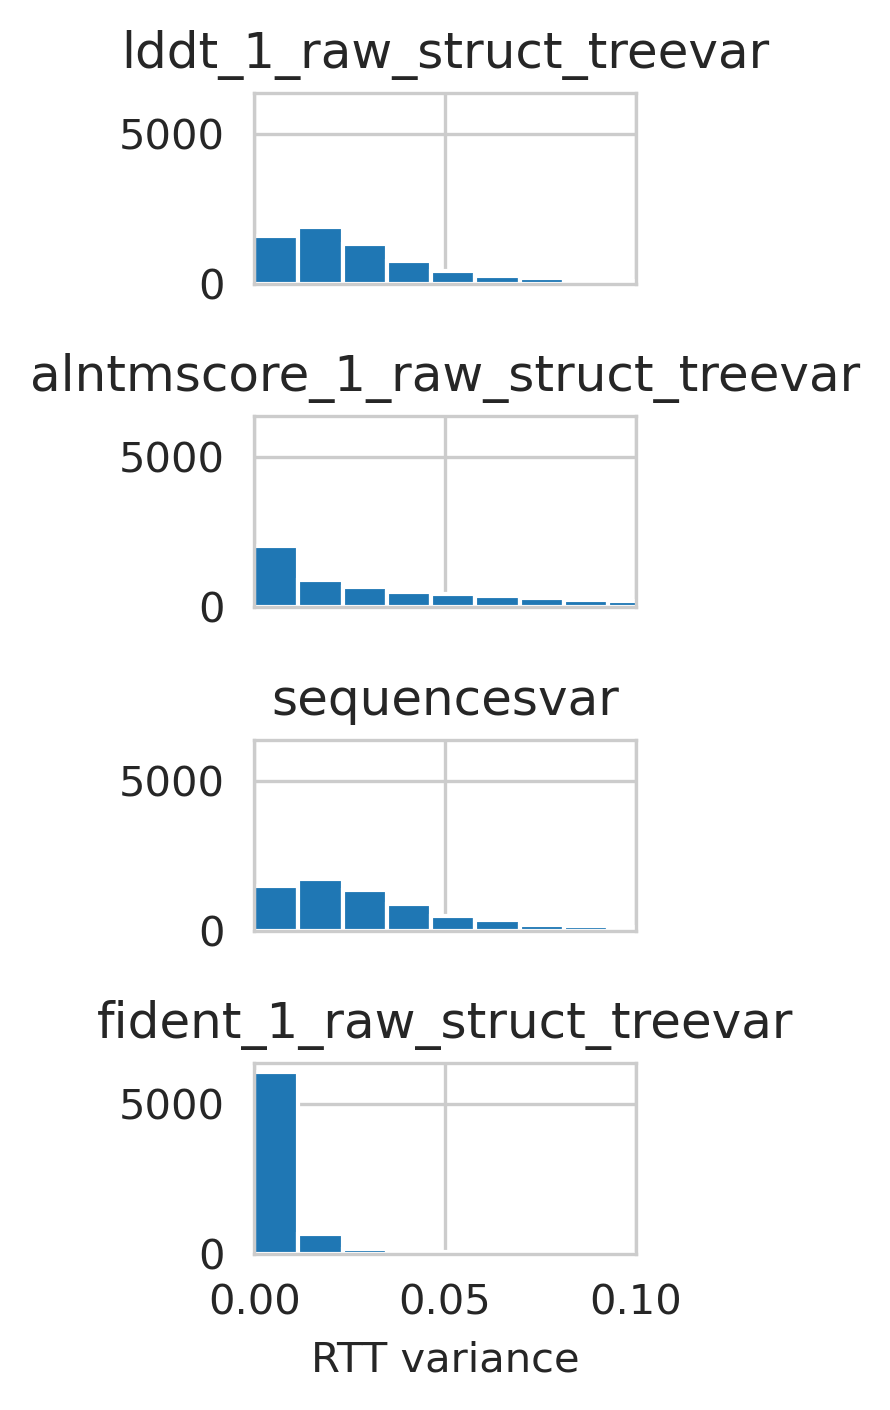

In [28]:
fig, axs = plt.subplots(len(cols), 1, sharex=True,sharey=True, tight_layout=True)
df = treestats_df[cols]
bins=np.histogram(df, bins=500)[1] #get the bin edges
for i,col in enumerate(cols):
    data = df[col] 
    #data[data>.25]= .25
    axs[i].set_box_aspect(.5)

    axs[i].set_xlim(0,.10)
    axs[i].hist( df[col] , bins=bins)
    axs[i].set_title(col)
    if i == len(cols)-1:
        axs[i].set_xlabel('RTT variance')
    #axs[i].set_ylabel('n Trees')

plt.savefig('../figures/ultrametricity_hist.svg')
plt.show()


In [29]:
import toytree
import toyplot
import numpy as np
import toyplot.svg

#select random fams
sub = treestats_df.sample(20)



for idx,r in sub.iterrows():
    
    nwks = glob.glob(idx+'*.nwk.rooted')
    trees = []
    kept= []
    for nwk in nwks:
        if '1_raw' in nwk or 'sequences' in nwk:
            kept.append(nwk)
            trees.append(toytree.tree(nwk , format = 0))
    mtre0 = toytree.mtree( trees )
    
    for tree in mtre0.treelist:
        for n in tree.treenode.traverse():
            if n.is_leaf():
                n.size = 5
                n.color = 'red'
            else:
                n.size = 0
                n.color = 'black'
        sizes = tree.get_node_values("size", show_root=True, show_tips=True)
        colors = tree.get_node_values("color", show_root=True, show_tips=True)
        
        tree.style.node_sizes = sizes
        
        
    canvas,axes,mark = mtre0.draw( ncols=len(cols) ,tip_labels=False ,edge_style={"stroke-opacity": 1, "stroke-width": .5}  ,  height=100 , node_colors= 'red')
    '''tip_labels_align=True, edge_align_style={
        "stroke": "violet",
        "stroke-width": 0,
        "stroke-dasharray": "2,5"    # size of dash, spacing of dashes
    } )'''
    print(kept)
    #toyplot.svg.render(canvas, '../figures/'+idx.replace('/' , '_').replace('.','')+'treesample.svg')
    
print(kept)

['../OMA_data/Chordata/HOG41/fident_1_raw_struct_tree.PP.nwk.rooted', '../OMA_data/Chordata/HOG41/alntmscore_1_raw_struct_tree.PP.nwk.rooted', '../OMA_data/Chordata/HOG41/lddt_1_raw_struct_tree.PP.nwk.rooted', '../OMA_data/Chordata/HOG41/sequences.aln.fst.nwk.rooted']
['../OMA_data_unfiltered/OMA_data/Tetrapoda/HOG211/fident_1_raw_struct_tree.PP.nwk.rooted', '../OMA_data_unfiltered/OMA_data/Tetrapoda/HOG211/alntmscore_1_raw_struct_tree.PP.nwk.rooted', '../OMA_data_unfiltered/OMA_data/Tetrapoda/HOG211/lddt_1_raw_struct_tree.PP.nwk.rooted', '../OMA_data_unfiltered/OMA_data/Tetrapoda/HOG211/sequences.aln.fst.nwk.rooted']
['../OMA_data/Euteleostomi/HOG1241/fident_1_raw_struct_tree.PP.nwk.rooted', '../OMA_data/Euteleostomi/HOG1241/alntmscore_1_raw_struct_tree.PP.nwk.rooted', '../OMA_data/Euteleostomi/HOG1241/lddt_1_raw_struct_tree.PP.nwk.rooted', '../OMA_data/Euteleostomi/HOG1241/sequences.aln.fst.nwk.rooted']
['../OMA_data/Eumetazoa/HOG449/fident_1_raw_struct_tree.PP.nwk.rooted', '../OMA_d

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb55112c735f84eb9ba947f5815bacedc">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="teaab674662dd48d78502a3bbbef1c20e">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb2216d8664ab4264aeb9b1e4ac724fde">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9d9423941366486bb1cd8c49ecd36e64">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdc4bfa1eb6ca4d9d92f4bdcc61c57345">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td0de90cf7e884b7997bdabe305b7f855">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta4b3ffcf9887453ca11585a0c2735732">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te52699d64fb144fb849943d92351df9a">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb9c597ff90c049a6a3228b84c2fb1ffc">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tce32ce2271964af39301512581c55450">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t88e0c1956779407d9d71ad76dcba1b05">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t59dfceb7f9ac45959507614d523dfc73">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta1c788b4530844b38f0ed962bd840bb5">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t22078871bab146ffad46214f72843d72">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb7e38c9db49942bba03e82c1463a7abe">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc58c235370244a708a6a5a440dd01dd8">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td2eb3fddd5f542b396cf204c772a2265">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0eac3b27d5fd4570b5dfee2cd82ebe31">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te55ca05529bd41f8a9c39ab5ab5e5ced">

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="560.0px" height="100.0px" viewBox="0 0 560.0 100.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t040269355bce41ba91454a82aac74fd4">

In [30]:
#plt the OMA clades w and without filtering 
#plot the cat and cath and total oma with and without filtering


In [ ]:
#construct structure and sequence feature dataset
import tqdm

def ret_description(vec , label = ''):
    return { label+'_mean': np.mean(vec) , label+'_max': np.amax(vec) , label+'_min': np.amin(vec) ,label+'_var': np.var(vec) }

cladefolders = set(glob.glob( '../OMA_data/*/' ))-set([ '../OMA_data/logs/' ])
cladefolders = cladefolders.union( set(glob.glob( '../OMA_data_unfiltered/OMA_data/*/' )) - set([ '../OMA_data_unfiltered/OMA_data/logs/' ]) )
allfolders = cladefolders

dfs = []
print(allfolders)
for clade in allfolders:
    print(clade)
    res = {}
    folders = glob.glob(clade + '*/' )
    for folder in tqdm.tqdm_notebook(folders):
        if 'logs' not in folder:
            
            nstructs = len(glob.glob(folder+'structs/*.pdb'))
            try:
                with open(folder + 'sequences.fst') as fstin:
                    nseqs = fstin.read().count('>')
            except:
                nseqs = 0
            if nstructs == nseqs:
                if os.path.isfile(folder + 'plddt.json' ):
                    plddt_df = pd.read_json(folder + 'plddt.json').T
                    if len(plddt_df)>0:
                        plddt_df.columns = 'nobs,minmax,mean,variance,skewness,kurtosis'.split(',')
                        plddt_df['min'] = plddt_df.minmax.map( lambda r: r[0] )
                        plddt_df['max'] = plddt_df.minmax.map( lambda r: r[1] )
                        res[folder] = {}
                        for col in ['nobs', 'min' , 'max' , 'mean' , 'variance' , 'skewness' , 'kurtosis' ]:
                            descriptors = ret_description(plddt_df[col] , label = col)
                            for l in descriptors:
                                res[folder][l] = descriptors[l]
                        #add in some descriptors of the taxonomic spread and sequence set
                        seqdf = pd.read_csv(folder+'sequence_dataset.csv' )
                        res[folder]['nprots'] = len(seqdf)
                        cladesets = [ set(l.split(',')) for l in  seqdf['Taxonomic lineage (Ids)'] ]
                        union_all = cladesets[0]
                        intersection_all = cladesets[0]
                        for c in cladesets:
                            union_all = union_all.union(c)
                            intersection_all.intersection(c)
                        res[folder]['n_clades'] = len(union_all)
                        res[folder]['inter_clades'] = len(intersection_all)
                        res[folder]['inter/nc'] =  res[folder]['inter_clades'] /  res[folder]['n_clades'] 
                        res[folder]['nc/np'] = res[folder]['nprots'] / res[folder]['n_clades']
        
    resdf = pd.DataFrame.from_dict(res, orient = 'index')
    dfs.append(resdf)
seqset_resdf = pd.concat(dfs)



{'../OMA_data/Euteleostomi/', '../OMA_data/LUCA/', '../OMA_data/Chordata/', '../OMA_data/Bacteria/', '../OMA_data/Tetrapoda/', '../OMA_data/Opisthokonta/', '../OMA_data_unfiltered/OMA_data/Bacteria/', '../OMA_data/Eukaryota/', '../OMA_data_unfiltered/OMA_data/Opisthokonta/', '../OMA_data/Eumetazoa/', '../OMA_data_unfiltered/OMA_data/Eumetazoa/', '../OMA_data/Fungi/', '../OMA_data_unfiltered/OMA_data/Tetrapoda/', '../OMA_data/Bilateria/', '../OMA_data_unfiltered/OMA_data/Bilateria/', '../OMA_data_unfiltered/OMA_data/Chordata/', '../OMA_data_unfiltered/OMA_data/Dikarya/', '../OMA_data_unfiltered/OMA_data/Fungi/', '../OMA_data_unfiltered/OMA_data/Eukaryota/', '../OMA_data/Dikarya/', '../OMA_data_unfiltered/OMA_data/Euteleostomi/', '../OMA_data_unfiltered/OMA_data/LUCA/'}
../OMA_data/Euteleostomi/


/tmp/31079487/ipykernel_3633507/1136481107.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for folder in tqdm.tqdm_notebook(folders):


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data/LUCA/


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data/Chordata/


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data/Bacteria/


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data/Tetrapoda/


  0%|          | 0/360 [00:00<?, ?it/s]

../OMA_data/Opisthokonta/


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Bacteria/


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data/Eukaryota/


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Opisthokonta/


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data/Eumetazoa/


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Eumetazoa/


  0%|          | 0/501 [00:00<?, ?it/s]

../OMA_data/Fungi/


  0%|          | 0/139 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Tetrapoda/


  0%|          | 0/360 [00:00<?, ?it/s]

../OMA_data/Bilateria/


  0%|          | 0/501 [00:00<?, ?it/s]

In [ ]:
print(seqset_resdf)
seqset_resdf.to_pickle('structure_and_sequence_qcmetrics.pdl')

In [ ]:
#add to the tree comparison data
tree_resdf = unfiltereddf.merge( seqset_resdf , left_index = True, right_index = True, how = 'inner' )
print(tree_resdf)

In [ ]:
print(tree_resdf.columns)

In [ ]:
#try to predict the delta using these features w gradient boosted trees
#try to predict the RF distance as well

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [ ]:
#'nc/np'

feature_names = ['nobs_mean', 'nobs_max',
       'nobs_min', 'nobs_var', 'min_mean', 'min_max', 'min_min', 'min_var',
       'max_mean', 'max_max', 'max_min', 'max_var', 'mean_mean', 'mean_max',
       'mean_min', 'mean_var', 'variance_mean', 'variance_max', 'variance_min',
       'variance_var', 'skewness_mean', 'skewness_max', 'skewness_min',
       'skewness_var', 'kurtosis_mean', 'kurtosis_max', 'kurtosis_min',
       'kurtosis_var', 'nprots', 'n_clades', 'inter_clades', 'inter/nc','nc/np'
       ]
X, y = tree_resdf[feature_names], tree_resdf.fident_1_raw_struct_tree_norm - tree_resdf.sequences_norm

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)


params = {
    "n_estimators": 200,
    "max_depth": 5,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    "loss": "squared_error",
}


reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=100, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

